In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.conv0 = nn.Conv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = nn.ReLU()
        
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = nn.Linear(input_length, hidden_0)
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_0, output_length)

    def forward(self, x):
        out = self.pool0(self.drop0(self.act0(self.bn0(self.conv0(x)))))
        out = self.pool1(self.drop1(self.act1(self.bn1(self.conv1(out)))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1067, Acc: 0.9684 | Val Loss: 0.0609, Acc: 0.9812


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.0368, Acc: 0.9889


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9893 | Val Loss: 0.0400, Acc: 0.9876


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.0422, Acc: 0.9874


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9933 | Val Loss: 0.0405, Acc: 0.9874


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0515, Acc: 0.9862


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0464, Acc: 0.9867


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0363, Acc: 0.9905


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0487, Acc: 0.9883


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0446, Acc: 0.9889


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0370, Acc: 0.9903


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0561, Acc: 0.9876


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0380, Acc: 0.9916


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0451, Acc: 0.9903


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0443, Acc: 0.9902


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0434, Acc: 0.9903


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0558, Acc: 0.9884


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0369, Acc: 0.9922


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0475, Acc: 0.9916


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0549, Acc: 0.9880


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0496, Acc: 0.9912


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0672, Acc: 0.9891


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0596, Acc: 0.9907


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0538, Acc: 0.9899


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0534, Acc: 0.9912


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0577, Acc: 0.9886


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0451, Acc: 0.9922


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0447, Acc: 0.9926


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0559, Acc: 0.9912


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0476, Acc: 0.9921


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0432, Acc: 0.9933


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0540, Acc: 0.9906


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0466, Acc: 0.9918


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0525, Acc: 0.9912


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0631, Acc: 0.9912


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0535, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0518, Acc: 0.9920


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0808, Acc: 0.9870


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0592, Acc: 0.9912


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0570, Acc: 0.9917


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.0538, Acc: 0.9927


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0530, Acc: 0.9917


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.0553, Acc: 0.9913


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0591, Acc: 0.9913


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0709, Acc: 0.9902


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0647, Acc: 0.9906


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0526, Acc: 0.9917


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0550, Acc: 0.9919


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0578, Acc: 0.9907


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0624, Acc: 0.9913


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0500, Acc: 0.9926


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.0644, Acc: 0.9908


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0639, Acc: 0.9920


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0755, Acc: 0.9913


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0570, Acc: 0.9928


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.0608, Acc: 0.9922


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9990 | Val Loss: 0.0624, Acc: 0.9922


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0689, Acc: 0.9910


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.0727, Acc: 0.9924


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9993 | Val Loss: 0.0756, Acc: 0.9911


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0586, Acc: 0.9923


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.0662, Acc: 0.9919


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0726, Acc: 0.9911


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0679, Acc: 0.9919


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0560, Acc: 0.9927


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.0912, Acc: 0.9904


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1056, Acc: 0.9898


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.0747, Acc: 0.9918


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.0735, Acc: 0.9917


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0748, Acc: 0.9915


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9991 | Val Loss: 0.0651, Acc: 0.9929


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0690, Acc: 0.9936


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0807, Acc: 0.9920


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0779, Acc: 0.9932


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.0809, Acc: 0.9911


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.0852, Acc: 0.9903


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.0667, Acc: 0.9927


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9994 | Val Loss: 0.0597, Acc: 0.9932


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0681, Acc: 0.9933


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0728, Acc: 0.9923


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9990 | Val Loss: 0.0868, Acc: 0.9901


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.0872, Acc: 0.9907


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0778, Acc: 0.9916


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0732, Acc: 0.9925


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0747, Acc: 0.9923


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.0804, Acc: 0.9911


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0933, Acc: 0.9910


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0895, Acc: 0.9920


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9993 | Val Loss: 0.0966, Acc: 0.9909


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9993 | Val Loss: 0.1104, Acc: 0.9902


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9995 | Val Loss: 0.0875, Acc: 0.9919


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0936, Acc: 0.9919


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0889, Acc: 0.9908


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0966, Acc: 0.9900


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.0829, Acc: 0.9918


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0827, Acc: 0.9932


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.0915, Acc: 0.9927


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.0926, Acc: 0.9933


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0884, Acc: 0.9923


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0802, Acc: 0.9931


Final Test Loss: 0.0892 Accuracy: 0.9927


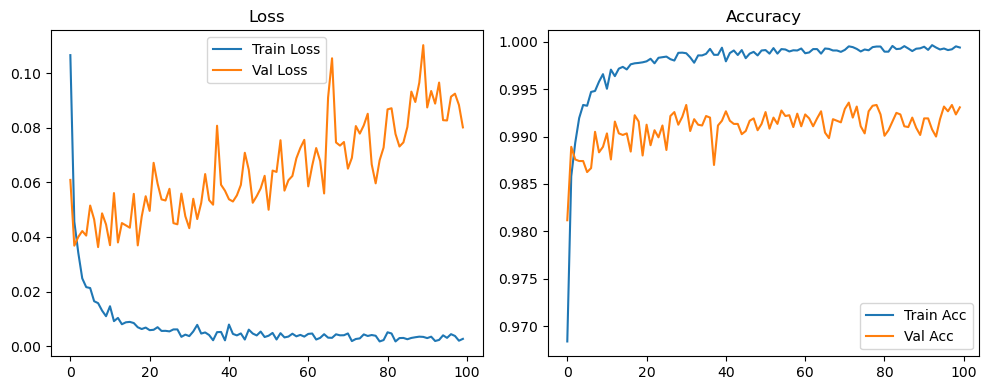

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9604 | Val Loss: 0.1049, Acc: 0.9663


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9798 | Val Loss: 0.0626, Acc: 0.9802


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9843 | Val Loss: 0.0565, Acc: 0.9820


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9860 | Val Loss: 0.0567, Acc: 0.9832


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0504, Acc: 0.9848


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9888 | Val Loss: 0.0995, Acc: 0.9693


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.0483, Acc: 0.9850


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0399, Acc: 0.9880


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9911 | Val Loss: 0.0360, Acc: 0.9894


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.0364, Acc: 0.9892


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.0557, Acc: 0.9838


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0427, Acc: 0.9885


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0364, Acc: 0.9892


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0294, Acc: 0.9909


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.0371, Acc: 0.9902


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0405, Acc: 0.9893


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0480, Acc: 0.9862


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.0434, Acc: 0.9888


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0357, Acc: 0.9899


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0372, Acc: 0.9900


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0375, Acc: 0.9898


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0318, Acc: 0.9920


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0414, Acc: 0.9905


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0340, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0516, Acc: 0.9874


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0408, Acc: 0.9897


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0386, Acc: 0.9909


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0331, Acc: 0.9911


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0440, Acc: 0.9892


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0383, Acc: 0.9905


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0316, Acc: 0.9911


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0421, Acc: 0.9887


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0382, Acc: 0.9903


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0348, Acc: 0.9913


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0350, Acc: 0.9907


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0417, Acc: 0.9892


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0393, Acc: 0.9898


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0387, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0547, Acc: 0.9869


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0386, Acc: 0.9894


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0397, Acc: 0.9897


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0504, Acc: 0.9870


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0432, Acc: 0.9889


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0354, Acc: 0.9908


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0378, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0416, Acc: 0.9882


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0405, Acc: 0.9896


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.0381, Acc: 0.9911


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0558, Acc: 0.9868


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0441, Acc: 0.9890


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0448, Acc: 0.9892


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.0447, Acc: 0.9879


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0383, Acc: 0.9890


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.0462, Acc: 0.9879


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0440, Acc: 0.9889


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0464, Acc: 0.9882


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0472, Acc: 0.9880


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0431, Acc: 0.9887


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0514, Acc: 0.9864


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0450, Acc: 0.9873


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0367, Acc: 0.9896


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0480, Acc: 0.9868


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0741, Acc: 0.9830


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0470, Acc: 0.9886


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0576, Acc: 0.9868


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0547, Acc: 0.9868


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0778, Acc: 0.9829


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0422, Acc: 0.9893


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.0459, Acc: 0.9884


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0392, Acc: 0.9892


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0414, Acc: 0.9888


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0455, Acc: 0.9882


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0532, Acc: 0.9865


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.0467, Acc: 0.9878


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0439, Acc: 0.9877


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0493, Acc: 0.9867


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0581, Acc: 0.9855


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.0404, Acc: 0.9893


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0409, Acc: 0.9892


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0407, Acc: 0.9892


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0484, Acc: 0.9872


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.0562, Acc: 0.9856


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0355, Acc: 0.9902


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.0481, Acc: 0.9871


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.0366, Acc: 0.9897


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.0394, Acc: 0.9893


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0501, Acc: 0.9882


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0447, Acc: 0.9884


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.0684, Acc: 0.9829


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0546, Acc: 0.9872


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0502, Acc: 0.9872


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0505, Acc: 0.9856


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.0441, Acc: 0.9882


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0419, Acc: 0.9893


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0478, Acc: 0.9878


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0493, Acc: 0.9866


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.0454, Acc: 0.9890


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0503, Acc: 0.9871


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0591, Acc: 0.9850


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.0567, Acc: 0.9853


Final Test Loss: 0.0535 Accuracy: 0.9833


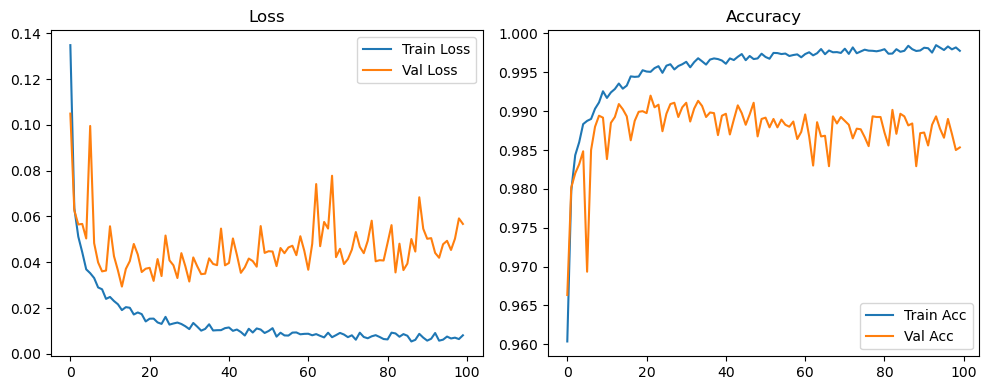

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2245, Acc: 0.9336 | Val Loss: 0.2813, Acc: 0.9164


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9641 | Val Loss: 0.2696, Acc: 0.9192


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1096, Acc: 0.9678 | Val Loss: 0.2181, Acc: 0.9323


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9716 | Val Loss: 0.1913, Acc: 0.9434


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0882, Acc: 0.9724 | Val Loss: 0.1472, Acc: 0.9618


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0816, Acc: 0.9750 | Val Loss: 0.1825, Acc: 0.9619


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9754 | Val Loss: 0.1144, Acc: 0.9754


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9776 | Val Loss: 0.1371, Acc: 0.9685


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9790 | Val Loss: 0.0859, Acc: 0.9843


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0667, Acc: 0.9795 | Val Loss: 0.1021, Acc: 0.9741


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9800 | Val Loss: 0.1277, Acc: 0.9690


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9802 | Val Loss: 0.1484, Acc: 0.9617


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9810 | Val Loss: 0.1545, Acc: 0.9573


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0604, Acc: 0.9813 | Val Loss: 0.1504, Acc: 0.9630


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9822 | Val Loss: 0.1090, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9827 | Val Loss: 0.1441, Acc: 0.9643


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9831 | Val Loss: 0.1679, Acc: 0.9543


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9832 | Val Loss: 0.1611, Acc: 0.9540


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9836 | Val Loss: 0.1757, Acc: 0.9508


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9843 | Val Loss: 0.1760, Acc: 0.9517


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9838 | Val Loss: 0.2150, Acc: 0.9349


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9852 | Val Loss: 0.2294, Acc: 0.9405


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9847 | Val Loss: 0.1993, Acc: 0.9449


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9847 | Val Loss: 0.1753, Acc: 0.9603


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9853 | Val Loss: 0.2808, Acc: 0.9132


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.2411, Acc: 0.9244


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 0.2161, Acc: 0.9417


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9851 | Val Loss: 0.1371, Acc: 0.9676


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.1740, Acc: 0.9563


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9872 | Val Loss: 0.1676, Acc: 0.9577


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9864 | Val Loss: 0.2165, Acc: 0.9293


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.1817, Acc: 0.9528


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9859 | Val Loss: 0.2771, Acc: 0.9087


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.2578, Acc: 0.9261


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.2190, Acc: 0.9435


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.2468, Acc: 0.9498


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9876 | Val Loss: 0.2560, Acc: 0.9412


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9872 | Val Loss: 0.2127, Acc: 0.9594


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9872 | Val Loss: 0.2095, Acc: 0.9509


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9880 | Val Loss: 0.2083, Acc: 0.9457


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9868 | Val Loss: 0.2627, Acc: 0.9317


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.2834, Acc: 0.9214


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.2650, Acc: 0.9314


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.3402, Acc: 0.8942


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.4008, Acc: 0.8763


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9877 | Val Loss: 0.3097, Acc: 0.9183


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.2761, Acc: 0.9327


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.3256, Acc: 0.9039


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.3027, Acc: 0.9227


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 0.4982, Acc: 0.8446


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.4315, Acc: 0.8649


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.4046, Acc: 0.8806


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9882 | Val Loss: 0.4108, Acc: 0.8752


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.3853, Acc: 0.8637


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9886 | Val Loss: 0.4573, Acc: 0.8478


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 0.6628, Acc: 0.7688


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9887 | Val Loss: 0.6873, Acc: 0.7279


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9896 | Val Loss: 0.5687, Acc: 0.7979


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.4607, Acc: 0.8541


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9894 | Val Loss: 0.3296, Acc: 0.9051


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9892 | Val Loss: 0.3680, Acc: 0.8912


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9891 | Val Loss: 0.4264, Acc: 0.8628


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9896 | Val Loss: 0.3248, Acc: 0.8879


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.5225, Acc: 0.8235


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.2272, Acc: 0.9384


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.3509, Acc: 0.8948


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9902 | Val Loss: 0.2377, Acc: 0.9357


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9893 | Val Loss: 0.4068, Acc: 0.8929


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9901 | Val Loss: 0.4031, Acc: 0.8817


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.2353, Acc: 0.9443


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.3934, Acc: 0.8762


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.4008, Acc: 0.8857


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.6022, Acc: 0.7869


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9903 | Val Loss: 0.6615, Acc: 0.7899


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.8976, Acc: 0.6658


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9900 | Val Loss: 0.7958, Acc: 0.7335


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.6894, Acc: 0.7755


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.6299, Acc: 0.7631


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.6437, Acc: 0.7954


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.5587, Acc: 0.8199


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9902 | Val Loss: 0.7288, Acc: 0.7609


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.6465, Acc: 0.7670


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9906 | Val Loss: 0.7688, Acc: 0.7412


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.8938, Acc: 0.6467


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9907 | Val Loss: 0.8976, Acc: 0.6737


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.7558, Acc: 0.7633


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9908 | Val Loss: 0.8476, Acc: 0.6951


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.7144, Acc: 0.7456


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9904 | Val Loss: 0.8044, Acc: 0.7110


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9902 | Val Loss: 0.7057, Acc: 0.7607


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.7437, Acc: 0.7209


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9903 | Val Loss: 0.7394, Acc: 0.7168


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9897 | Val Loss: 0.9559, Acc: 0.7167


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.8939, Acc: 0.6778


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9904 | Val Loss: 0.8409, Acc: 0.7245


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.8096, Acc: 0.7127


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.8297, Acc: 0.6976


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9908 | Val Loss: 1.1770, Acc: 0.6094


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.7783, Acc: 0.7015


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 1.0937, Acc: 0.5893


Final Test Loss: 1.0912 Accuracy: 0.5919


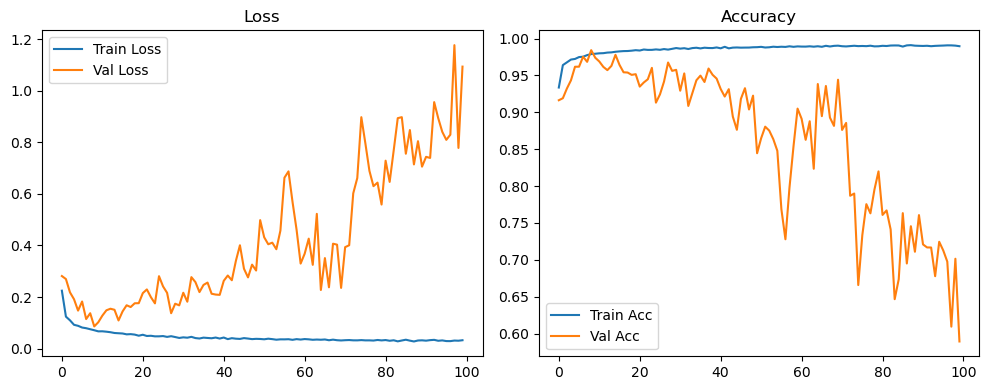

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9684 | Val Loss: 0.0659, Acc: 0.9798


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9858 | Val Loss: 0.0441, Acc: 0.9870


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0380, Acc: 0.9898


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.0439, Acc: 0.9873


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0424, Acc: 0.9878


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0438, Acc: 0.9877


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9945 | Val Loss: 0.0492, Acc: 0.9880


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0488, Acc: 0.9876


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0472, Acc: 0.9884


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0384, Acc: 0.9899


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0405, Acc: 0.9902


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0478, Acc: 0.9887


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0436, Acc: 0.9895


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0370, Acc: 0.9916


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0449, Acc: 0.9905


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0406, Acc: 0.9920


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0419, Acc: 0.9922


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0458, Acc: 0.9900


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0408, Acc: 0.9926


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0419, Acc: 0.9916


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9980 | Val Loss: 0.0573, Acc: 0.9897


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0616, Acc: 0.9907


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0438, Acc: 0.9919


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0492, Acc: 0.9902


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0478, Acc: 0.9918


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0498, Acc: 0.9904


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0448, Acc: 0.9926


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0446, Acc: 0.9930


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0496, Acc: 0.9917


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0538, Acc: 0.9916


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0564, Acc: 0.9912


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0555, Acc: 0.9910


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.0587, Acc: 0.9910


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0541, Acc: 0.9922


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0555, Acc: 0.9923


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0636, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0584, Acc: 0.9922


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0659, Acc: 0.9924


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0693, Acc: 0.9911


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.0609, Acc: 0.9916


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0484, Acc: 0.9928


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0550, Acc: 0.9927


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0630, Acc: 0.9912


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0654, Acc: 0.9913


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0626, Acc: 0.9919


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0624, Acc: 0.9911


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0575, Acc: 0.9922


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0770, Acc: 0.9909


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0705, Acc: 0.9919


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0803, Acc: 0.9915


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0664, Acc: 0.9936


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0666, Acc: 0.9927


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0576, Acc: 0.9933


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0570, Acc: 0.9944


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0646, Acc: 0.9939


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0708, Acc: 0.9924


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0616, Acc: 0.9932


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0592, Acc: 0.9935


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0661, Acc: 0.9930


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0651, Acc: 0.9941


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0700, Acc: 0.9933


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0673, Acc: 0.9933


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0681, Acc: 0.9918


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0686, Acc: 0.9932


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0729, Acc: 0.9921


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.0640, Acc: 0.9933


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0623, Acc: 0.9936


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0681, Acc: 0.9927


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0628, Acc: 0.9932


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0715, Acc: 0.9928


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9937


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0645, Acc: 0.9937


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0749, Acc: 0.9926


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0732, Acc: 0.9935


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0870, Acc: 0.9922


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0778, Acc: 0.9932


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0797, Acc: 0.9928


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0773, Acc: 0.9932


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0830, Acc: 0.9918


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0845, Acc: 0.9924


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0761, Acc: 0.9931


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0814, Acc: 0.9921


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0785, Acc: 0.9933


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0748, Acc: 0.9933


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0728, Acc: 0.9934


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0727, Acc: 0.9934


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0760, Acc: 0.9934


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0768, Acc: 0.9936


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0843, Acc: 0.9931


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0799, Acc: 0.9931


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0785, Acc: 0.9932


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0802, Acc: 0.9934


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0830, Acc: 0.9930


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0807, Acc: 0.9933


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0811, Acc: 0.9938


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0819, Acc: 0.9934


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0828, Acc: 0.9942


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0815, Acc: 0.9937


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0861, Acc: 0.9928


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0907, Acc: 0.9933


Final Test Loss: 0.0713 Accuracy: 0.9930


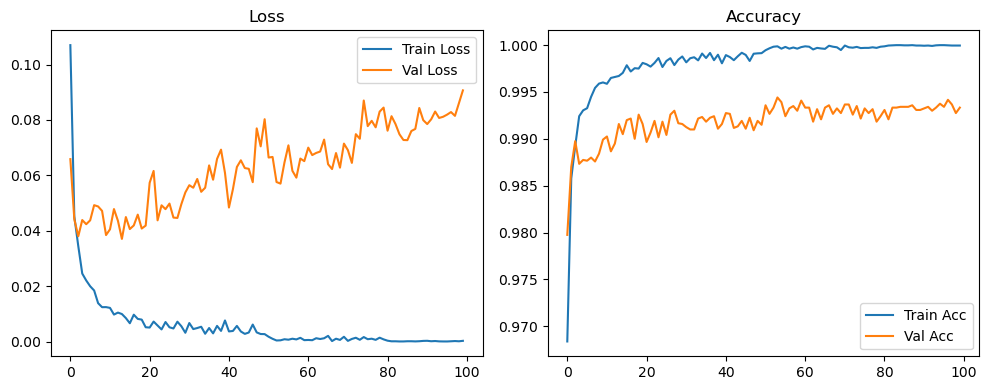

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1349, Acc: 0.9599 | Val Loss: 0.1000, Acc: 0.9693


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9801 | Val Loss: 0.0751, Acc: 0.9767


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9837 | Val Loss: 0.0785, Acc: 0.9756


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.0649, Acc: 0.9798


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.0795, Acc: 0.9773


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.0852, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9892 | Val Loss: 0.0674, Acc: 0.9805


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0393, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.0401, Acc: 0.9881


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0608, Acc: 0.9822


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0474, Acc: 0.9852


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.0384, Acc: 0.9882


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0344, Acc: 0.9892


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0344, Acc: 0.9893


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0352, Acc: 0.9899


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0366, Acc: 0.9891


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.0448, Acc: 0.9864


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0412, Acc: 0.9881


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.0356, Acc: 0.9891


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0479, Acc: 0.9862


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0398, Acc: 0.9882


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0438, Acc: 0.9870


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0481, Acc: 0.9870


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0322, Acc: 0.9895


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0550, Acc: 0.9845


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.0466, Acc: 0.9872


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0383, Acc: 0.9889


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0439, Acc: 0.9874


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0416, Acc: 0.9884


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0372, Acc: 0.9898


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0386, Acc: 0.9895


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0408, Acc: 0.9887


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0352, Acc: 0.9906


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.0405, Acc: 0.9882


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0460, Acc: 0.9882


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0341, Acc: 0.9902


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0421, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0392, Acc: 0.9894


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0393, Acc: 0.9906


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0421, Acc: 0.9891


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0506, Acc: 0.9870


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0409, Acc: 0.9905


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0394, Acc: 0.9888


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0382, Acc: 0.9906


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0373, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0326, Acc: 0.9903


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0369, Acc: 0.9910


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0424, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0370, Acc: 0.9906


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0361, Acc: 0.9898


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0327, Acc: 0.9910


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0313, Acc: 0.9921


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0325, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0342, Acc: 0.9902


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0325, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0334, Acc: 0.9907


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0325, Acc: 0.9908


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0333, Acc: 0.9902


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0346, Acc: 0.9918


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0377, Acc: 0.9907


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0342, Acc: 0.9912


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0349, Acc: 0.9901


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0296, Acc: 0.9918


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0338, Acc: 0.9910


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0392, Acc: 0.9906


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0380, Acc: 0.9907


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0365, Acc: 0.9900


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0381, Acc: 0.9888


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0386, Acc: 0.9891


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0326, Acc: 0.9910


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0375, Acc: 0.9912


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0400, Acc: 0.9893


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0380, Acc: 0.9898


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0338, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0384, Acc: 0.9896


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0345, Acc: 0.9906


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0372, Acc: 0.9900


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0400, Acc: 0.9884


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0330, Acc: 0.9917


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0345, Acc: 0.9918


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0321, Acc: 0.9915


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0333, Acc: 0.9913


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0294, Acc: 0.9926


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0324, Acc: 0.9918


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0316, Acc: 0.9922


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0341, Acc: 0.9912


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0329, Acc: 0.9911


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0319, Acc: 0.9912


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0364, Acc: 0.9900


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0313, Acc: 0.9912


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0314, Acc: 0.9918


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0321, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0302, Acc: 0.9918


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0300, Acc: 0.9919


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0309, Acc: 0.9910


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0321, Acc: 0.9912


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0311, Acc: 0.9920


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0305, Acc: 0.9924


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0323, Acc: 0.9928


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0323, Acc: 0.9920


Final Test Loss: 0.0286 Accuracy: 0.9909


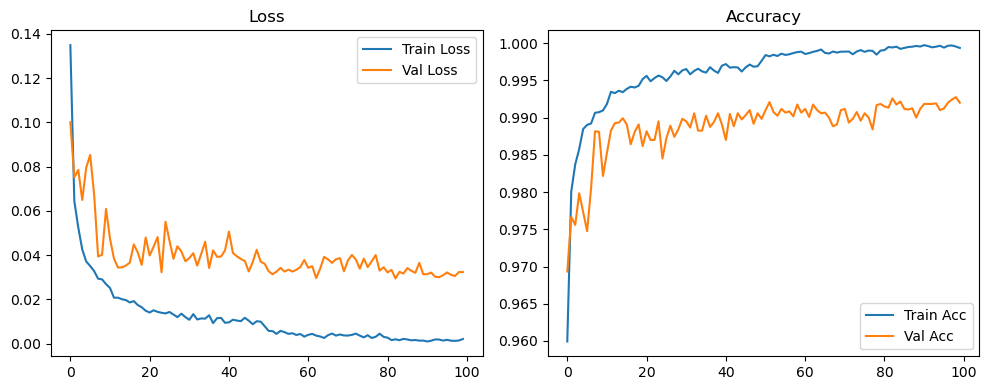

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2247, Acc: 0.9339 | Val Loss: 0.3280, Acc: 0.8953


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1253, Acc: 0.9635 | Val Loss: 0.2523, Acc: 0.9225


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1096, Acc: 0.9677 | Val Loss: 0.2098, Acc: 0.9392


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9717 | Val Loss: 0.1283, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9728 | Val Loss: 0.1655, Acc: 0.9532


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9744 | Val Loss: 0.1801, Acc: 0.9587


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9759 | Val Loss: 0.1231, Acc: 0.9737


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9774 | Val Loss: 0.1366, Acc: 0.9640


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9798 | Val Loss: 0.1057, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9787 | Val Loss: 0.0805, Acc: 0.9846


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9799 | Val Loss: 0.1117, Acc: 0.9754


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9810 | Val Loss: 0.1252, Acc: 0.9684


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.1196, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0602, Acc: 0.9820 | Val Loss: 0.1095, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9828 | Val Loss: 0.1072, Acc: 0.9808


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9830 | Val Loss: 0.1008, Acc: 0.9807


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9826 | Val Loss: 0.0947, Acc: 0.9821


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9826 | Val Loss: 0.1266, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9835 | Val Loss: 0.1450, Acc: 0.9676


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9851 | Val Loss: 0.0906, Acc: 0.9804


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9844 | Val Loss: 0.2008, Acc: 0.9462


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.1466, Acc: 0.9653


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9858 | Val Loss: 0.1670, Acc: 0.9584


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9851 | Val Loss: 0.1598, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.2217, Acc: 0.9324


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9855 | Val Loss: 0.1339, Acc: 0.9642


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.0932, Acc: 0.9800


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9855 | Val Loss: 0.1008, Acc: 0.9786


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9856 | Val Loss: 0.2027, Acc: 0.9508


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.1340, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9873 | Val Loss: 0.1481, Acc: 0.9694


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9869 | Val Loss: 0.1175, Acc: 0.9751


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9863 | Val Loss: 0.1581, Acc: 0.9623


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9866 | Val Loss: 0.1318, Acc: 0.9710


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1709, Acc: 0.9616


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9873 | Val Loss: 0.1790, Acc: 0.9642


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9881 | Val Loss: 0.1976, Acc: 0.9537


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9867 | Val Loss: 0.1995, Acc: 0.9733


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9872 | Val Loss: 0.1913, Acc: 0.9630


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9881 | Val Loss: 0.2263, Acc: 0.9553


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9869 | Val Loss: 0.3332, Acc: 0.9069


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9879 | Val Loss: 0.2344, Acc: 0.9497


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.1938, Acc: 0.9571


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9881 | Val Loss: 0.2024, Acc: 0.9653


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9878 | Val Loss: 0.3502, Acc: 0.9278


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9876 | Val Loss: 0.2560, Acc: 0.9490


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.1811, Acc: 0.9650


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9885 | Val Loss: 0.2404, Acc: 0.9613


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.2178, Acc: 0.9639


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.3390, Acc: 0.9265


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.2974, Acc: 0.9273


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.2629, Acc: 0.9388


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.3645, Acc: 0.9073


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9915 | Val Loss: 0.2568, Acc: 0.9345


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9914 | Val Loss: 0.3578, Acc: 0.9171


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9928 | Val Loss: 0.2849, Acc: 0.9291


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.3075, Acc: 0.9022


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.2923, Acc: 0.9144


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.3779, Acc: 0.8956


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9918 | Val Loss: 0.2631, Acc: 0.9355


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9918 | Val Loss: 0.2655, Acc: 0.9356


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.3743, Acc: 0.9011


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.2726, Acc: 0.9307


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.3126, Acc: 0.9018


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.3300, Acc: 0.8909


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9923 | Val Loss: 0.3768, Acc: 0.8922


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.3269, Acc: 0.8978


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.3661, Acc: 0.9016


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9926 | Val Loss: 0.2301, Acc: 0.9516


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.3876, Acc: 0.9202


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.3626, Acc: 0.9026


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.4091, Acc: 0.8990


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.3243, Acc: 0.9237


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.3268, Acc: 0.9298


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.3105, Acc: 0.9362


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.3688, Acc: 0.9087


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.3535, Acc: 0.9045


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.3932, Acc: 0.8894


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.3588, Acc: 0.8825


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.3320, Acc: 0.9160


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9922 | Val Loss: 0.4803, Acc: 0.8533


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.4044, Acc: 0.8815


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.3950, Acc: 0.8959


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.5173, Acc: 0.8293


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.4696, Acc: 0.8506


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.4259, Acc: 0.8742


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.4063, Acc: 0.8759


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.4566, Acc: 0.8529


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.3877, Acc: 0.8752


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.4591, Acc: 0.8620


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.4073, Acc: 0.8794


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9943 | Val Loss: 0.4387, Acc: 0.8443


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.4910, Acc: 0.8626


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.4455, Acc: 0.8643


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.5071, Acc: 0.8508


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.4519, Acc: 0.8678


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.4749, Acc: 0.8536


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9943 | Val Loss: 0.4702, Acc: 0.8719


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.4563, Acc: 0.8552


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.5480, Acc: 0.8442


Final Test Loss: 0.5454 Accuracy: 0.8480


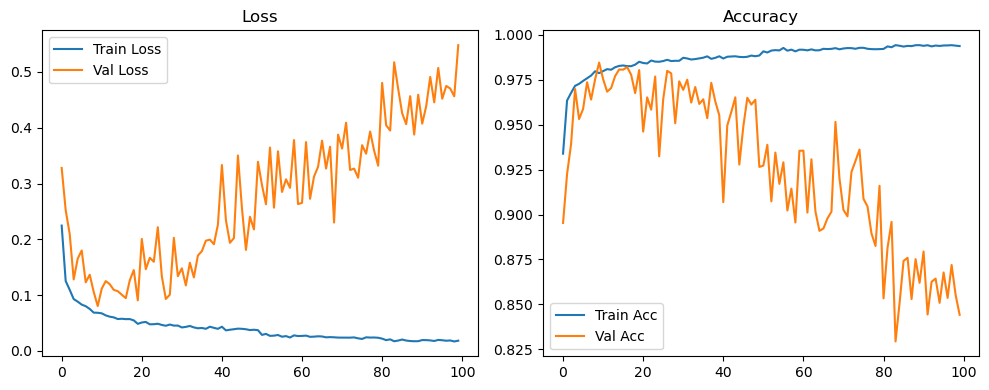

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1065, Acc: 0.9681 | Val Loss: 0.0592, Acc: 0.9822


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.0411, Acc: 0.9861


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9892 | Val Loss: 0.0419, Acc: 0.9873


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0416, Acc: 0.9888


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0382, Acc: 0.9879


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0418, Acc: 0.9891


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0456, Acc: 0.9885


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0434, Acc: 0.9893


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0390, Acc: 0.9903


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0420, Acc: 0.9897


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0407, Acc: 0.9909


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0523, Acc: 0.9893


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0390, Acc: 0.9908


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0463, Acc: 0.9905


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0455, Acc: 0.9913


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0418, Acc: 0.9915


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0445, Acc: 0.9917


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.0494, Acc: 0.9908


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0425, Acc: 0.9912


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0464, Acc: 0.9911


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0525, Acc: 0.9910


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0627, Acc: 0.9898


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0620, Acc: 0.9898


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0520, Acc: 0.9915


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0436, Acc: 0.9928


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0528, Acc: 0.9913


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0616, Acc: 0.9902


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0514, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0515, Acc: 0.9917


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0587, Acc: 0.9919


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0566, Acc: 0.9909


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0559, Acc: 0.9902


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0535, Acc: 0.9913


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0481, Acc: 0.9929


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0474, Acc: 0.9935


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0490, Acc: 0.9924


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0455, Acc: 0.9927


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0497, Acc: 0.9921


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0533, Acc: 0.9918


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0623, Acc: 0.9922


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.0567, Acc: 0.9918


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0572, Acc: 0.9931


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0755, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0535, Acc: 0.9929


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0687, Acc: 0.9912


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0689, Acc: 0.9914


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9986 | Val Loss: 0.0668, Acc: 0.9918


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0756, Acc: 0.9921


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0696, Acc: 0.9920


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0602, Acc: 0.9928


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0571, Acc: 0.9928


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0613, Acc: 0.9928


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0538, Acc: 0.9937


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0563, Acc: 0.9939


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0563, Acc: 0.9935


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0619, Acc: 0.9938


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0673, Acc: 0.9928


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0676, Acc: 0.9930


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0751, Acc: 0.9928


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0596, Acc: 0.9941


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0691, Acc: 0.9932


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0767, Acc: 0.9923


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0679, Acc: 0.9926


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0648, Acc: 0.9928


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0681, Acc: 0.9932


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9935


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9930


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0762, Acc: 0.9935


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0799, Acc: 0.9935


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0751, Acc: 0.9930


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0768, Acc: 0.9929


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0771, Acc: 0.9920


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0761, Acc: 0.9934


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0746, Acc: 0.9934


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0755, Acc: 0.9930


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0932, Acc: 0.9923


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0745, Acc: 0.9933


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0711, Acc: 0.9932


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0780, Acc: 0.9938


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0692, Acc: 0.9939


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9942


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0702, Acc: 0.9939


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0689, Acc: 0.9940


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0681, Acc: 0.9942


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0682, Acc: 0.9941


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9945


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9948


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0702, Acc: 0.9944


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9937


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9934


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0671, Acc: 0.9941


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0704, Acc: 0.9938


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9938


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0669, Acc: 0.9942


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0697, Acc: 0.9936


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9942


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0708, Acc: 0.9943


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9942


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0673, Acc: 0.9942


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9940


Final Test Loss: 0.0560 Accuracy: 0.9931


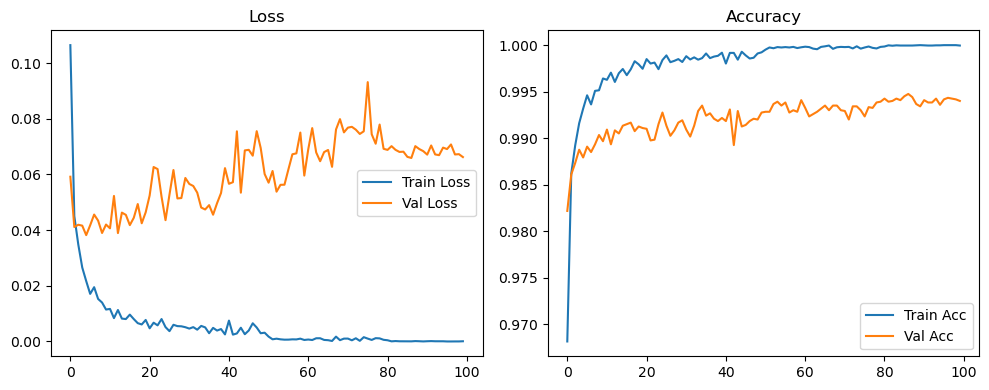

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9609 | Val Loss: 0.0894, Acc: 0.9727


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9800 | Val Loss: 0.0616, Acc: 0.9814


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9831 | Val Loss: 0.0845, Acc: 0.9728


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9862 | Val Loss: 0.0660, Acc: 0.9801


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9891 | Val Loss: 0.0550, Acc: 0.9841


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.0683, Acc: 0.9791


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0565, Acc: 0.9828


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0490, Acc: 0.9854


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0526, Acc: 0.9843


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0430, Acc: 0.9860


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.0393, Acc: 0.9878


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0378, Acc: 0.9888


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.0356, Acc: 0.9892


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0334, Acc: 0.9901


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9928 | Val Loss: 0.0353, Acc: 0.9896


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0360, Acc: 0.9897


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0464, Acc: 0.9869


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0458, Acc: 0.9877


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0363, Acc: 0.9900


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0421, Acc: 0.9893


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.0426, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0467, Acc: 0.9879


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0394, Acc: 0.9886


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0480, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0640, Acc: 0.9842


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.0459, Acc: 0.9883


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0376, Acc: 0.9902


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0470, Acc: 0.9883


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0556, Acc: 0.9858


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0435, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0362, Acc: 0.9910


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0385, Acc: 0.9883


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0402, Acc: 0.9888


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0480, Acc: 0.9882


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0484, Acc: 0.9876


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0353, Acc: 0.9906


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0508, Acc: 0.9867


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0414, Acc: 0.9890


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0498, Acc: 0.9862


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0448, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0393, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0312, Acc: 0.9912


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.0343, Acc: 0.9914


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0333, Acc: 0.9905


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0351, Acc: 0.9901


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0473, Acc: 0.9868


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0353, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0388, Acc: 0.9895


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0401, Acc: 0.9895


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0416, Acc: 0.9884


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0356, Acc: 0.9896


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0305, Acc: 0.9908


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0330, Acc: 0.9901


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0374, Acc: 0.9893


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0369, Acc: 0.9895


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0428, Acc: 0.9897


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0362, Acc: 0.9908


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0353, Acc: 0.9903


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0386, Acc: 0.9900


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0419, Acc: 0.9888


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0382, Acc: 0.9899


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9987 | Val Loss: 0.0402, Acc: 0.9896


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0401, Acc: 0.9906


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0402, Acc: 0.9898


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0391, Acc: 0.9904


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0338, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0373, Acc: 0.9898


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0422, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0352, Acc: 0.9909


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0333, Acc: 0.9912


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0409, Acc: 0.9899


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0364, Acc: 0.9909


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0346, Acc: 0.9909


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0330, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0343, Acc: 0.9908


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0318, Acc: 0.9912


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0357, Acc: 0.9913


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0325, Acc: 0.9919


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0360, Acc: 0.9910


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0316, Acc: 0.9916


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0288, Acc: 0.9923


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0326, Acc: 0.9916


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0300, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0318, Acc: 0.9915


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0311, Acc: 0.9916


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0305, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0327, Acc: 0.9920


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0321, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0332, Acc: 0.9917


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0302, Acc: 0.9920


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0294, Acc: 0.9929


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0300, Acc: 0.9920


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0288, Acc: 0.9923


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0328, Acc: 0.9916


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0322, Acc: 0.9916


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0345, Acc: 0.9916


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0355, Acc: 0.9910


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0304, Acc: 0.9919


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0301, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0290, Acc: 0.9922


Final Test Loss: 0.0293 Accuracy: 0.9907


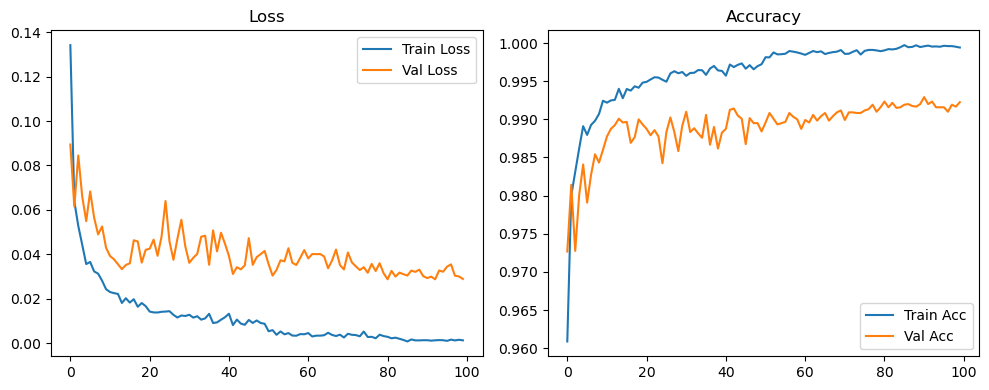

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2252, Acc: 0.9335 | Val Loss: 0.4021, Acc: 0.8648


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9627 | Val Loss: 0.3100, Acc: 0.8978


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1116, Acc: 0.9669 | Val Loss: 0.1997, Acc: 0.9433


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0919, Acc: 0.9725 | Val Loss: 0.2062, Acc: 0.9341


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9731 | Val Loss: 0.1291, Acc: 0.9685


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9749 | Val Loss: 0.1997, Acc: 0.9463


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9760 | Val Loss: 0.1313, Acc: 0.9640


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9777 | Val Loss: 0.1596, Acc: 0.9577


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9789 | Val Loss: 0.1315, Acc: 0.9671


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9800 | Val Loss: 0.0932, Acc: 0.9807


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9793 | Val Loss: 0.1402, Acc: 0.9610


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9812 | Val Loss: 0.1095, Acc: 0.9746


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9805 | Val Loss: 0.1180, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9820 | Val Loss: 0.1379, Acc: 0.9612


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9816 | Val Loss: 0.1117, Acc: 0.9742


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9828 | Val Loss: 0.1105, Acc: 0.9717


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9840 | Val Loss: 0.1432, Acc: 0.9622


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9833 | Val Loss: 0.1683, Acc: 0.9620


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9830 | Val Loss: 0.1176, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9842 | Val Loss: 0.1363, Acc: 0.9666


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9841 | Val Loss: 0.1739, Acc: 0.9520


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.1566, Acc: 0.9581


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9852 | Val Loss: 0.2322, Acc: 0.9296


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.2476, Acc: 0.9300


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 0.1756, Acc: 0.9523


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9853 | Val Loss: 0.1837, Acc: 0.9543


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.1789, Acc: 0.9548


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9856 | Val Loss: 0.1335, Acc: 0.9631


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9858 | Val Loss: 0.2558, Acc: 0.9496


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.1582, Acc: 0.9623


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9863 | Val Loss: 0.1706, Acc: 0.9634


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9862 | Val Loss: 0.1839, Acc: 0.9572


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9866 | Val Loss: 0.2150, Acc: 0.9496


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.2546, Acc: 0.9382


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.2852, Acc: 0.9161


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9864 | Val Loss: 0.1671, Acc: 0.9727


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.1970, Acc: 0.9582


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9867 | Val Loss: 0.2442, Acc: 0.9444


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9878 | Val Loss: 0.2622, Acc: 0.9431


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.2742, Acc: 0.9350


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.3511, Acc: 0.8856


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9880 | Val Loss: 0.2100, Acc: 0.9580


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9879 | Val Loss: 0.2467, Acc: 0.9455


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9882 | Val Loss: 0.2621, Acc: 0.9348


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9882 | Val Loss: 0.3184, Acc: 0.9130


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9876 | Val Loss: 0.2786, Acc: 0.9421


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.2332, Acc: 0.9438


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9879 | Val Loss: 0.1746, Acc: 0.9650


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.2135, Acc: 0.9417


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.3476, Acc: 0.9003


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.2532, Acc: 0.9387


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9905 | Val Loss: 0.2541, Acc: 0.9388


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9916 | Val Loss: 0.3028, Acc: 0.9146


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.2414, Acc: 0.9395


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.2413, Acc: 0.9425


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9915 | Val Loss: 0.2233, Acc: 0.9428


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.3239, Acc: 0.9130


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.2378, Acc: 0.9391


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9920 | Val Loss: 0.2545, Acc: 0.9378


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9919 | Val Loss: 0.3430, Acc: 0.8972


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9924 | Val Loss: 0.2831, Acc: 0.9308


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9912 | Val Loss: 0.5538, Acc: 0.7972


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.2828, Acc: 0.9189


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.3140, Acc: 0.9041


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.3027, Acc: 0.9106


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.3531, Acc: 0.9048


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.3556, Acc: 0.8808


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9920 | Val Loss: 0.4289, Acc: 0.8860


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.3267, Acc: 0.9161


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9926 | Val Loss: 0.3722, Acc: 0.9057


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.3111, Acc: 0.9038


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.3900, Acc: 0.8939


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.2850, Acc: 0.9255


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.3186, Acc: 0.9171


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.3697, Acc: 0.9016


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.3359, Acc: 0.9302


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.2541, Acc: 0.9448


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9927 | Val Loss: 0.3576, Acc: 0.8988


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9927 | Val Loss: 0.3446, Acc: 0.9031


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9918 | Val Loss: 0.4186, Acc: 0.8870


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.5288, Acc: 0.8548


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.4721, Acc: 0.8620


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9933 | Val Loss: 0.4813, Acc: 0.8651


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.4765, Acc: 0.8563


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.4948, Acc: 0.8558


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.4790, Acc: 0.8632


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.4693, Acc: 0.8553


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.4420, Acc: 0.8728


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.3946, Acc: 0.8859


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.4462, Acc: 0.8790


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.4544, Acc: 0.8724


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.4288, Acc: 0.8638


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9934 | Val Loss: 0.4738, Acc: 0.8683


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9942 | Val Loss: 0.4484, Acc: 0.8664


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.4972, Acc: 0.8542


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.4664, Acc: 0.8666


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.4751, Acc: 0.8632


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.4396, Acc: 0.8792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.4411, Acc: 0.8774


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.4751, Acc: 0.8721


Final Test Loss: 0.4726 Accuracy: 0.8719


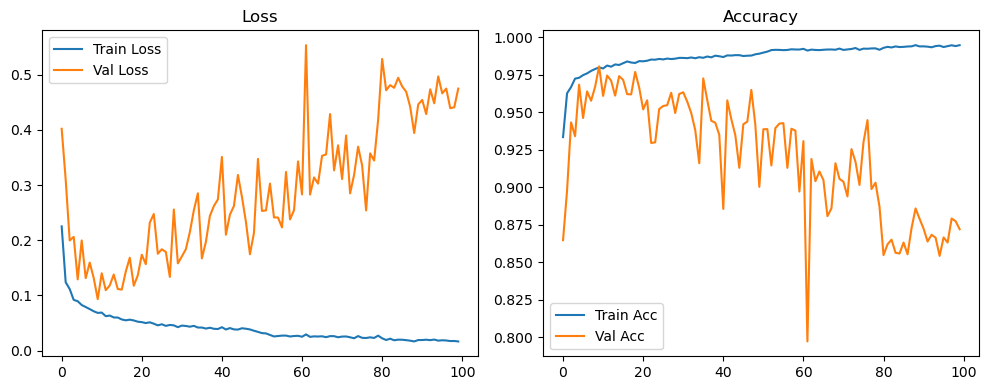

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9684 | Val Loss: 0.0710, Acc: 0.9776


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9862 | Val Loss: 0.0461, Acc: 0.9858


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9892 | Val Loss: 0.0407, Acc: 0.9869


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.0408, Acc: 0.9877


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0451, Acc: 0.9869


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0625, Acc: 0.9831


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0403, Acc: 0.9895


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0356, Acc: 0.9903


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0437, Acc: 0.9896


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0418, Acc: 0.9907


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0483, Acc: 0.9889


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0476, Acc: 0.9902


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0455, Acc: 0.9894


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0429, Acc: 0.9905


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0666, Acc: 0.9870


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0452, Acc: 0.9898


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0380, Acc: 0.9918


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0540, Acc: 0.9902


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0472, Acc: 0.9919


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0616, Acc: 0.9893


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0583, Acc: 0.9898


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0641, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0470, Acc: 0.9910


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0566, Acc: 0.9906


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0480, Acc: 0.9917


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0475, Acc: 0.9922


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.0447, Acc: 0.9927


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0536, Acc: 0.9903


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0532, Acc: 0.9912


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0520, Acc: 0.9909


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0515, Acc: 0.9922


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0454, Acc: 0.9928


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0455, Acc: 0.9927


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0489, Acc: 0.9911


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0532, Acc: 0.9912


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0672, Acc: 0.9906


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0530, Acc: 0.9921


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0687, Acc: 0.9904


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0729, Acc: 0.9903


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0635, Acc: 0.9916


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0592, Acc: 0.9912


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0683, Acc: 0.9900


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0727, Acc: 0.9908


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0607, Acc: 0.9920


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0724, Acc: 0.9920


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.0654, Acc: 0.9918


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0724, Acc: 0.9907


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0758, Acc: 0.9903


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0659, Acc: 0.9908


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0629, Acc: 0.9916


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0599, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0591, Acc: 0.9927


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0578, Acc: 0.9929


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0578, Acc: 0.9931


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9929


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9929


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0607, Acc: 0.9928


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0619, Acc: 0.9931


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9929


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0592, Acc: 0.9931


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9935


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0614, Acc: 0.9928


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9933


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0573, Acc: 0.9932


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0588, Acc: 0.9922


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0578, Acc: 0.9930


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0667, Acc: 0.9929


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0669, Acc: 0.9925


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9932


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9932


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9927


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9932


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9928


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9930


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0642, Acc: 0.9931


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0691, Acc: 0.9930


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9923


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9925


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9930


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9927


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9931


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9927


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0666, Acc: 0.9928


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0690, Acc: 0.9923


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9925


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0693, Acc: 0.9929


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9929


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0664, Acc: 0.9932


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0677, Acc: 0.9932


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0664, Acc: 0.9931


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9931


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9934


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0673, Acc: 0.9933


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9929


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0683, Acc: 0.9930


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0718, Acc: 0.9928


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0701, Acc: 0.9927


Final Test Loss: 0.0590 Accuracy: 0.9932


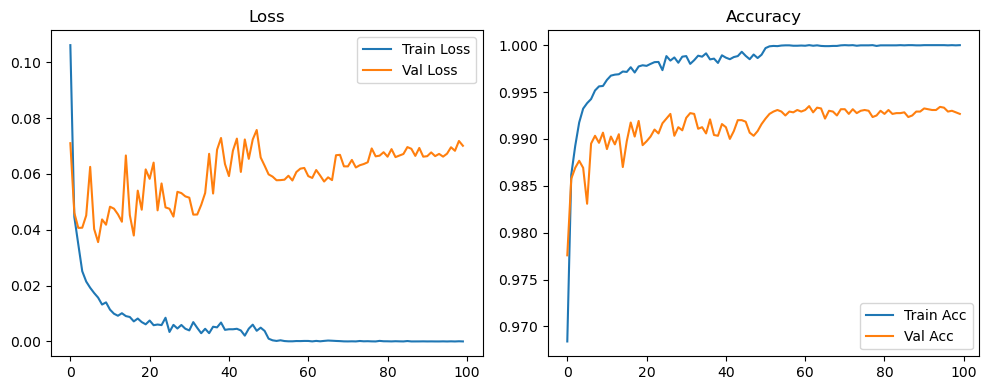

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9605 | Val Loss: 0.1213, Acc: 0.9625


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9807 | Val Loss: 0.0692, Acc: 0.9782


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9830 | Val Loss: 0.0751, Acc: 0.9768


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9869 | Val Loss: 0.0526, Acc: 0.9846


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0479, Acc: 0.9858


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.0660, Acc: 0.9811


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.0561, Acc: 0.9832


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0424, Acc: 0.9872


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0351, Acc: 0.9895


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0420, Acc: 0.9878


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0397, Acc: 0.9886


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0400, Acc: 0.9872


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0487, Acc: 0.9858


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0419, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.0410, Acc: 0.9897


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0411, Acc: 0.9888


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0462, Acc: 0.9877


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0448, Acc: 0.9875


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0398, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0359, Acc: 0.9908


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0411, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0487, Acc: 0.9869


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0387, Acc: 0.9896


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0372, Acc: 0.9903


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0450, Acc: 0.9893


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0465, Acc: 0.9880


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0452, Acc: 0.9873


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0376, Acc: 0.9899


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0392, Acc: 0.9900


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0385, Acc: 0.9899


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0352, Acc: 0.9906


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0435, Acc: 0.9891


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0369, Acc: 0.9893


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0461, Acc: 0.9874


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0362, Acc: 0.9900


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0365, Acc: 0.9905


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0469, Acc: 0.9879


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0466, Acc: 0.9877


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0389, Acc: 0.9905


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0382, Acc: 0.9888


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0320, Acc: 0.9923


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0394, Acc: 0.9899


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0318, Acc: 0.9915


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0409, Acc: 0.9895


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0462, Acc: 0.9881


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0381, Acc: 0.9892


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0387, Acc: 0.9893


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0454, Acc: 0.9884


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0459, Acc: 0.9872


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0418, Acc: 0.9908


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0392, Acc: 0.9908


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0363, Acc: 0.9915


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0352, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0364, Acc: 0.9915


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0377, Acc: 0.9917


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.0361, Acc: 0.9920


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0362, Acc: 0.9920


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0364, Acc: 0.9914


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0368, Acc: 0.9922


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0345, Acc: 0.9924


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0318, Acc: 0.9929


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0366, Acc: 0.9922


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0301, Acc: 0.9933


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0313, Acc: 0.9925


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0352, Acc: 0.9926


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0340, Acc: 0.9919


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0337, Acc: 0.9920


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0337, Acc: 0.9922


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0358, Acc: 0.9916


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0339, Acc: 0.9925


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0363, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0339, Acc: 0.9917


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0347, Acc: 0.9919


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0343, Acc: 0.9919


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0345, Acc: 0.9913


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0327, Acc: 0.9923


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0301, Acc: 0.9928


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0339, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0337, Acc: 0.9920


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0343, Acc: 0.9919


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0289, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0344, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0302, Acc: 0.9931


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0335, Acc: 0.9926


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0324, Acc: 0.9927


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0316, Acc: 0.9924


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0311, Acc: 0.9930


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0342, Acc: 0.9926


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0347, Acc: 0.9920


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0331, Acc: 0.9925


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0311, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0343, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0282, Acc: 0.9934


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0328, Acc: 0.9926


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0335, Acc: 0.9925


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0310, Acc: 0.9926


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0316, Acc: 0.9926


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0319, Acc: 0.9926


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0322, Acc: 0.9932


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0313, Acc: 0.9925


Final Test Loss: 0.0298 Accuracy: 0.9918


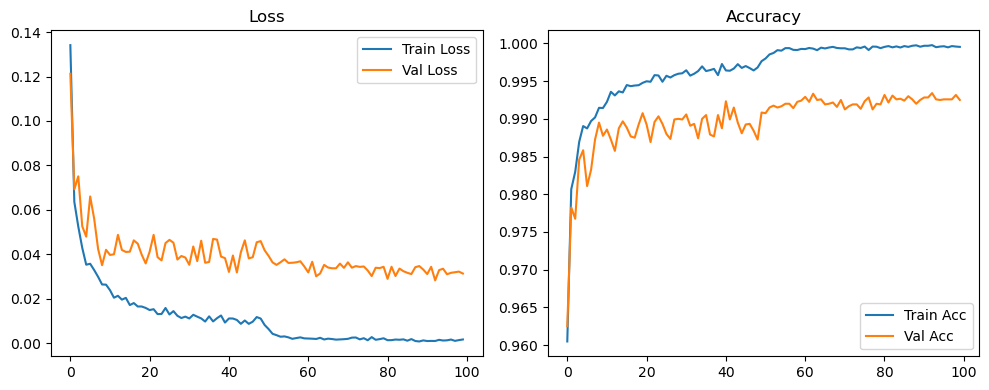

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2237, Acc: 0.9344 | Val Loss: 0.3378, Acc: 0.8916


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1232, Acc: 0.9634 | Val Loss: 0.1906, Acc: 0.9483


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1087, Acc: 0.9680 | Val Loss: 0.1413, Acc: 0.9633


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9726 | Val Loss: 0.1118, Acc: 0.9735


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9744 | Val Loss: 0.1454, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9755 | Val Loss: 0.1629, Acc: 0.9624


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0800, Acc: 0.9758 | Val Loss: 0.1276, Acc: 0.9700


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9775 | Val Loss: 0.1334, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9796 | Val Loss: 0.1086, Acc: 0.9778


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9790 | Val Loss: 0.1073, Acc: 0.9769


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0677, Acc: 0.9798 | Val Loss: 0.1352, Acc: 0.9680


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9811 | Val Loss: 0.1407, Acc: 0.9606


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9809 | Val Loss: 0.1294, Acc: 0.9685


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9813 | Val Loss: 0.1161, Acc: 0.9731


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0587, Acc: 0.9825 | Val Loss: 0.0988, Acc: 0.9796


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9828 | Val Loss: 0.0903, Acc: 0.9800


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9832 | Val Loss: 0.1207, Acc: 0.9725


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9822 | Val Loss: 0.1551, Acc: 0.9690


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9838 | Val Loss: 0.1077, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9844 | Val Loss: 0.1144, Acc: 0.9773


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9845 | Val Loss: 0.1935, Acc: 0.9523


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9841 | Val Loss: 0.1766, Acc: 0.9573


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9844 | Val Loss: 0.1679, Acc: 0.9617


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9848 | Val Loss: 0.1986, Acc: 0.9555


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9844 | Val Loss: 0.2073, Acc: 0.9437


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9856 | Val Loss: 0.1576, Acc: 0.9543


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9854 | Val Loss: 0.1455, Acc: 0.9673


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9853 | Val Loss: 0.1167, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9861 | Val Loss: 0.2303, Acc: 0.9611


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.1136, Acc: 0.9803


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9866 | Val Loss: 0.2315, Acc: 0.9447


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9861 | Val Loss: 0.1703, Acc: 0.9635


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 0.1874, Acc: 0.9693


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9866 | Val Loss: 0.1596, Acc: 0.9649


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9863 | Val Loss: 0.1913, Acc: 0.9479


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9867 | Val Loss: 0.2323, Acc: 0.9470


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.2397, Acc: 0.9436


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9863 | Val Loss: 0.2168, Acc: 0.9560


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.1711, Acc: 0.9597


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.2001, Acc: 0.9616


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.2143, Acc: 0.9508


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.2010, Acc: 0.9473


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9883 | Val Loss: 0.1746, Acc: 0.9574


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.2807, Acc: 0.9311


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.3381, Acc: 0.9143


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9871 | Val Loss: 0.2407, Acc: 0.9604


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9882 | Val Loss: 0.2367, Acc: 0.9597


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9886 | Val Loss: 0.2277, Acc: 0.9551


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.3413, Acc: 0.9118


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9881 | Val Loss: 0.4907, Acc: 0.8565


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.4484, Acc: 0.8862


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.3300, Acc: 0.9153


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.3302, Acc: 0.9227


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.2892, Acc: 0.9305


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.3400, Acc: 0.9150


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.3425, Acc: 0.9152


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.3334, Acc: 0.9170


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.3842, Acc: 0.9096


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.3680, Acc: 0.9121


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9934 | Val Loss: 0.3802, Acc: 0.9117


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.3265, Acc: 0.9277


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9931 | Val Loss: 0.3834, Acc: 0.8979


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.3500, Acc: 0.8994


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.3221, Acc: 0.9184


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.2752, Acc: 0.9327


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.2830, Acc: 0.9344


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.3077, Acc: 0.9126


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.4045, Acc: 0.8860


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.3471, Acc: 0.9093


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.3665, Acc: 0.8967


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.3759, Acc: 0.8895


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9937 | Val Loss: 0.3182, Acc: 0.9098


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.4123, Acc: 0.8816


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.4006, Acc: 0.8914


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9937 | Val Loss: 0.3530, Acc: 0.9073


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.3341, Acc: 0.9183


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.3242, Acc: 0.9342


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9933 | Val Loss: 0.3790, Acc: 0.8902


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.4055, Acc: 0.8843


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.3464, Acc: 0.9081


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.4245, Acc: 0.8893


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.4434, Acc: 0.8732


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9940 | Val Loss: 0.4026, Acc: 0.8975


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.3964, Acc: 0.8852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.4002, Acc: 0.8928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.3986, Acc: 0.9007


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.3853, Acc: 0.8940


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.3980, Acc: 0.8901


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.4229, Acc: 0.8842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.4490, Acc: 0.8837


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.4783, Acc: 0.8710


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.4135, Acc: 0.8767


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.4374, Acc: 0.8910


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.4291, Acc: 0.8874


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.4394, Acc: 0.8752


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.4382, Acc: 0.8860


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.4266, Acc: 0.8951


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.4256, Acc: 0.8975


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.3933, Acc: 0.9067


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.4370, Acc: 0.8925


Final Test Loss: 0.4343 Accuracy: 0.8927


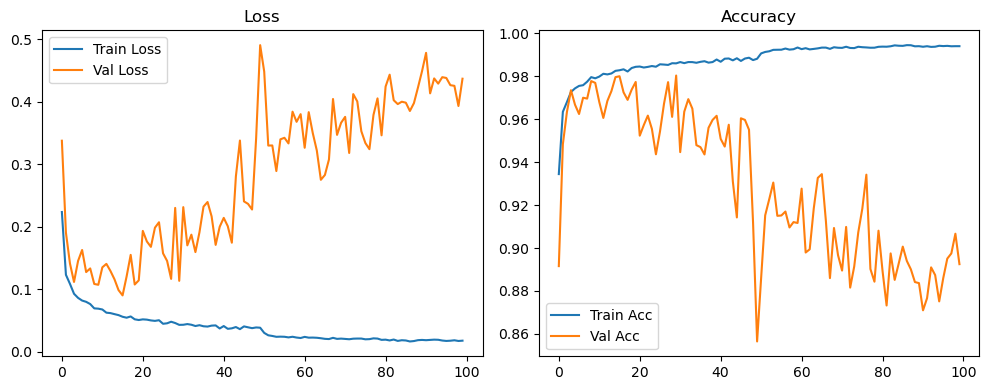

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1044, Acc: 0.9710 | Val Loss: 0.0573, Acc: 0.9811


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.0370, Acc: 0.9878


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0391, Acc: 0.9871


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0401, Acc: 0.9877


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0410, Acc: 0.9886


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0363, Acc: 0.9893


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0415, Acc: 0.9887


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0353, Acc: 0.9898


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0431, Acc: 0.9888


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0374, Acc: 0.9898


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0368, Acc: 0.9908


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0431, Acc: 0.9895


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0372, Acc: 0.9911


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0452, Acc: 0.9892


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0390, Acc: 0.9912


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0364, Acc: 0.9910


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0372, Acc: 0.9913


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0387, Acc: 0.9905


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0417, Acc: 0.9912


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0367, Acc: 0.9912


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0468, Acc: 0.9910


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0373, Acc: 0.9921


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0466, Acc: 0.9901


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0450, Acc: 0.9907


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0447, Acc: 0.9916


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0424, Acc: 0.9914


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0458, Acc: 0.9918


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0403, Acc: 0.9922


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0426, Acc: 0.9911


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0460, Acc: 0.9917


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0473, Acc: 0.9916


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0464, Acc: 0.9918


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0452, Acc: 0.9919


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0647, Acc: 0.9893


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0510, Acc: 0.9921


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0554, Acc: 0.9910


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0559, Acc: 0.9912


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0680, Acc: 0.9898


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0543, Acc: 0.9914


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9922


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0579, Acc: 0.9915


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0563, Acc: 0.9911


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0501, Acc: 0.9925


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0540, Acc: 0.9922


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0628, Acc: 0.9913


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.0545, Acc: 0.9904


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0561, Acc: 0.9912


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0632, Acc: 0.9907


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0494, Acc: 0.9926


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0582, Acc: 0.9910


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0487, Acc: 0.9922


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0639, Acc: 0.9906


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0659, Acc: 0.9906


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0584, Acc: 0.9915


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0572, Acc: 0.9911


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0623, Acc: 0.9916


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0580, Acc: 0.9918


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0521, Acc: 0.9927


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0552, Acc: 0.9918


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0522, Acc: 0.9922


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0511, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0524, Acc: 0.9919


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0526, Acc: 0.9922


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0529, Acc: 0.9928


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0543, Acc: 0.9921


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0748, Acc: 0.9918


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0676, Acc: 0.9909


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0557, Acc: 0.9921


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0720, Acc: 0.9904


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0581, Acc: 0.9918


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0599, Acc: 0.9921


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0568, Acc: 0.9925


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0628, Acc: 0.9919


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0576, Acc: 0.9918


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0681, Acc: 0.9907


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0575, Acc: 0.9919


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0574, Acc: 0.9928


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0810, Acc: 0.9893


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0683, Acc: 0.9922


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0564, Acc: 0.9925


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0619, Acc: 0.9916


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0678, Acc: 0.9922


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0766, Acc: 0.9903


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0672, Acc: 0.9920


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0617, Acc: 0.9920


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0693, Acc: 0.9911


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0653, Acc: 0.9926


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0692, Acc: 0.9920


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0797, Acc: 0.9913


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0811, Acc: 0.9914


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0716, Acc: 0.9924


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.0752, Acc: 0.9912


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0658, Acc: 0.9925


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0690, Acc: 0.9928


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0612, Acc: 0.9936


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0661, Acc: 0.9932


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0676, Acc: 0.9923


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0770, Acc: 0.9916


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0724, Acc: 0.9924


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0713, Acc: 0.9922


Final Test Loss: 0.0599 Accuracy: 0.9920


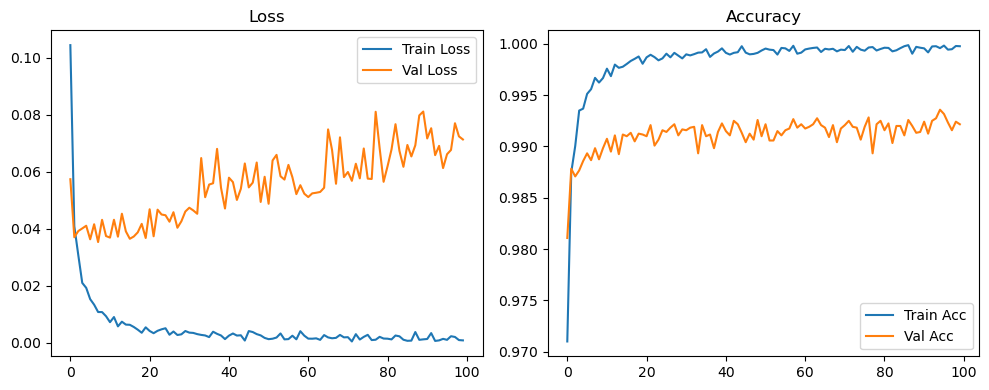

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1305, Acc: 0.9641 | Val Loss: 0.0825, Acc: 0.9740


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.0592, Acc: 0.9812


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.0560, Acc: 0.9828


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.0556, Acc: 0.9832


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 0.0449, Acc: 0.9861


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.0495, Acc: 0.9852


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.0447, Acc: 0.9859


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0395, Acc: 0.9889


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0334, Acc: 0.9904


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0395, Acc: 0.9878


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9936 | Val Loss: 0.0336, Acc: 0.9890


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.0325, Acc: 0.9904


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9947 | Val Loss: 0.0339, Acc: 0.9894


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0414, Acc: 0.9881


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0318, Acc: 0.9907


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0308, Acc: 0.9912


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0426, Acc: 0.9866


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0298, Acc: 0.9909


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0293, Acc: 0.9917


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0307, Acc: 0.9904


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0318, Acc: 0.9901


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0368, Acc: 0.9902


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0406, Acc: 0.9880


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0269, Acc: 0.9919


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0424, Acc: 0.9868


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0262, Acc: 0.9926


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0273, Acc: 0.9918


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0297, Acc: 0.9904


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0358, Acc: 0.9891


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0319, Acc: 0.9902


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0300, Acc: 0.9920


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0333, Acc: 0.9909


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0276, Acc: 0.9923


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0341, Acc: 0.9896


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0277, Acc: 0.9922


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0301, Acc: 0.9920


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0383, Acc: 0.9897


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0331, Acc: 0.9906


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0374, Acc: 0.9890


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0325, Acc: 0.9906


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0314, Acc: 0.9904


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0386, Acc: 0.9888


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0333, Acc: 0.9908


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0336, Acc: 0.9904


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0304, Acc: 0.9912


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0292, Acc: 0.9920


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0324, Acc: 0.9913


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0330, Acc: 0.9916


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0380, Acc: 0.9891


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0366, Acc: 0.9895


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0340, Acc: 0.9906


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0267, Acc: 0.9924


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0300, Acc: 0.9916


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0328, Acc: 0.9902


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0304, Acc: 0.9914


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0312, Acc: 0.9913


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0288, Acc: 0.9920


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0336, Acc: 0.9911


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0350, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0266, Acc: 0.9929


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0283, Acc: 0.9913


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.0287, Acc: 0.9926


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0287, Acc: 0.9925


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0303, Acc: 0.9922


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0315, Acc: 0.9924


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0281, Acc: 0.9926


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0314, Acc: 0.9919


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0359, Acc: 0.9912


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0375, Acc: 0.9896


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0274, Acc: 0.9920


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0335, Acc: 0.9910


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0330, Acc: 0.9915


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0299, Acc: 0.9907


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0297, Acc: 0.9911


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0349, Acc: 0.9898


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0374, Acc: 0.9902


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0307, Acc: 0.9909


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0284, Acc: 0.9925


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0356, Acc: 0.9906


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0283, Acc: 0.9929


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0294, Acc: 0.9922


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0297, Acc: 0.9924


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0319, Acc: 0.9916


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0286, Acc: 0.9918


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0291, Acc: 0.9918


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0299, Acc: 0.9916


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0351, Acc: 0.9894


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0310, Acc: 0.9923


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0366, Acc: 0.9895


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0329, Acc: 0.9919


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0330, Acc: 0.9912


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0340, Acc: 0.9909


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0357, Acc: 0.9908


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0347, Acc: 0.9905


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0439, Acc: 0.9878


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0389, Acc: 0.9894


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0336, Acc: 0.9908


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0288, Acc: 0.9928


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0369, Acc: 0.9896


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0393, Acc: 0.9889


Final Test Loss: 0.0397 Accuracy: 0.9873


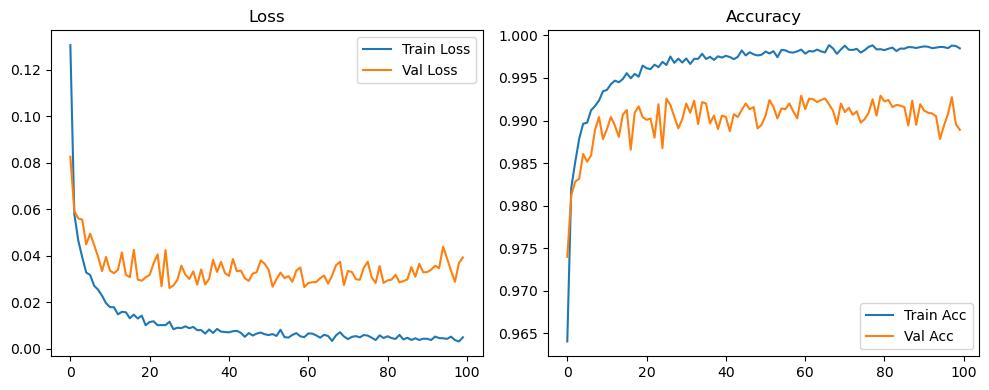

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2232, Acc: 0.9380 | Val Loss: 0.3107, Acc: 0.9022


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1149, Acc: 0.9664 | Val Loss: 0.2347, Acc: 0.9237


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0996, Acc: 0.9703 | Val Loss: 0.2032, Acc: 0.9379


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0824, Acc: 0.9752 | Val Loss: 0.1527, Acc: 0.9542


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9767 | Val Loss: 0.1501, Acc: 0.9511


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9785 | Val Loss: 0.1633, Acc: 0.9534


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9789 | Val Loss: 0.1206, Acc: 0.9665


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9801 | Val Loss: 0.0834, Acc: 0.9833


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9813 | Val Loss: 0.0906, Acc: 0.9782


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9826 | Val Loss: 0.0816, Acc: 0.9826


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9816 | Val Loss: 0.1061, Acc: 0.9738


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9831 | Val Loss: 0.0931, Acc: 0.9761


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9822 | Val Loss: 0.1236, Acc: 0.9686


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9841 | Val Loss: 0.0922, Acc: 0.9806


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9844 | Val Loss: 0.0972, Acc: 0.9810


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9850 | Val Loss: 0.1287, Acc: 0.9672


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9856 | Val Loss: 0.1151, Acc: 0.9729


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9856 | Val Loss: 0.1248, Acc: 0.9728


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9857 | Val Loss: 0.1023, Acc: 0.9799


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9861 | Val Loss: 0.1099, Acc: 0.9748


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9857 | Val Loss: 0.1403, Acc: 0.9637


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.1807, Acc: 0.9559


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9867 | Val Loss: 0.1919, Acc: 0.9537


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.1357, Acc: 0.9757


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.1256, Acc: 0.9758


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9869 | Val Loss: 0.1605, Acc: 0.9703


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9874 | Val Loss: 0.1118, Acc: 0.9806


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9873 | Val Loss: 0.1107, Acc: 0.9809


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9883 | Val Loss: 0.1811, Acc: 0.9715


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9878 | Val Loss: 0.1426, Acc: 0.9761


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9890 | Val Loss: 0.1308, Acc: 0.9807


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.1310, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.1402, Acc: 0.9748


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9886 | Val Loss: 0.2009, Acc: 0.9595


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 0.2032, Acc: 0.9592


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9890 | Val Loss: 0.1873, Acc: 0.9657


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.1785, Acc: 0.9662


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9889 | Val Loss: 0.1601, Acc: 0.9745


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.1433, Acc: 0.9818


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9888 | Val Loss: 0.1891, Acc: 0.9666


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9895 | Val Loss: 0.2111, Acc: 0.9570


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.2310, Acc: 0.9603


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.1962, Acc: 0.9673


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.2413, Acc: 0.9521


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.2104, Acc: 0.9545


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1784, Acc: 0.9747


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9893 | Val Loss: 0.2032, Acc: 0.9647


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.1911, Acc: 0.9702


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9896 | Val Loss: 0.2974, Acc: 0.9294


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9900 | Val Loss: 0.3366, Acc: 0.9290


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.2848, Acc: 0.9511


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.2685, Acc: 0.9498


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.4556, Acc: 0.9080


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.2675, Acc: 0.9452


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.3772, Acc: 0.9179


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9911 | Val Loss: 0.2351, Acc: 0.9570


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.3794, Acc: 0.9011


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.3053, Acc: 0.9326


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9908 | Val Loss: 0.3874, Acc: 0.9072


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9911 | Val Loss: 0.3458, Acc: 0.9274


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9908 | Val Loss: 0.4341, Acc: 0.9041


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9907 | Val Loss: 0.4568, Acc: 0.8593


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.2065, Acc: 0.9597


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.4027, Acc: 0.9028


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9909 | Val Loss: 0.4129, Acc: 0.9073


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.5438, Acc: 0.8542


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9921 | Val Loss: 0.3360, Acc: 0.9139


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9909 | Val Loss: 0.4343, Acc: 0.9018


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9920 | Val Loss: 0.2668, Acc: 0.9533


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9910 | Val Loss: 0.3296, Acc: 0.9158


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.3812, Acc: 0.9018


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.4288, Acc: 0.9134


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.6069, Acc: 0.8453


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.6057, Acc: 0.8380


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.7698, Acc: 0.7594


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.5570, Acc: 0.8417


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.5617, Acc: 0.8637


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9915 | Val Loss: 0.6866, Acc: 0.7996


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.4334, Acc: 0.8728


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.3659, Acc: 0.9146


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.4848, Acc: 0.8642


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.4626, Acc: 0.8758


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.4406, Acc: 0.8822


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.4055, Acc: 0.8898


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.4583, Acc: 0.8876


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.4290, Acc: 0.8891


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.4370, Acc: 0.8886


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9921 | Val Loss: 0.3474, Acc: 0.9111


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.4472, Acc: 0.8611


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.4167, Acc: 0.9000


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9923 | Val Loss: 0.6089, Acc: 0.8278


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.4981, Acc: 0.8423


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9920 | Val Loss: 0.3752, Acc: 0.9205


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.5790, Acc: 0.8218


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.5278, Acc: 0.8566


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.4826, Acc: 0.8710


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.6135, Acc: 0.8116


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.5823, Acc: 0.8505


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.4554, Acc: 0.8762


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9921 | Val Loss: 0.7504, Acc: 0.7699


Final Test Loss: 0.7506 Accuracy: 0.7680


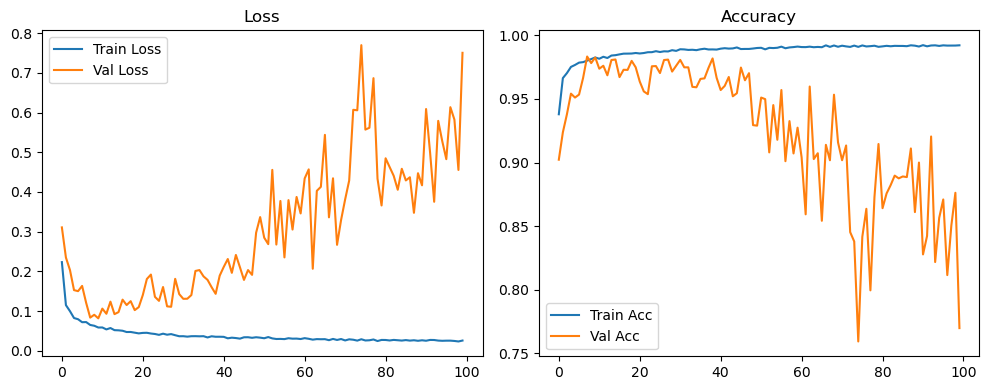

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1040, Acc: 0.9709 | Val Loss: 0.0568, Acc: 0.9826


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9869 | Val Loss: 0.0394, Acc: 0.9871


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.0424, Acc: 0.9872


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0416, Acc: 0.9884


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0403, Acc: 0.9883


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0460, Acc: 0.9880


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0434, Acc: 0.9882


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0373, Acc: 0.9902


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0439, Acc: 0.9884


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0403, Acc: 0.9892


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0458, Acc: 0.9897


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0421, Acc: 0.9898


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0475, Acc: 0.9885


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0448, Acc: 0.9901


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0379, Acc: 0.9920


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0371, Acc: 0.9924


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0452, Acc: 0.9906


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0540, Acc: 0.9887


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0508, Acc: 0.9908


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0438, Acc: 0.9912


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0482, Acc: 0.9906


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0481, Acc: 0.9902


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0561, Acc: 0.9895


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0517, Acc: 0.9900


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0438, Acc: 0.9921


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0446, Acc: 0.9908


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0439, Acc: 0.9910


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0423, Acc: 0.9912


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0463, Acc: 0.9912


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0457, Acc: 0.9911


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0493, Acc: 0.9908


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0509, Acc: 0.9903


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0394, Acc: 0.9928


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0495, Acc: 0.9914


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0503, Acc: 0.9912


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0576, Acc: 0.9912


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.0512, Acc: 0.9914


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0749, Acc: 0.9885


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0543, Acc: 0.9921


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0501, Acc: 0.9912


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9921


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0527, Acc: 0.9922


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0491, Acc: 0.9922


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0537, Acc: 0.9914


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0668, Acc: 0.9906


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0495, Acc: 0.9924


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0499, Acc: 0.9921


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0668, Acc: 0.9910


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0585, Acc: 0.9917


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0626, Acc: 0.9904


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0571, Acc: 0.9909


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0490, Acc: 0.9918


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0492, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0491, Acc: 0.9931


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9931


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9920


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9928


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0518, Acc: 0.9922


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9922


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0534, Acc: 0.9924


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9925


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9921


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0536, Acc: 0.9928


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0537, Acc: 0.9922


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9927


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0541, Acc: 0.9924


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9927


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9926


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9928


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0584, Acc: 0.9922


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9920


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9920


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0634, Acc: 0.9921


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0666, Acc: 0.9917


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9924


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9928


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9926


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0611, Acc: 0.9922


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0568, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9928


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9929


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9930


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9927


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0589, Acc: 0.9924


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9926


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9926


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0583, Acc: 0.9930


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9932


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9929


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0604, Acc: 0.9928


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9927


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9925


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0589, Acc: 0.9925


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0623, Acc: 0.9930


Final Test Loss: 0.0587 Accuracy: 0.9916


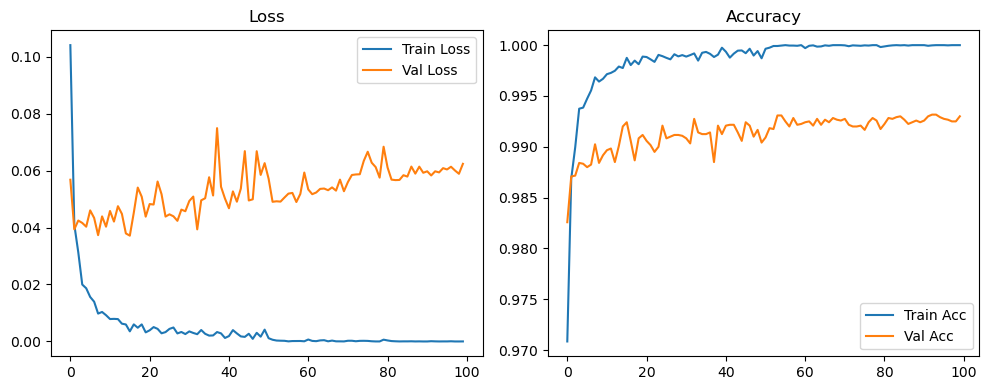

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1303, Acc: 0.9650 | Val Loss: 0.0876, Acc: 0.9712


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9818 | Val Loss: 0.0637, Acc: 0.9807


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0562, Acc: 0.9831


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.0537, Acc: 0.9824


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0576, Acc: 0.9822


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0541, Acc: 0.9830


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.0510, Acc: 0.9841


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0395, Acc: 0.9883


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0390, Acc: 0.9882


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0375, Acc: 0.9884


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0335, Acc: 0.9912


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0339, Acc: 0.9902


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0314, Acc: 0.9901


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0317, Acc: 0.9907


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0320, Acc: 0.9902


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0403, Acc: 0.9879


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9948 | Val Loss: 0.0455, Acc: 0.9865


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0387, Acc: 0.9892


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0369, Acc: 0.9894


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.0368, Acc: 0.9893


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0392, Acc: 0.9889


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0394, Acc: 0.9885


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0335, Acc: 0.9910


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0347, Acc: 0.9905


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.0408, Acc: 0.9883


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0328, Acc: 0.9912


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0332, Acc: 0.9906


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0309, Acc: 0.9912


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0385, Acc: 0.9896


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0348, Acc: 0.9899


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0306, Acc: 0.9918


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0386, Acc: 0.9897


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0367, Acc: 0.9892


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0346, Acc: 0.9899


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0335, Acc: 0.9905


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0332, Acc: 0.9907


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0339, Acc: 0.9906


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0349, Acc: 0.9904


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0361, Acc: 0.9901


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0350, Acc: 0.9902


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0313, Acc: 0.9909


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0391, Acc: 0.9902


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0350, Acc: 0.9905


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0390, Acc: 0.9899


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0325, Acc: 0.9909


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0331, Acc: 0.9912


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0350, Acc: 0.9911


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0345, Acc: 0.9908


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0333, Acc: 0.9913


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0356, Acc: 0.9916


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0289, Acc: 0.9927


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0264, Acc: 0.9935


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0259, Acc: 0.9931


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0303, Acc: 0.9924


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0293, Acc: 0.9928


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0271, Acc: 0.9926


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0280, Acc: 0.9929


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0294, Acc: 0.9925


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0314, Acc: 0.9932


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0289, Acc: 0.9928


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0276, Acc: 0.9927


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0321, Acc: 0.9922


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0320, Acc: 0.9927


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0297, Acc: 0.9928


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0328, Acc: 0.9918


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0305, Acc: 0.9925


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0293, Acc: 0.9926


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0284, Acc: 0.9925


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0328, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0304, Acc: 0.9929


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0292, Acc: 0.9927


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0307, Acc: 0.9927


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0309, Acc: 0.9918


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0334, Acc: 0.9911


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0301, Acc: 0.9924


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0316, Acc: 0.9914


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0308, Acc: 0.9912


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0278, Acc: 0.9929


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0310, Acc: 0.9918


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0280, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0260, Acc: 0.9935


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0294, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0271, Acc: 0.9938


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0291, Acc: 0.9929


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0263, Acc: 0.9935


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0277, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0269, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0276, Acc: 0.9932


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0278, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0261, Acc: 0.9932


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0263, Acc: 0.9936


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0266, Acc: 0.9932


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0253, Acc: 0.9936


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0260, Acc: 0.9935


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0286, Acc: 0.9924


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0272, Acc: 0.9929


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0283, Acc: 0.9929


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0276, Acc: 0.9924


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0286, Acc: 0.9927


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0304, Acc: 0.9925


Final Test Loss: 0.0271 Accuracy: 0.9922


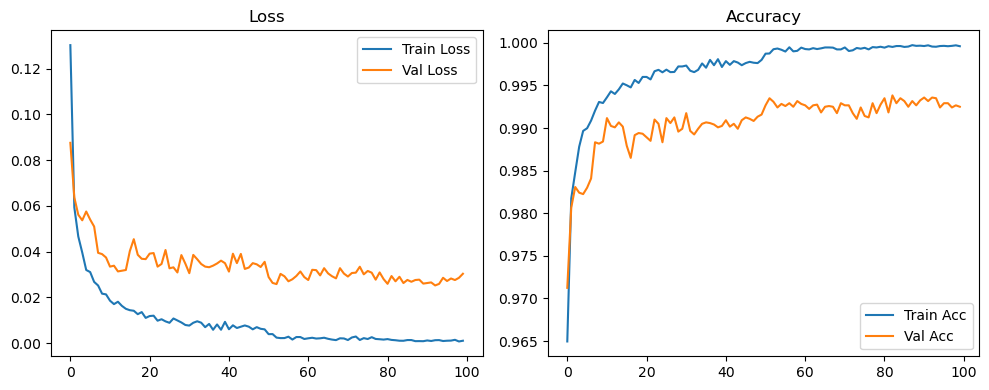

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2222, Acc: 0.9389 | Val Loss: 0.4101, Acc: 0.8592


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1148, Acc: 0.9668 | Val Loss: 0.2722, Acc: 0.9093


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0981, Acc: 0.9715 | Val Loss: 0.2066, Acc: 0.9381


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0824, Acc: 0.9750 | Val Loss: 0.1742, Acc: 0.9468


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9761 | Val Loss: 0.1104, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9787 | Val Loss: 0.1144, Acc: 0.9713


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9776 | Val Loss: 0.1397, Acc: 0.9619


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9799 | Val Loss: 0.1091, Acc: 0.9742


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9814 | Val Loss: 0.1037, Acc: 0.9728


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9820 | Val Loss: 0.0927, Acc: 0.9768


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9823 | Val Loss: 0.0900, Acc: 0.9795


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9841 | Val Loss: 0.1079, Acc: 0.9704


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9832 | Val Loss: 0.1014, Acc: 0.9752


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9845 | Val Loss: 0.0845, Acc: 0.9802


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9848 | Val Loss: 0.0832, Acc: 0.9825


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9842 | Val Loss: 0.1302, Acc: 0.9694


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9854 | Val Loss: 0.0974, Acc: 0.9801


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9850 | Val Loss: 0.1208, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9851 | Val Loss: 0.0993, Acc: 0.9808


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.0987, Acc: 0.9748


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 0.1218, Acc: 0.9682


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9864 | Val Loss: 0.0903, Acc: 0.9817


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.1149, Acc: 0.9706


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9869 | Val Loss: 0.0956, Acc: 0.9860


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9873 | Val Loss: 0.1179, Acc: 0.9723


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.1171, Acc: 0.9717


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9864 | Val Loss: 0.1077, Acc: 0.9802


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9869 | Val Loss: 0.1191, Acc: 0.9731


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9877 | Val Loss: 0.1215, Acc: 0.9782


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9875 | Val Loss: 0.1089, Acc: 0.9786


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.0774, Acc: 0.9866


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9885 | Val Loss: 0.1356, Acc: 0.9757


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.1204, Acc: 0.9815


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9884 | Val Loss: 0.1880, Acc: 0.9618


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.1674, Acc: 0.9712


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.1207, Acc: 0.9708


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9901 | Val Loss: 0.1336, Acc: 0.9680


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.1946, Acc: 0.9695


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9893 | Val Loss: 0.1865, Acc: 0.9702


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.1515, Acc: 0.9691


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.1704, Acc: 0.9639


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.2120, Acc: 0.9487


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.1614, Acc: 0.9648


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9892 | Val Loss: 0.1913, Acc: 0.9625


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.2210, Acc: 0.9600


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 0.2249, Acc: 0.9581


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9897 | Val Loss: 0.2313, Acc: 0.9543


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.1277, Acc: 0.9723


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.2229, Acc: 0.9553


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.2890, Acc: 0.9433


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.2570, Acc: 0.9539


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.2025, Acc: 0.9596


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.2629, Acc: 0.9484


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.2026, Acc: 0.9557


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.2511, Acc: 0.9497


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.2086, Acc: 0.9632


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.2387, Acc: 0.9397


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.1837, Acc: 0.9641


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.2205, Acc: 0.9490


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.2515, Acc: 0.9454


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9927 | Val Loss: 0.2500, Acc: 0.9444


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9929 | Val Loss: 0.2944, Acc: 0.9292


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.2254, Acc: 0.9480


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.2813, Acc: 0.9352


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1881, Acc: 0.9604


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1994, Acc: 0.9595


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1769, Acc: 0.9602


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.1871, Acc: 0.9567


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9936 | Val Loss: 0.2706, Acc: 0.9311


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.2438, Acc: 0.9473


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.2484, Acc: 0.9463


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.2112, Acc: 0.9577


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.2216, Acc: 0.9498


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.2580, Acc: 0.9443


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.3342, Acc: 0.9204


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.2799, Acc: 0.9423


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.2423, Acc: 0.9448


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.3110, Acc: 0.9243


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.3202, Acc: 0.9048


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.2399, Acc: 0.9505


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.2346, Acc: 0.9545


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.2317, Acc: 0.9523


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9943 | Val Loss: 0.2627, Acc: 0.9446


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.2979, Acc: 0.9181


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.2819, Acc: 0.9391


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.3375, Acc: 0.9226


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.3109, Acc: 0.9237


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.2968, Acc: 0.9221


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.2803, Acc: 0.9283


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.3068, Acc: 0.9241


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.3060, Acc: 0.9219


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.2827, Acc: 0.9233


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.2746, Acc: 0.9334


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.2511, Acc: 0.9411


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.3023, Acc: 0.9253


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.2925, Acc: 0.9213


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.2729, Acc: 0.9312


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.2942, Acc: 0.9336


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.3010, Acc: 0.9258


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.3730, Acc: 0.8998


Final Test Loss: 0.3689 Accuracy: 0.9034


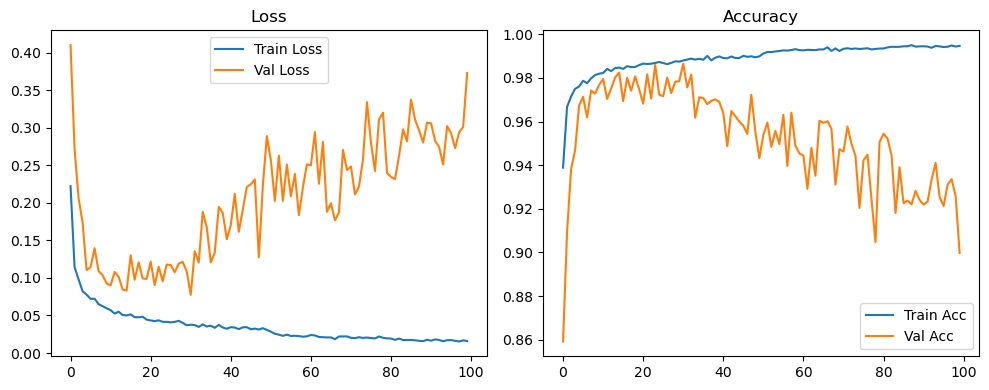

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1184, Acc: 0.9734 | Val Loss: 0.0557, Acc: 0.9832


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9883 | Val Loss: 0.0351, Acc: 0.9894


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9917 | Val Loss: 0.0335, Acc: 0.9897


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9942 | Val Loss: 0.0347, Acc: 0.9898


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0370, Acc: 0.9888


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0384, Acc: 0.9897


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0395, Acc: 0.9883


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0322, Acc: 0.9907


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0381, Acc: 0.9898


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0315, Acc: 0.9904


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0502, Acc: 0.9864


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0336, Acc: 0.9910


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0390, Acc: 0.9892


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0359, Acc: 0.9905


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0321, Acc: 0.9926


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0360, Acc: 0.9909


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0310, Acc: 0.9918


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0389, Acc: 0.9909


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0360, Acc: 0.9902


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0495, Acc: 0.9877


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0366, Acc: 0.9925


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0349, Acc: 0.9922


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0363, Acc: 0.9918


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0416, Acc: 0.9911


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0392, Acc: 0.9916


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0381, Acc: 0.9918


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0502, Acc: 0.9881


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0453, Acc: 0.9908


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0426, Acc: 0.9922


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0440, Acc: 0.9902


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0381, Acc: 0.9921


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0398, Acc: 0.9916


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0560, Acc: 0.9894


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0481, Acc: 0.9907


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0475, Acc: 0.9913


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0395, Acc: 0.9921


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0410, Acc: 0.9919


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0457, Acc: 0.9923


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0440, Acc: 0.9917


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0407, Acc: 0.9924


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0397, Acc: 0.9922


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0430, Acc: 0.9922


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0496, Acc: 0.9903


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.0399, Acc: 0.9923


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0588, Acc: 0.9902


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0474, Acc: 0.9908


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0427, Acc: 0.9928


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0516, Acc: 0.9910


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0455, Acc: 0.9912


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0435, Acc: 0.9920


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0568, Acc: 0.9908


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9918


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0464, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0470, Acc: 0.9910


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0445, Acc: 0.9925


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0487, Acc: 0.9919


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0467, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0474, Acc: 0.9918


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0468, Acc: 0.9923


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0494, Acc: 0.9916


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0452, Acc: 0.9924


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0540, Acc: 0.9913


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0509, Acc: 0.9910


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0484, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0532, Acc: 0.9922


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0543, Acc: 0.9904


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0513, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0539, Acc: 0.9920


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0494, Acc: 0.9923


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0493, Acc: 0.9928


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0518, Acc: 0.9917


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0507, Acc: 0.9923


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.0545, Acc: 0.9913


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0550, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0537, Acc: 0.9919


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0559, Acc: 0.9922


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0505, Acc: 0.9918


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0500, Acc: 0.9917


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0567, Acc: 0.9911


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0499, Acc: 0.9909


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0583, Acc: 0.9908


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0574, Acc: 0.9912


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0554, Acc: 0.9920


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0536, Acc: 0.9909


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0499, Acc: 0.9917


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0573, Acc: 0.9912


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0543, Acc: 0.9912


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0526, Acc: 0.9914


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0553, Acc: 0.9910


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0596, Acc: 0.9915


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0649, Acc: 0.9903


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0550, Acc: 0.9913


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0567, Acc: 0.9912


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0620, Acc: 0.9904


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0655, Acc: 0.9902


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0592, Acc: 0.9914


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0580, Acc: 0.9918


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0493, Acc: 0.9926


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0467, Acc: 0.9932


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0538, Acc: 0.9921


Final Test Loss: 0.0528 Accuracy: 0.9920


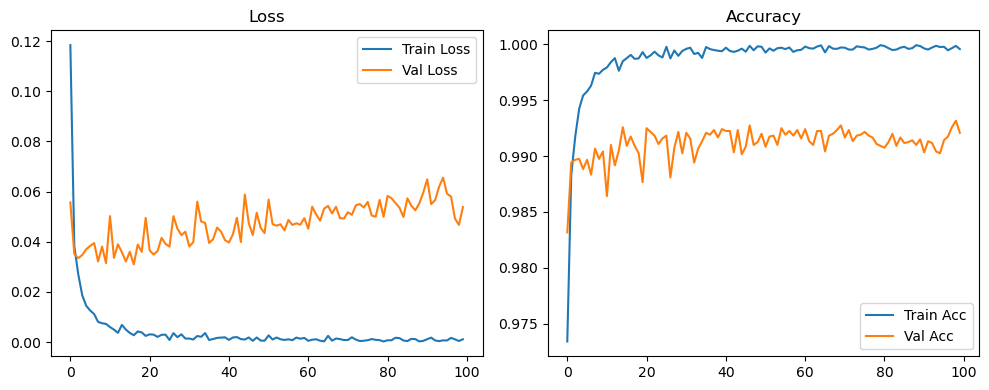

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1438, Acc: 0.9671 | Val Loss: 0.0899, Acc: 0.9723


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9835 | Val Loss: 0.0669, Acc: 0.9802


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9869 | Val Loss: 0.0580, Acc: 0.9819


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9898 | Val Loss: 0.0456, Acc: 0.9853


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0400, Acc: 0.9869


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.0462, Acc: 0.9859


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0385, Acc: 0.9883


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0304, Acc: 0.9909


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0302, Acc: 0.9910


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0311, Acc: 0.9899


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0350, Acc: 0.9895


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.0340, Acc: 0.9891


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0352, Acc: 0.9898


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0305, Acc: 0.9916


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0277, Acc: 0.9918


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0392, Acc: 0.9885


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0446, Acc: 0.9866


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0314, Acc: 0.9909


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0300, Acc: 0.9913


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.0328, Acc: 0.9905


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0286, Acc: 0.9918


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0314, Acc: 0.9907


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0334, Acc: 0.9919


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0304, Acc: 0.9919


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0336, Acc: 0.9907


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0291, Acc: 0.9915


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0299, Acc: 0.9923


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0383, Acc: 0.9902


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0351, Acc: 0.9906


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.0349, Acc: 0.9905


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0314, Acc: 0.9913


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0261, Acc: 0.9933


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0296, Acc: 0.9921


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0359, Acc: 0.9902


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0349, Acc: 0.9918


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0289, Acc: 0.9917


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0323, Acc: 0.9918


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0300, Acc: 0.9920


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0316, Acc: 0.9923


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0314, Acc: 0.9912


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0311, Acc: 0.9917


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0306, Acc: 0.9910


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0344, Acc: 0.9909


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0341, Acc: 0.9902


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0343, Acc: 0.9915


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0262, Acc: 0.9933


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0340, Acc: 0.9914


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0325, Acc: 0.9917


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0334, Acc: 0.9908


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0353, Acc: 0.9908


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0347, Acc: 0.9914


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0258, Acc: 0.9928


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0333, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.0321, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0336, Acc: 0.9916


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9986 | Val Loss: 0.0292, Acc: 0.9928


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0315, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0304, Acc: 0.9918


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0317, Acc: 0.9917


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0300, Acc: 0.9928


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0333, Acc: 0.9914


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0331, Acc: 0.9908


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0247, Acc: 0.9938


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0297, Acc: 0.9921


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0354, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0263, Acc: 0.9923


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0295, Acc: 0.9931


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0305, Acc: 0.9920


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0268, Acc: 0.9928


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0301, Acc: 0.9916


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0328, Acc: 0.9910


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0322, Acc: 0.9919


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0316, Acc: 0.9916


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0325, Acc: 0.9913


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0288, Acc: 0.9922


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0317, Acc: 0.9916


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0307, Acc: 0.9926


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0300, Acc: 0.9927


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0315, Acc: 0.9918


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0288, Acc: 0.9922


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0269, Acc: 0.9928


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0290, Acc: 0.9931


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0310, Acc: 0.9922


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0305, Acc: 0.9920


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0303, Acc: 0.9926


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0329, Acc: 0.9912


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0332, Acc: 0.9921


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0337, Acc: 0.9920


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0358, Acc: 0.9911


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0325, Acc: 0.9916


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0326, Acc: 0.9912


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0310, Acc: 0.9921


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0288, Acc: 0.9923


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0316, Acc: 0.9908


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0359, Acc: 0.9898


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0315, Acc: 0.9913


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0305, Acc: 0.9908


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0322, Acc: 0.9922


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0277, Acc: 0.9924


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0335, Acc: 0.9913


Final Test Loss: 0.0335 Accuracy: 0.9892


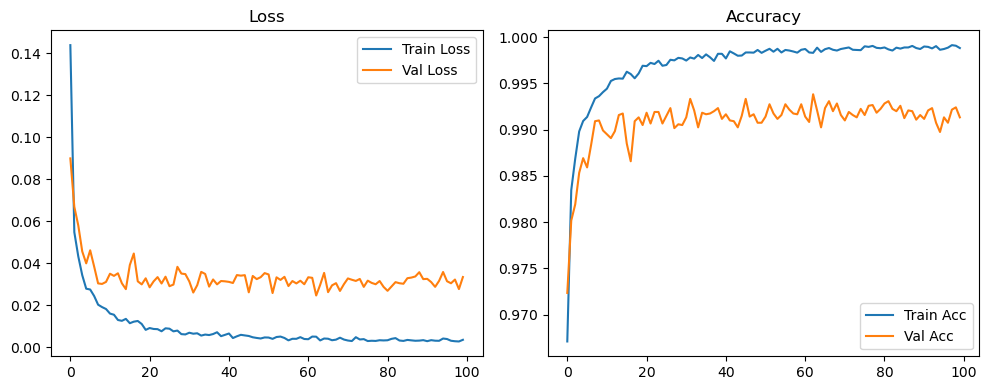

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2470, Acc: 0.9391 | Val Loss: 0.2794, Acc: 0.9212


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1123, Acc: 0.9669 | Val Loss: 0.2903, Acc: 0.8982


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0965, Acc: 0.9718 | Val Loss: 0.1995, Acc: 0.9400


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0806, Acc: 0.9755 | Val Loss: 0.1471, Acc: 0.9573


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9779 | Val Loss: 0.0886, Acc: 0.9778


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0706, Acc: 0.9787 | Val Loss: 0.1018, Acc: 0.9740


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0678, Acc: 0.9794 | Val Loss: 0.0922, Acc: 0.9778


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9816 | Val Loss: 0.0891, Acc: 0.9763


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9822 | Val Loss: 0.1189, Acc: 0.9673


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9839 | Val Loss: 0.0741, Acc: 0.9819


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9834 | Val Loss: 0.0726, Acc: 0.9842


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9845 | Val Loss: 0.0703, Acc: 0.9822


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9838 | Val Loss: 0.0697, Acc: 0.9840


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9857 | Val Loss: 0.0652, Acc: 0.9858


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9858 | Val Loss: 0.0828, Acc: 0.9805


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9856 | Val Loss: 0.0819, Acc: 0.9798


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0762, Acc: 0.9828


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 0.0822, Acc: 0.9855


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9862 | Val Loss: 0.0805, Acc: 0.9828


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9875 | Val Loss: 0.0878, Acc: 0.9819


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9877 | Val Loss: 0.1033, Acc: 0.9737


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9870 | Val Loss: 0.1098, Acc: 0.9781


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.1177, Acc: 0.9706


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.1007, Acc: 0.9828


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0875, Acc: 0.9794


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.1026, Acc: 0.9776


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9887 | Val Loss: 0.0927, Acc: 0.9815


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9892 | Val Loss: 0.1067, Acc: 0.9769


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.1384, Acc: 0.9685


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9895 | Val Loss: 0.1099, Acc: 0.9778


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.1063, Acc: 0.9804


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.1134, Acc: 0.9784


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9891 | Val Loss: 0.1107, Acc: 0.9808


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.1555, Acc: 0.9714


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9890 | Val Loss: 0.1673, Acc: 0.9624


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1374, Acc: 0.9780


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9900 | Val Loss: 0.1377, Acc: 0.9753


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.1066, Acc: 0.9809


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.1403, Acc: 0.9772


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.1530, Acc: 0.9755


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.1457, Acc: 0.9736


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9909 | Val Loss: 0.1577, Acc: 0.9703


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9902 | Val Loss: 0.1646, Acc: 0.9721


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.1506, Acc: 0.9762


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.1621, Acc: 0.9765


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9899 | Val Loss: 0.2073, Acc: 0.9729


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.1618, Acc: 0.9798


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.1436, Acc: 0.9793


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.1776, Acc: 0.9681


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.1815, Acc: 0.9725


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.2114, Acc: 0.9667


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.1763, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.1924, Acc: 0.9748


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.2272, Acc: 0.9526


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1871, Acc: 0.9713


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.2275, Acc: 0.9656


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.2527, Acc: 0.9523


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9920 | Val Loss: 0.1904, Acc: 0.9730


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.2163, Acc: 0.9625


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.2014, Acc: 0.9688


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.2485, Acc: 0.9470


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.2705, Acc: 0.9465


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.2131, Acc: 0.9685


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9915 | Val Loss: 0.3442, Acc: 0.9411


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.2986, Acc: 0.9423


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9909 | Val Loss: 0.1804, Acc: 0.9745


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9929 | Val Loss: 0.2221, Acc: 0.9662


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.2879, Acc: 0.9559


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.1803, Acc: 0.9663


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.2291, Acc: 0.9674


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.3798, Acc: 0.9299


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.2759, Acc: 0.9532


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.2498, Acc: 0.9589


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.2880, Acc: 0.9528


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.3303, Acc: 0.9458


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.2903, Acc: 0.9533


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9931 | Val Loss: 0.3503, Acc: 0.9414


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.3562, Acc: 0.9382


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.2600, Acc: 0.9480


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.3103, Acc: 0.9541


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.5095, Acc: 0.9175


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.4319, Acc: 0.9151


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.4163, Acc: 0.9203


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.4032, Acc: 0.9169


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.3246, Acc: 0.9456


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.4956, Acc: 0.8902


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.4062, Acc: 0.9287


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.3714, Acc: 0.9267


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.3821, Acc: 0.9141


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9923 | Val Loss: 0.4504, Acc: 0.9147


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.3145, Acc: 0.9383


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.4021, Acc: 0.9134


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.3982, Acc: 0.9228


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.4271, Acc: 0.8918


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.4577, Acc: 0.9061


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.4572, Acc: 0.8912


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.4178, Acc: 0.9149


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9929 | Val Loss: 0.5219, Acc: 0.8802


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.4988, Acc: 0.8796


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9930 | Val Loss: 0.5712, Acc: 0.8870


Final Test Loss: 0.5619 Accuracy: 0.8856


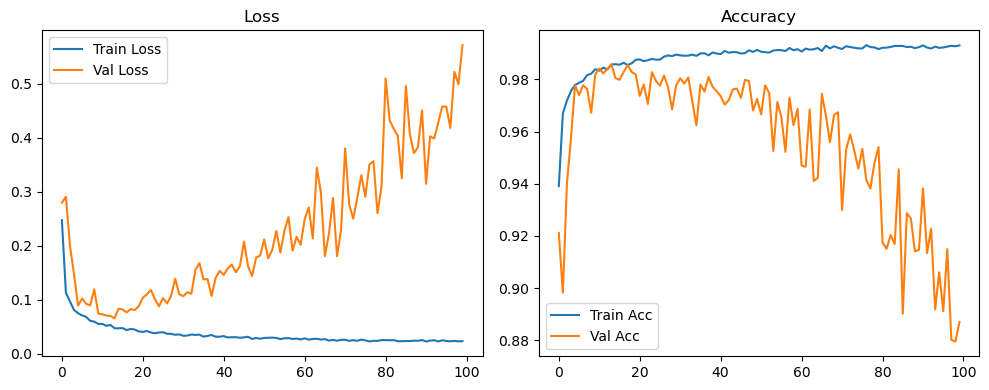

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1478, Acc: 0.9737 | Val Loss: 0.0560, Acc: 0.9836


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9888 | Val Loss: 0.0389, Acc: 0.9886


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9920 | Val Loss: 0.0376, Acc: 0.9882


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9949 | Val Loss: 0.0368, Acc: 0.9887


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9959 | Val Loss: 0.0381, Acc: 0.9882


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0378, Acc: 0.9889


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0389, Acc: 0.9885


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0352, Acc: 0.9896


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0341, Acc: 0.9915


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0316, Acc: 0.9909


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0333, Acc: 0.9908


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0388, Acc: 0.9898


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0381, Acc: 0.9899


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0389, Acc: 0.9902


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0325, Acc: 0.9919


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0355, Acc: 0.9911


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0324, Acc: 0.9920


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0346, Acc: 0.9911


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0376, Acc: 0.9906


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0370, Acc: 0.9912


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0349, Acc: 0.9923


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0369, Acc: 0.9915


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0340, Acc: 0.9917


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0398, Acc: 0.9903


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0303, Acc: 0.9925


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0404, Acc: 0.9913


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0343, Acc: 0.9918


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0357, Acc: 0.9921


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0382, Acc: 0.9923


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0369, Acc: 0.9928


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0374, Acc: 0.9914


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0354, Acc: 0.9920


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0352, Acc: 0.9919


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0357, Acc: 0.9920


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0452, Acc: 0.9907


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0352, Acc: 0.9922


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9924


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0498, Acc: 0.9896


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0449, Acc: 0.9908


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0369, Acc: 0.9923


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0410, Acc: 0.9917


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0368, Acc: 0.9922


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0393, Acc: 0.9922


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0375, Acc: 0.9923


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0371, Acc: 0.9922


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0443, Acc: 0.9906


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0353, Acc: 0.9929


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9928


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0471, Acc: 0.9914


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9925


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0369, Acc: 0.9930


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0372, Acc: 0.9930


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0390, Acc: 0.9924


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0402, Acc: 0.9918


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0440, Acc: 0.9918


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0391, Acc: 0.9922


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0427, Acc: 0.9919


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9911


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0405, Acc: 0.9925


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0427, Acc: 0.9923


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0437, Acc: 0.9912


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0417, Acc: 0.9922


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0448, Acc: 0.9914


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9916


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0500, Acc: 0.9904


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0448, Acc: 0.9908


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0434, Acc: 0.9918


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0397, Acc: 0.9929


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0443, Acc: 0.9911


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0427, Acc: 0.9919


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0409, Acc: 0.9922


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0392, Acc: 0.9931


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9937


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0448, Acc: 0.9921


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0495, Acc: 0.9912


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0406, Acc: 0.9925


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9924


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9927


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0417, Acc: 0.9914


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0430, Acc: 0.9924


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0439, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0445, Acc: 0.9920


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0413, Acc: 0.9920


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0410, Acc: 0.9929


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9933


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9925


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0436, Acc: 0.9933


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0426, Acc: 0.9931


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9929


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0444, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0383, Acc: 0.9931


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0462, Acc: 0.9933


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0458, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0409, Acc: 0.9934


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0407, Acc: 0.9927


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0446, Acc: 0.9924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0454, Acc: 0.9928


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0419, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0436, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0425, Acc: 0.9932


Final Test Loss: 0.0421 Accuracy: 0.9930


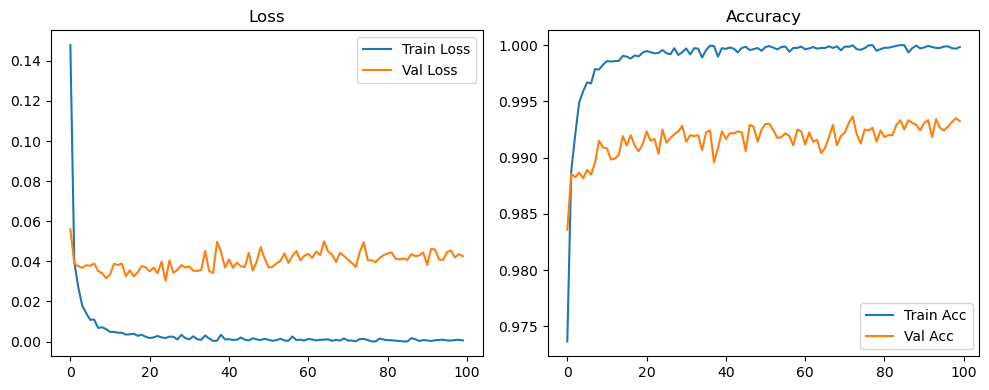

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1786, Acc: 0.9665 | Val Loss: 0.0948, Acc: 0.9755


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9840 | Val Loss: 0.0758, Acc: 0.9775


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9870 | Val Loss: 0.0526, Acc: 0.9849


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9891 | Val Loss: 0.0500, Acc: 0.9840


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9914 | Val Loss: 0.0410, Acc: 0.9872


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9920 | Val Loss: 0.0406, Acc: 0.9877


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.0413, Acc: 0.9866


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0345, Acc: 0.9894


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0324, Acc: 0.9898


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0291, Acc: 0.9909


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0320, Acc: 0.9901


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0340, Acc: 0.9894


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0334, Acc: 0.9908


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0282, Acc: 0.9917


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0275, Acc: 0.9926


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0290, Acc: 0.9913


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0341, Acc: 0.9908


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0333, Acc: 0.9908


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0285, Acc: 0.9917


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0287, Acc: 0.9920


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.0301, Acc: 0.9914


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0347, Acc: 0.9914


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0283, Acc: 0.9922


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0340, Acc: 0.9911


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0307, Acc: 0.9917


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0281, Acc: 0.9913


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0292, Acc: 0.9922


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0317, Acc: 0.9906


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0282, Acc: 0.9920


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0287, Acc: 0.9918


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0296, Acc: 0.9913


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0283, Acc: 0.9925


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0324, Acc: 0.9903


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0304, Acc: 0.9912


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0328, Acc: 0.9922


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0246, Acc: 0.9932


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0347, Acc: 0.9901


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0301, Acc: 0.9917


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0298, Acc: 0.9920


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9978 | Val Loss: 0.0336, Acc: 0.9905


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0309, Acc: 0.9918


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0302, Acc: 0.9912


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0331, Acc: 0.9917


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0280, Acc: 0.9928


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0263, Acc: 0.9935


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0265, Acc: 0.9925


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0299, Acc: 0.9922


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0310, Acc: 0.9912


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0286, Acc: 0.9924


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0294, Acc: 0.9920


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0352, Acc: 0.9902


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0315, Acc: 0.9910


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0280, Acc: 0.9922


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0277, Acc: 0.9919


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0294, Acc: 0.9925


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.0308, Acc: 0.9919


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0323, Acc: 0.9908


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0292, Acc: 0.9914


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0298, Acc: 0.9922


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0320, Acc: 0.9917


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0262, Acc: 0.9929


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0332, Acc: 0.9911


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0293, Acc: 0.9924


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0284, Acc: 0.9924


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0299, Acc: 0.9925


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0305, Acc: 0.9917


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0302, Acc: 0.9915


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0302, Acc: 0.9912


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0320, Acc: 0.9908


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0294, Acc: 0.9916


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0321, Acc: 0.9914


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0299, Acc: 0.9923


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0313, Acc: 0.9913


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0312, Acc: 0.9922


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0298, Acc: 0.9921


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0280, Acc: 0.9927


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0255, Acc: 0.9932


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0235, Acc: 0.9935


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0270, Acc: 0.9923


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0288, Acc: 0.9925


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0281, Acc: 0.9924


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0328, Acc: 0.9919


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0268, Acc: 0.9927


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0283, Acc: 0.9924


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0307, Acc: 0.9922


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0303, Acc: 0.9925


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0311, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0305, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0291, Acc: 0.9928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0288, Acc: 0.9923


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0307, Acc: 0.9916


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0363, Acc: 0.9902


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0306, Acc: 0.9916


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0350, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0349, Acc: 0.9913


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0315, Acc: 0.9925


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0304, Acc: 0.9922


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0284, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0300, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0296, Acc: 0.9918


Final Test Loss: 0.0279 Accuracy: 0.9911


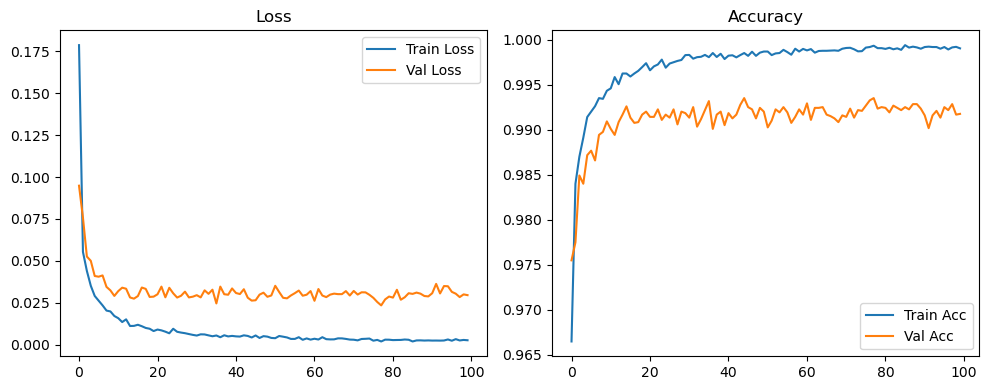

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2975, Acc: 0.9358 | Val Loss: 0.3377, Acc: 0.9041


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1180, Acc: 0.9673 | Val Loss: 0.3174, Acc: 0.8863


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0982, Acc: 0.9712 | Val Loss: 0.1715, Acc: 0.9543


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0831, Acc: 0.9751 | Val Loss: 0.1218, Acc: 0.9675


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0777, Acc: 0.9774 | Val Loss: 0.1313, Acc: 0.9618


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0723, Acc: 0.9785 | Val Loss: 0.1339, Acc: 0.9615


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0665, Acc: 0.9798 | Val Loss: 0.1177, Acc: 0.9703


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9815 | Val Loss: 0.0901, Acc: 0.9775


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0602, Acc: 0.9817 | Val Loss: 0.1104, Acc: 0.9712


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9836 | Val Loss: 0.0791, Acc: 0.9808


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9833 | Val Loss: 0.0730, Acc: 0.9832


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9847 | Val Loss: 0.0652, Acc: 0.9842


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9842 | Val Loss: 0.0854, Acc: 0.9793


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.0748, Acc: 0.9850


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9858 | Val Loss: 0.0787, Acc: 0.9834


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9860 | Val Loss: 0.0723, Acc: 0.9850


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9868 | Val Loss: 0.0937, Acc: 0.9798


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9869 | Val Loss: 0.0846, Acc: 0.9821


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9863 | Val Loss: 0.0740, Acc: 0.9828


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.0835, Acc: 0.9832


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9880 | Val Loss: 0.0778, Acc: 0.9832


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.0849, Acc: 0.9819


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9877 | Val Loss: 0.0871, Acc: 0.9794


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9887 | Val Loss: 0.0849, Acc: 0.9862


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9887 | Val Loss: 0.0859, Acc: 0.9804


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.0963, Acc: 0.9780


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.0817, Acc: 0.9835


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.0864, Acc: 0.9823


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9897 | Val Loss: 0.1043, Acc: 0.9785


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.1126, Acc: 0.9777


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9900 | Val Loss: 0.0939, Acc: 0.9849


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.1021, Acc: 0.9825


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.1273, Acc: 0.9804


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9892 | Val Loss: 0.1239, Acc: 0.9800


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.1421, Acc: 0.9751


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1395, Acc: 0.9751


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.1452, Acc: 0.9698


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.1398, Acc: 0.9783


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.1355, Acc: 0.9790


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.1577, Acc: 0.9729


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9909 | Val Loss: 0.1594, Acc: 0.9742


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.1635, Acc: 0.9743


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.1491, Acc: 0.9766


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.1440, Acc: 0.9781


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.1245, Acc: 0.9794


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.1456, Acc: 0.9796


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.1740, Acc: 0.9740


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.1786, Acc: 0.9741


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.1987, Acc: 0.9718


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.1814, Acc: 0.9735


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.2138, Acc: 0.9665


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.2048, Acc: 0.9690


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.2361, Acc: 0.9706


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.2091, Acc: 0.9674


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.2212, Acc: 0.9705


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9914 | Val Loss: 0.2125, Acc: 0.9736


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.1961, Acc: 0.9736


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.1742, Acc: 0.9749


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.1815, Acc: 0.9704


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.1779, Acc: 0.9731


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.2379, Acc: 0.9653


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9919 | Val Loss: 0.2221, Acc: 0.9638


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.2071, Acc: 0.9744


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.2610, Acc: 0.9578


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.2297, Acc: 0.9683


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9922 | Val Loss: 0.2316, Acc: 0.9677


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.2229, Acc: 0.9698


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.2491, Acc: 0.9650


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.2332, Acc: 0.9673


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.2468, Acc: 0.9705


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.2514, Acc: 0.9643


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.2421, Acc: 0.9604


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.2923, Acc: 0.9452


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.2766, Acc: 0.9573


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.2957, Acc: 0.9487


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.3451, Acc: 0.9381


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9930 | Val Loss: 0.3410, Acc: 0.9375


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.3515, Acc: 0.9183


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.3323, Acc: 0.9335


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.4652, Acc: 0.9030


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.4405, Acc: 0.9129


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.4572, Acc: 0.9101


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.4060, Acc: 0.9229


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.3742, Acc: 0.9254


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.3942, Acc: 0.9307


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.3893, Acc: 0.9273


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.3646, Acc: 0.9182


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.3825, Acc: 0.9192


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.4531, Acc: 0.8905


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9927 | Val Loss: 0.5082, Acc: 0.8800


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.4171, Acc: 0.9027


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.5306, Acc: 0.8595


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.5246, Acc: 0.8794


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.6005, Acc: 0.8422


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.5128, Acc: 0.8764


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.5640, Acc: 0.8447


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9935 | Val Loss: 0.5319, Acc: 0.8658


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.5649, Acc: 0.8532


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.7185, Acc: 0.8085


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.7353, Acc: 0.7971


Final Test Loss: 0.7255 Accuracy: 0.8032


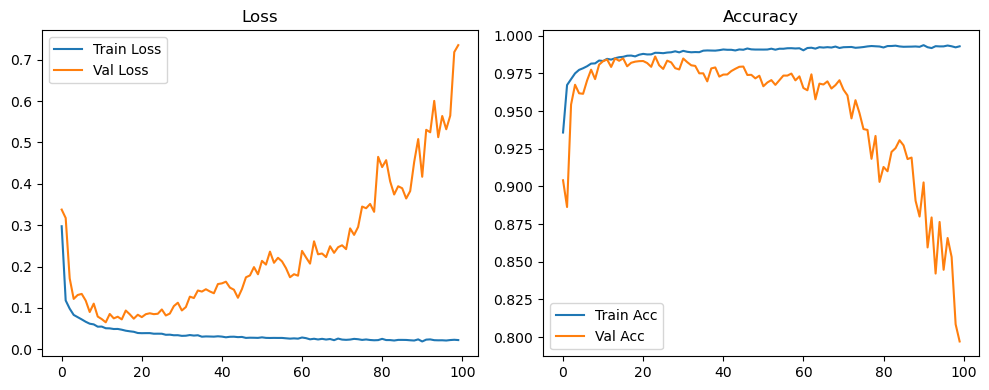

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1102, Acc: 0.9688 | Val Loss: 0.0848, Acc: 0.9728


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.0492, Acc: 0.9842


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0523, Acc: 0.9851


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0480, Acc: 0.9846


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.0375, Acc: 0.9898


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0380, Acc: 0.9903


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0450, Acc: 0.9899


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0443, Acc: 0.9895


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0552, Acc: 0.9867


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.0383, Acc: 0.9906


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0429, Acc: 0.9903


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0630, Acc: 0.9848


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0392, Acc: 0.9919


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0481, Acc: 0.9896


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0460, Acc: 0.9911


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0437, Acc: 0.9906


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0518, Acc: 0.9892


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0646, Acc: 0.9870


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0474, Acc: 0.9908


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0479, Acc: 0.9910


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0416, Acc: 0.9915


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0581, Acc: 0.9887


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0433, Acc: 0.9913


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.0545, Acc: 0.9899


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0432, Acc: 0.9921


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0519, Acc: 0.9913


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0574, Acc: 0.9901


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0458, Acc: 0.9905


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0542, Acc: 0.9908


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0541, Acc: 0.9888


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0609, Acc: 0.9892


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0461, Acc: 0.9918


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0528, Acc: 0.9910


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0606, Acc: 0.9883


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.0544, Acc: 0.9905


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0462, Acc: 0.9924


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0547, Acc: 0.9908


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0565, Acc: 0.9916


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0532, Acc: 0.9913


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0506, Acc: 0.9922


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0514, Acc: 0.9927


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0557, Acc: 0.9920


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.0671, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0506, Acc: 0.9932


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0683, Acc: 0.9897


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0606, Acc: 0.9910


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0677, Acc: 0.9911


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.0671, Acc: 0.9904


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0635, Acc: 0.9913


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0563, Acc: 0.9921


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0716, Acc: 0.9908


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0597, Acc: 0.9922


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0608, Acc: 0.9928


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0572, Acc: 0.9917


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0874, Acc: 0.9900


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.0714, Acc: 0.9911


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0638, Acc: 0.9920


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0564, Acc: 0.9918


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0656, Acc: 0.9913


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0645, Acc: 0.9909


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0692, Acc: 0.9910


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0628, Acc: 0.9908


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0705, Acc: 0.9918


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0547, Acc: 0.9927


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0552, Acc: 0.9927


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0641, Acc: 0.9923


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0690, Acc: 0.9895


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0526, Acc: 0.9921


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0588, Acc: 0.9929


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0636, Acc: 0.9922


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0695, Acc: 0.9920


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0756, Acc: 0.9901


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0609, Acc: 0.9928


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0626, Acc: 0.9922


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0600, Acc: 0.9928


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0608, Acc: 0.9929


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0687, Acc: 0.9909


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0746, Acc: 0.9908


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0623, Acc: 0.9926


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0707, Acc: 0.9917


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0682, Acc: 0.9920


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0703, Acc: 0.9921


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0718, Acc: 0.9916


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0670, Acc: 0.9921


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0676, Acc: 0.9924


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0668, Acc: 0.9921


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0701, Acc: 0.9917


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0641, Acc: 0.9921


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0680, Acc: 0.9922


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0676, Acc: 0.9932


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0911, Acc: 0.9905


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.0894, Acc: 0.9912


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0747, Acc: 0.9918


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0766, Acc: 0.9920


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0747, Acc: 0.9918


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9995 | Val Loss: 0.0795, Acc: 0.9915


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0898, Acc: 0.9926


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0760, Acc: 0.9918


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0731, Acc: 0.9922


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0800, Acc: 0.9924


Final Test Loss: 0.0833 Accuracy: 0.9909


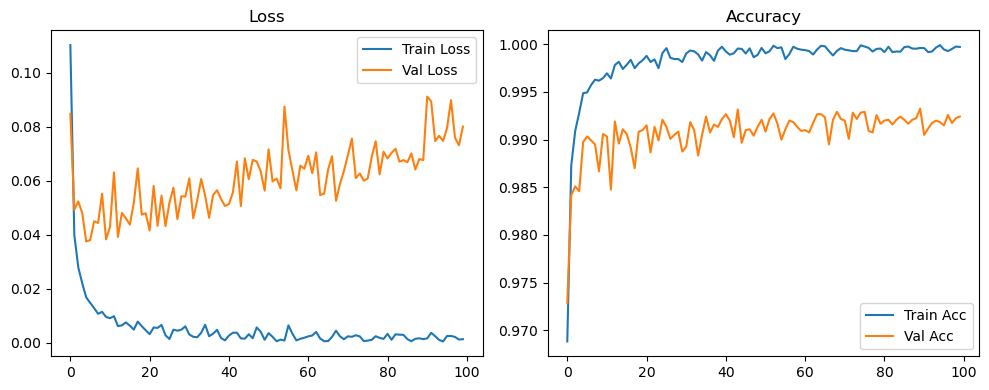

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1371, Acc: 0.9617 | Val Loss: 0.1115, Acc: 0.9656


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9818 | Val Loss: 0.0604, Acc: 0.9802


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9859 | Val Loss: 0.0638, Acc: 0.9803


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9879 | Val Loss: 0.0511, Acc: 0.9832


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 0.0395, Acc: 0.9875


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0448, Acc: 0.9857


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0505, Acc: 0.9857


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0387, Acc: 0.9880


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.0369, Acc: 0.9886


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0411, Acc: 0.9879


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0441, Acc: 0.9870


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0356, Acc: 0.9884


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0350, Acc: 0.9885


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.0355, Acc: 0.9893


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0307, Acc: 0.9908


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0405, Acc: 0.9882


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0337, Acc: 0.9902


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0603, Acc: 0.9842


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9953 | Val Loss: 0.0368, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0406, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0397, Acc: 0.9887


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0393, Acc: 0.9898


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0327, Acc: 0.9907


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0302, Acc: 0.9912


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0369, Acc: 0.9905


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0331, Acc: 0.9913


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0341, Acc: 0.9907


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0390, Acc: 0.9899


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0351, Acc: 0.9899


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0360, Acc: 0.9908


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0395, Acc: 0.9895


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.0446, Acc: 0.9894


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0418, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0381, Acc: 0.9903


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0417, Acc: 0.9898


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0461, Acc: 0.9896


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0417, Acc: 0.9890


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0355, Acc: 0.9895


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0388, Acc: 0.9922


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0409, Acc: 0.9892


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0371, Acc: 0.9898


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0356, Acc: 0.9906


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0344, Acc: 0.9904


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0327, Acc: 0.9916


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0351, Acc: 0.9907


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0370, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0338, Acc: 0.9916


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0318, Acc: 0.9918


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0411, Acc: 0.9900


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0343, Acc: 0.9913


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0369, Acc: 0.9904


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0296, Acc: 0.9921


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0335, Acc: 0.9907


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0346, Acc: 0.9912


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0355, Acc: 0.9908


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0338, Acc: 0.9915


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0394, Acc: 0.9894


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0422, Acc: 0.9897


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0350, Acc: 0.9902


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0347, Acc: 0.9903


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0365, Acc: 0.9908


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0455, Acc: 0.9891


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0358, Acc: 0.9908


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0299, Acc: 0.9924


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0373, Acc: 0.9908


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0373, Acc: 0.9915


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0393, Acc: 0.9912


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0414, Acc: 0.9902


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0325, Acc: 0.9912


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0345, Acc: 0.9912


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0340, Acc: 0.9918


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0346, Acc: 0.9908


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0378, Acc: 0.9905


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0346, Acc: 0.9918


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.0387, Acc: 0.9916


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0404, Acc: 0.9908


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0427, Acc: 0.9906


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0326, Acc: 0.9918


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0336, Acc: 0.9914


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0330, Acc: 0.9918


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0329, Acc: 0.9924


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0313, Acc: 0.9921


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0361, Acc: 0.9905


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0337, Acc: 0.9919


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0328, Acc: 0.9920


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0373, Acc: 0.9904


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0356, Acc: 0.9902


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0388, Acc: 0.9909


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0389, Acc: 0.9906


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0371, Acc: 0.9908


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0339, Acc: 0.9908


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0413, Acc: 0.9904


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0357, Acc: 0.9909


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0447, Acc: 0.9899


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0366, Acc: 0.9913


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0408, Acc: 0.9908


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0490, Acc: 0.9884


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0396, Acc: 0.9899


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0406, Acc: 0.9898


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0388, Acc: 0.9907


Final Test Loss: 0.0393 Accuracy: 0.9896


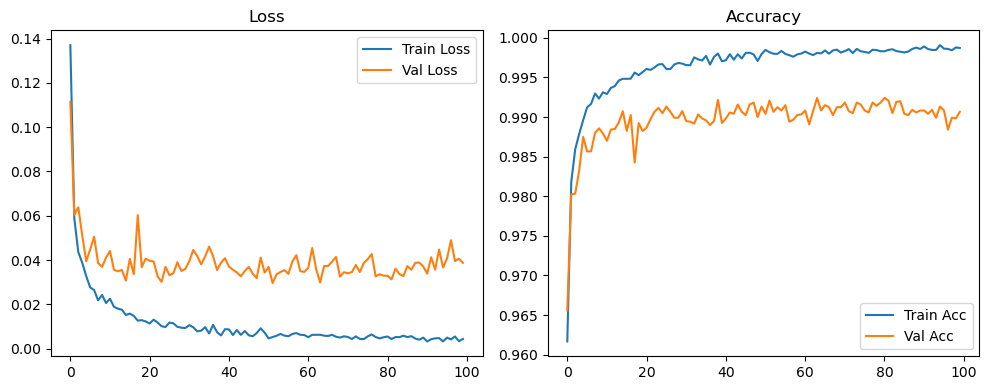

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2322, Acc: 0.9325 | Val Loss: 0.6275, Acc: 0.7824


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9654 | Val Loss: 0.2263, Acc: 0.9401


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9707 | Val Loss: 0.2047, Acc: 0.9450


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9737 | Val Loss: 0.1645, Acc: 0.9570


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9772 | Val Loss: 0.1237, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9773 | Val Loss: 0.1236, Acc: 0.9713


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9791 | Val Loss: 0.1275, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9808 | Val Loss: 0.1269, Acc: 0.9680


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9811 | Val Loss: 0.1246, Acc: 0.9704


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9811 | Val Loss: 0.1295, Acc: 0.9632


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9818 | Val Loss: 0.1199, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9825 | Val Loss: 0.1114, Acc: 0.9778


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9830 | Val Loss: 0.0943, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9830 | Val Loss: 0.0871, Acc: 0.9813


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9848 | Val Loss: 0.0856, Acc: 0.9791


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9837 | Val Loss: 0.0748, Acc: 0.9843


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.1123, Acc: 0.9707


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9847 | Val Loss: 0.0923, Acc: 0.9788


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9848 | Val Loss: 0.0754, Acc: 0.9828


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9863 | Val Loss: 0.0834, Acc: 0.9824


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9866 | Val Loss: 0.0775, Acc: 0.9841


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9859 | Val Loss: 0.0915, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9873 | Val Loss: 0.0921, Acc: 0.9800


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9858 | Val Loss: 0.0997, Acc: 0.9848


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 0.0803, Acc: 0.9853


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9871 | Val Loss: 0.1033, Acc: 0.9775


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9877 | Val Loss: 0.0729, Acc: 0.9854


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.1068, Acc: 0.9746


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.0945, Acc: 0.9765


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.0776, Acc: 0.9843


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.0871, Acc: 0.9842


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9875 | Val Loss: 0.1030, Acc: 0.9777


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9876 | Val Loss: 0.0805, Acc: 0.9850


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.0800, Acc: 0.9810


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.0941, Acc: 0.9784


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.0749, Acc: 0.9832


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9883 | Val Loss: 0.0751, Acc: 0.9848


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.0822, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.0708, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.0593, Acc: 0.9890


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.0991, Acc: 0.9848


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.0670, Acc: 0.9871


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9889 | Val Loss: 0.0697, Acc: 0.9860


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.0945, Acc: 0.9796


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.0840, Acc: 0.9835


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0954, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0652, Acc: 0.9870


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.0811, Acc: 0.9851


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.0796, Acc: 0.9828


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.0807, Acc: 0.9798


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9899 | Val Loss: 0.0809, Acc: 0.9840


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0754, Acc: 0.9849


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.0729, Acc: 0.9841


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9901 | Val Loss: 0.0622, Acc: 0.9888


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.0998, Acc: 0.9771


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.1082, Acc: 0.9819


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.0841, Acc: 0.9838


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.0999, Acc: 0.9847


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.0869, Acc: 0.9858


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9906 | Val Loss: 0.1122, Acc: 0.9748


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.0810, Acc: 0.9848


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.0994, Acc: 0.9788


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0795, Acc: 0.9863


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0935, Acc: 0.9788


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.0778, Acc: 0.9836


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9915 | Val Loss: 0.1333, Acc: 0.9732


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.0972, Acc: 0.9792


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0913, Acc: 0.9783


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.0833, Acc: 0.9833


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0934, Acc: 0.9771


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9909 | Val Loss: 0.1096, Acc: 0.9778


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0942, Acc: 0.9801


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0888, Acc: 0.9828


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0840, Acc: 0.9835


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1158, Acc: 0.9737


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.1014, Acc: 0.9808


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.1018, Acc: 0.9778


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.1102, Acc: 0.9793


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0882, Acc: 0.9816


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0834, Acc: 0.9834


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.0818, Acc: 0.9833


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0928, Acc: 0.9801


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.1169, Acc: 0.9772


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.1139, Acc: 0.9752


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1208, Acc: 0.9751


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1388, Acc: 0.9711


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.0947, Acc: 0.9794


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.1109, Acc: 0.9788


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.1005, Acc: 0.9782


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0758, Acc: 0.9844


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0988, Acc: 0.9772


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0966, Acc: 0.9729


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0835, Acc: 0.9790


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0978, Acc: 0.9752


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0963, Acc: 0.9788


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9925 | Val Loss: 0.1613, Acc: 0.9651


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1163, Acc: 0.9767


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.1411, Acc: 0.9730


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1356, Acc: 0.9712


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0809, Acc: 0.9845


Final Test Loss: 0.0790 Accuracy: 0.9835


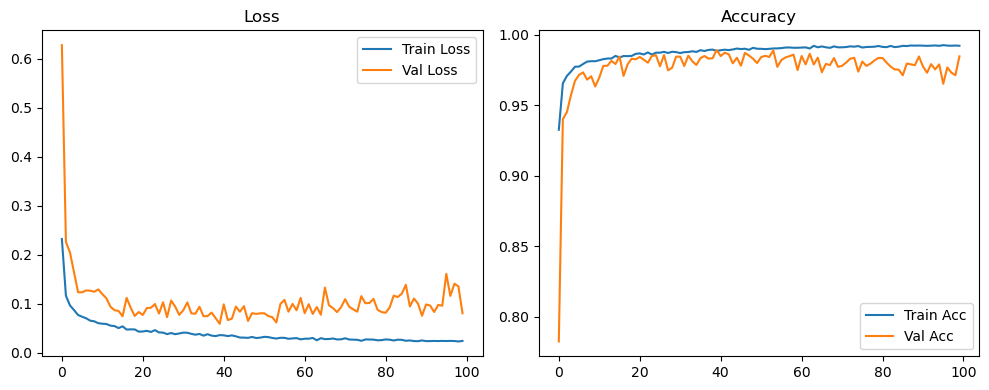

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1093, Acc: 0.9691 | Val Loss: 0.0548, Acc: 0.9824


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9874 | Val Loss: 0.0427, Acc: 0.9863


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.0527, Acc: 0.9854


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0438, Acc: 0.9873


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9936 | Val Loss: 0.0415, Acc: 0.9872


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0470, Acc: 0.9871


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9953 | Val Loss: 0.0429, Acc: 0.9892


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0868, Acc: 0.9810


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0570, Acc: 0.9880


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0437, Acc: 0.9892


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0436, Acc: 0.9898


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0499, Acc: 0.9888


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0486, Acc: 0.9898


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0581, Acc: 0.9881


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0529, Acc: 0.9879


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0470, Acc: 0.9911


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0486, Acc: 0.9907


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0493, Acc: 0.9898


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0589, Acc: 0.9883


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0536, Acc: 0.9903


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0540, Acc: 0.9894


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0542, Acc: 0.9903


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0462, Acc: 0.9910


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0649, Acc: 0.9888


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0554, Acc: 0.9904


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0412, Acc: 0.9921


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0469, Acc: 0.9910


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0534, Acc: 0.9912


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0510, Acc: 0.9910


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0568, Acc: 0.9898


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0652, Acc: 0.9890


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0567, Acc: 0.9921


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0501, Acc: 0.9913


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0456, Acc: 0.9927


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0554, Acc: 0.9913


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0533, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0565, Acc: 0.9923


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0670, Acc: 0.9904


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0660, Acc: 0.9903


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0514, Acc: 0.9917


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0581, Acc: 0.9913


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0542, Acc: 0.9914


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0575, Acc: 0.9911


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0647, Acc: 0.9903


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0740, Acc: 0.9897


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0715, Acc: 0.9904


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0593, Acc: 0.9916


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0587, Acc: 0.9908


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0567, Acc: 0.9926


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0551, Acc: 0.9928


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0528, Acc: 0.9928


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0555, Acc: 0.9931


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9936


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9938


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0569, Acc: 0.9926


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0525, Acc: 0.9925


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0625, Acc: 0.9924


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0544, Acc: 0.9928


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0540, Acc: 0.9926


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0558, Acc: 0.9930


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0582, Acc: 0.9929


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0568, Acc: 0.9929


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0559, Acc: 0.9928


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0564, Acc: 0.9928


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9930


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9927


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0512, Acc: 0.9934


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9938


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0617, Acc: 0.9928


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0616, Acc: 0.9932


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0592, Acc: 0.9932


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0625, Acc: 0.9927


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9933


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0552, Acc: 0.9935


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9924


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0635, Acc: 0.9928


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0722, Acc: 0.9918


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0630, Acc: 0.9941


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9999 | Val Loss: 0.0598, Acc: 0.9935


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0666, Acc: 0.9924


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0603, Acc: 0.9931


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9930


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9932


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9930


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9931


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9931


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9936


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9929


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9930


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9928


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9928


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9928


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9929


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9930


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9929


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9932


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9933


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9934


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9934


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9931


Final Test Loss: 0.0505 Accuracy: 0.9932


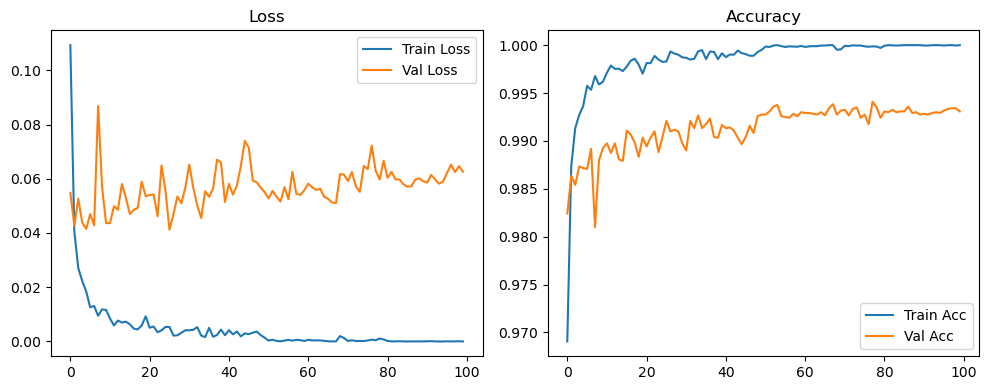

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9616 | Val Loss: 0.0906, Acc: 0.9718


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9820 | Val Loss: 0.0715, Acc: 0.9763


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9854 | Val Loss: 0.0538, Acc: 0.9828


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9884 | Val Loss: 0.0478, Acc: 0.9852


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0501, Acc: 0.9832


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.0407, Acc: 0.9875


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.0484, Acc: 0.9852


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0397, Acc: 0.9877


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0364, Acc: 0.9892


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0353, Acc: 0.9889


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0390, Acc: 0.9884


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0413, Acc: 0.9873


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0430, Acc: 0.9875


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9940 | Val Loss: 0.0357, Acc: 0.9880


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0418, Acc: 0.9882


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0373, Acc: 0.9883


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9951 | Val Loss: 0.0377, Acc: 0.9878


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9951 | Val Loss: 0.0533, Acc: 0.9849


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0396, Acc: 0.9888


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0305, Acc: 0.9903


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0334, Acc: 0.9899


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0376, Acc: 0.9896


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0390, Acc: 0.9890


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0403, Acc: 0.9886


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0360, Acc: 0.9903


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0390, Acc: 0.9880


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0396, Acc: 0.9893


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0325, Acc: 0.9902


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0314, Acc: 0.9912


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0338, Acc: 0.9899


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0374, Acc: 0.9897


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0372, Acc: 0.9905


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0398, Acc: 0.9893


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0362, Acc: 0.9902


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0369, Acc: 0.9904


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0433, Acc: 0.9882


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0358, Acc: 0.9895


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0351, Acc: 0.9905


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0367, Acc: 0.9890


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0357, Acc: 0.9904


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0485, Acc: 0.9872


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0372, Acc: 0.9903


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0360, Acc: 0.9907


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0308, Acc: 0.9917


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0429, Acc: 0.9892


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0401, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0345, Acc: 0.9913


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0356, Acc: 0.9897


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0374, Acc: 0.9903


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0382, Acc: 0.9897


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0307, Acc: 0.9920


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0327, Acc: 0.9916


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0310, Acc: 0.9914


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0338, Acc: 0.9912


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0344, Acc: 0.9922


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0357, Acc: 0.9913


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0376, Acc: 0.9911


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0394, Acc: 0.9907


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0354, Acc: 0.9924


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0338, Acc: 0.9915


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0321, Acc: 0.9928


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0442, Acc: 0.9898


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0340, Acc: 0.9913


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0356, Acc: 0.9919


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0296, Acc: 0.9924


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0346, Acc: 0.9920


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0377, Acc: 0.9906


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0427, Acc: 0.9898


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0470, Acc: 0.9892


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0399, Acc: 0.9904


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0328, Acc: 0.9915


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0371, Acc: 0.9913


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0327, Acc: 0.9918


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0327, Acc: 0.9915


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0349, Acc: 0.9918


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0372, Acc: 0.9907


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9992 | Val Loss: 0.0348, Acc: 0.9922


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0349, Acc: 0.9912


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0431, Acc: 0.9899


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9907


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0356, Acc: 0.9912


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0360, Acc: 0.9910


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0337, Acc: 0.9917


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0378, Acc: 0.9906


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0348, Acc: 0.9914


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0354, Acc: 0.9915


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0321, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0315, Acc: 0.9920


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0315, Acc: 0.9923


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0308, Acc: 0.9924


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0292, Acc: 0.9928


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0347, Acc: 0.9919


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0321, Acc: 0.9922


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0334, Acc: 0.9924


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0346, Acc: 0.9920


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0318, Acc: 0.9922


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0345, Acc: 0.9918


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0333, Acc: 0.9919


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0336, Acc: 0.9919


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0308, Acc: 0.9922


Final Test Loss: 0.0258 Accuracy: 0.9937


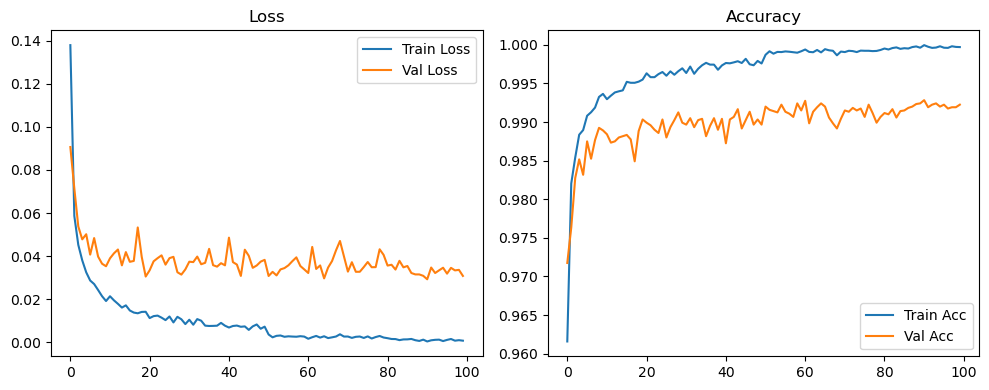

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2317, Acc: 0.9325 | Val Loss: 0.4543, Acc: 0.8427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1173, Acc: 0.9659 | Val Loss: 0.3524, Acc: 0.8829


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9712 | Val Loss: 0.2102, Acc: 0.9440


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9747 | Val Loss: 0.1193, Acc: 0.9708


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9759 | Val Loss: 0.1377, Acc: 0.9597


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9782 | Val Loss: 0.1573, Acc: 0.9612


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9804 | Val Loss: 0.1344, Acc: 0.9602


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9801 | Val Loss: 0.1235, Acc: 0.9694


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9808 | Val Loss: 0.1395, Acc: 0.9647


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9818 | Val Loss: 0.0932, Acc: 0.9778


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9820 | Val Loss: 0.0873, Acc: 0.9793


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0584, Acc: 0.9827 | Val Loss: 0.1129, Acc: 0.9762


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9839 | Val Loss: 0.0962, Acc: 0.9788


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9834 | Val Loss: 0.1150, Acc: 0.9728


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9836 | Val Loss: 0.0937, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9831 | Val Loss: 0.0996, Acc: 0.9758


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.0908, Acc: 0.9778


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9853 | Val Loss: 0.0744, Acc: 0.9843


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0680, Acc: 0.9845


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9861 | Val Loss: 0.0700, Acc: 0.9836


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.0589, Acc: 0.9860


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9860 | Val Loss: 0.0656, Acc: 0.9862


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0779, Acc: 0.9829


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9870 | Val Loss: 0.0809, Acc: 0.9850


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9863 | Val Loss: 0.0719, Acc: 0.9860


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.0667, Acc: 0.9868


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0555, Acc: 0.9879


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9865 | Val Loss: 0.0953, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.0683, Acc: 0.9881


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0815, Acc: 0.9807


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.0615, Acc: 0.9872


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9880 | Val Loss: 0.0761, Acc: 0.9827


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9873 | Val Loss: 0.0891, Acc: 0.9837


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9890 | Val Loss: 0.0770, Acc: 0.9838


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.1038, Acc: 0.9814


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9892 | Val Loss: 0.0978, Acc: 0.9805


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0775, Acc: 0.9842


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9888 | Val Loss: 0.0722, Acc: 0.9850


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0871, Acc: 0.9799


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0709, Acc: 0.9848


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9896 | Val Loss: 0.0905, Acc: 0.9799


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0784, Acc: 0.9843


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.0895, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9898 | Val Loss: 0.1074, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9900 | Val Loss: 0.1068, Acc: 0.9805


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1087, Acc: 0.9742


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.1126, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0957, Acc: 0.9819


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9899 | Val Loss: 0.1277, Acc: 0.9712


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.1229, Acc: 0.9675


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.1025, Acc: 0.9789


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.0961, Acc: 0.9791


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9919 | Val Loss: 0.0836, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.0909, Acc: 0.9816


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0807, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0961, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0876, Acc: 0.9818


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9933 | Val Loss: 0.1018, Acc: 0.9741


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0834, Acc: 0.9816


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0821, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0763, Acc: 0.9841


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0906, Acc: 0.9780


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0721, Acc: 0.9853


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.0835, Acc: 0.9810


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0641, Acc: 0.9870


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0744, Acc: 0.9852


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0844, Acc: 0.9819


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9932 | Val Loss: 0.0796, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0643, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0714, Acc: 0.9850


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9934 | Val Loss: 0.0782, Acc: 0.9832


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0938, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0958, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.1167, Acc: 0.9742


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1028, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.0962, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9933 | Val Loss: 0.0965, Acc: 0.9808


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0873, Acc: 0.9840


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1245, Acc: 0.9754


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0999, Acc: 0.9802


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1026, Acc: 0.9810


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1018, Acc: 0.9807


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0949, Acc: 0.9809


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.0936, Acc: 0.9803


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1019, Acc: 0.9791


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0957, Acc: 0.9819


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.1005, Acc: 0.9778


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0995, Acc: 0.9764


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0971, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0966, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.0910, Acc: 0.9789


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0881, Acc: 0.9806


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.0867, Acc: 0.9804


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0884, Acc: 0.9800


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.1000, Acc: 0.9766


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1006, Acc: 0.9792


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0883, Acc: 0.9817


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0986, Acc: 0.9788


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0958, Acc: 0.9778


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0795, Acc: 0.9838


Final Test Loss: 0.0799 Accuracy: 0.9828


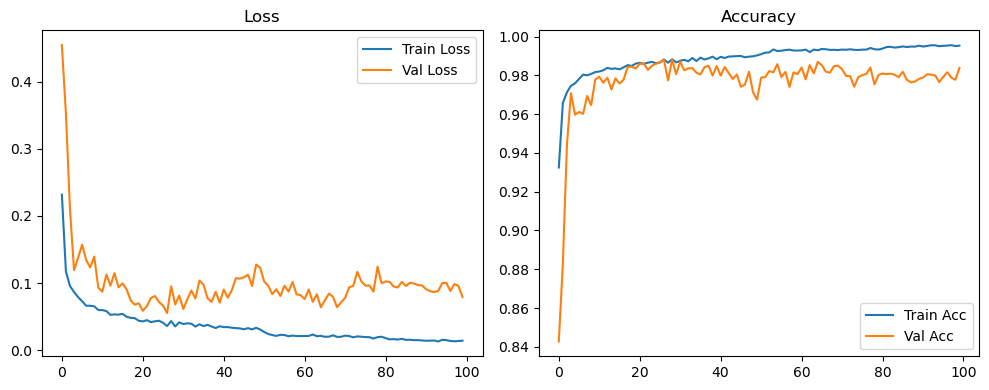

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1107, Acc: 0.9687 | Val Loss: 0.0579, Acc: 0.9818


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9872 | Val Loss: 0.0464, Acc: 0.9854


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9913 | Val Loss: 0.0487, Acc: 0.9865


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0460, Acc: 0.9851


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0450, Acc: 0.9861


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0429, Acc: 0.9878


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0424, Acc: 0.9896


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0526, Acc: 0.9876


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0469, Acc: 0.9886


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0463, Acc: 0.9876


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0390, Acc: 0.9904


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0535, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0468, Acc: 0.9901


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0438, Acc: 0.9913


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0381, Acc: 0.9921


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0381, Acc: 0.9920


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0428, Acc: 0.9919


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0493, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0408, Acc: 0.9918


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0438, Acc: 0.9910


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0533, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0527, Acc: 0.9900


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0500, Acc: 0.9909


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0681, Acc: 0.9886


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0418, Acc: 0.9929


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0509, Acc: 0.9900


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0650, Acc: 0.9874


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0490, Acc: 0.9911


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0547, Acc: 0.9915


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0518, Acc: 0.9905


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0515, Acc: 0.9915


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0477, Acc: 0.9916


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0500, Acc: 0.9908


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0540, Acc: 0.9904


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0583, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0503, Acc: 0.9920


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0578, Acc: 0.9914


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0510, Acc: 0.9920


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0454, Acc: 0.9929


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0519, Acc: 0.9923


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.0527, Acc: 0.9914


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0492, Acc: 0.9921


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0515, Acc: 0.9922


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0467, Acc: 0.9932


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0537, Acc: 0.9924


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0533, Acc: 0.9915


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0610, Acc: 0.9910


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0620, Acc: 0.9908


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0680, Acc: 0.9908


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0527, Acc: 0.9933


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0520, Acc: 0.9941


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0519, Acc: 0.9936


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0503, Acc: 0.9933


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9936


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9931


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9932


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9942


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0513, Acc: 0.9932


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9938


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9930


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0684, Acc: 0.9910


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0576, Acc: 0.9922


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0570, Acc: 0.9927


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9932


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0549, Acc: 0.9928


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0554, Acc: 0.9928


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0549, Acc: 0.9928


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0574, Acc: 0.9926


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0600, Acc: 0.9934


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0561, Acc: 0.9930


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9937


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0662, Acc: 0.9926


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0590, Acc: 0.9933


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0576, Acc: 0.9928


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0588, Acc: 0.9932


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9937


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0597, Acc: 0.9923


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0589, Acc: 0.9937


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0555, Acc: 0.9934


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0626, Acc: 0.9932


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9940


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9938


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9942


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9938


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9942


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0589, Acc: 0.9938


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0576, Acc: 0.9944


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9938


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9939


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9938


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9943


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9942


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9945


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9942


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9946


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9944


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9942


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9941


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9942


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9942


Final Test Loss: 0.0526 Accuracy: 0.9928


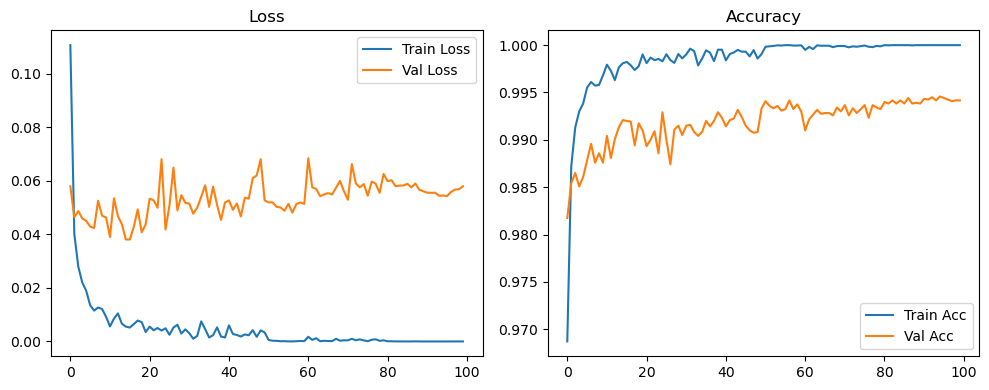

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1378, Acc: 0.9609 | Val Loss: 0.1003, Acc: 0.9681


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9815 | Val Loss: 0.0652, Acc: 0.9798


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 0.0511, Acc: 0.9842


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0507, Acc: 0.9847


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.0436, Acc: 0.9862


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0474, Acc: 0.9848


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.0512, Acc: 0.9843


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9937 | Val Loss: 0.0384, Acc: 0.9880


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0395, Acc: 0.9891


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0377, Acc: 0.9880


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.0350, Acc: 0.9902


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0323, Acc: 0.9905


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0371, Acc: 0.9895


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.0456, Acc: 0.9874


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0340, Acc: 0.9897


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0299, Acc: 0.9912


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.0309, Acc: 0.9912


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0406, Acc: 0.9886


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0356, Acc: 0.9893


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0359, Acc: 0.9900


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0362, Acc: 0.9899


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0343, Acc: 0.9911


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0343, Acc: 0.9905


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0410, Acc: 0.9903


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0331, Acc: 0.9919


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0384, Acc: 0.9897


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0389, Acc: 0.9878


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0400, Acc: 0.9890


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0363, Acc: 0.9896


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0340, Acc: 0.9910


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.0382, Acc: 0.9900


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0356, Acc: 0.9906


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0359, Acc: 0.9899


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0362, Acc: 0.9908


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0325, Acc: 0.9913


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0417, Acc: 0.9900


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0447, Acc: 0.9886


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0323, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.0426, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0410, Acc: 0.9883


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0390, Acc: 0.9878


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0342, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0372, Acc: 0.9894


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0331, Acc: 0.9911


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0392, Acc: 0.9899


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0408, Acc: 0.9890


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9969 | Val Loss: 0.0377, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0340, Acc: 0.9907


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0345, Acc: 0.9911


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0414, Acc: 0.9883


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0309, Acc: 0.9920


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0284, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0314, Acc: 0.9914


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0333, Acc: 0.9911


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0331, Acc: 0.9914


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0336, Acc: 0.9915


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0354, Acc: 0.9900


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0303, Acc: 0.9913


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0340, Acc: 0.9912


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0299, Acc: 0.9921


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0323, Acc: 0.9925


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0372, Acc: 0.9910


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0315, Acc: 0.9919


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0329, Acc: 0.9924


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9911


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0366, Acc: 0.9922


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0376, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0381, Acc: 0.9913


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0411, Acc: 0.9912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0383, Acc: 0.9910


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0383, Acc: 0.9913


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0402, Acc: 0.9902


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0390, Acc: 0.9911


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0337, Acc: 0.9918


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0385, Acc: 0.9915


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0398, Acc: 0.9907


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0354, Acc: 0.9921


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0411, Acc: 0.9913


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0363, Acc: 0.9927


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9989 | Val Loss: 0.0397, Acc: 0.9915


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0343, Acc: 0.9928


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0383, Acc: 0.9924


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0339, Acc: 0.9928


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0356, Acc: 0.9930


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0332, Acc: 0.9935


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0339, Acc: 0.9938


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0342, Acc: 0.9932


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0338, Acc: 0.9935


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0329, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0327, Acc: 0.9935


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0305, Acc: 0.9936


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0340, Acc: 0.9931


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0303, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0321, Acc: 0.9930


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0326, Acc: 0.9931


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0334, Acc: 0.9933


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9997 | Val Loss: 0.0326, Acc: 0.9932


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0318, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0326, Acc: 0.9934


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0319, Acc: 0.9932


Final Test Loss: 0.0307 Accuracy: 0.9931


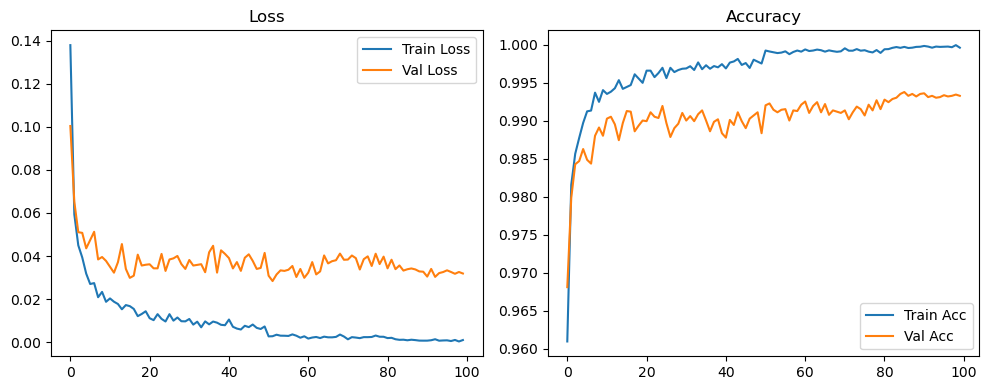

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2325, Acc: 0.9320 | Val Loss: 0.7441, Acc: 0.7317


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1159, Acc: 0.9659 | Val Loss: 0.3145, Acc: 0.9048


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9717 | Val Loss: 0.2313, Acc: 0.9298


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9738 | Val Loss: 0.1630, Acc: 0.9541


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9763 | Val Loss: 0.2210, Acc: 0.9272


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0753, Acc: 0.9778 | Val Loss: 0.1380, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9797 | Val Loss: 0.1457, Acc: 0.9535


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9810 | Val Loss: 0.1223, Acc: 0.9661


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9805 | Val Loss: 0.1292, Acc: 0.9653


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9819 | Val Loss: 0.0960, Acc: 0.9733


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9817 | Val Loss: 0.1183, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9821 | Val Loss: 0.1160, Acc: 0.9719


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9830 | Val Loss: 0.0786, Acc: 0.9830


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9829 | Val Loss: 0.0928, Acc: 0.9778


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 0.0752, Acc: 0.9828


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9839 | Val Loss: 0.0810, Acc: 0.9800


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0939, Acc: 0.9761


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9853 | Val Loss: 0.0821, Acc: 0.9805


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.0722, Acc: 0.9829


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9859 | Val Loss: 0.0711, Acc: 0.9848


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9863 | Val Loss: 0.0619, Acc: 0.9878


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9858 | Val Loss: 0.0756, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.0729, Acc: 0.9850


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.0773, Acc: 0.9845


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9870 | Val Loss: 0.0765, Acc: 0.9868


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9865 | Val Loss: 0.0909, Acc: 0.9821


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 0.0645, Acc: 0.9874


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9867 | Val Loss: 0.0604, Acc: 0.9878


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.0867, Acc: 0.9840


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9879 | Val Loss: 0.0659, Acc: 0.9851


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9875 | Val Loss: 0.0886, Acc: 0.9791


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9881 | Val Loss: 0.0819, Acc: 0.9809


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9882 | Val Loss: 0.0823, Acc: 0.9838


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9882 | Val Loss: 0.0733, Acc: 0.9846


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.1036, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9895 | Val Loss: 0.0943, Acc: 0.9786


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9883 | Val Loss: 0.0886, Acc: 0.9832


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0605, Acc: 0.9879


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9892 | Val Loss: 0.0616, Acc: 0.9881


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9887 | Val Loss: 0.0670, Acc: 0.9863


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.0812, Acc: 0.9848


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9889 | Val Loss: 0.0676, Acc: 0.9873


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9894 | Val Loss: 0.0762, Acc: 0.9871


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0849, Acc: 0.9841


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0947, Acc: 0.9820


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.0806, Acc: 0.9800


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.1075, Acc: 0.9726


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.0904, Acc: 0.9865


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.1011, Acc: 0.9791


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9906 | Val Loss: 0.0878, Acc: 0.9845


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0713, Acc: 0.9875


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.0726, Acc: 0.9874


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0590, Acc: 0.9884


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0766, Acc: 0.9869


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0844, Acc: 0.9852


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0891, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0721, Acc: 0.9850


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0763, Acc: 0.9833


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.0786, Acc: 0.9833


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.0732, Acc: 0.9855


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0699, Acc: 0.9862


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0839, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.0887, Acc: 0.9819


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.0945, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0921, Acc: 0.9829


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0830, Acc: 0.9863


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0895, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.0988, Acc: 0.9819


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1059, Acc: 0.9757


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0874, Acc: 0.9819


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0819, Acc: 0.9844


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0904, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9937 | Val Loss: 0.0667, Acc: 0.9853


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0723, Acc: 0.9865


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0743, Acc: 0.9874


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0572, Acc: 0.9893


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0772, Acc: 0.9875


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.0736, Acc: 0.9878


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0888, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.1043, Acc: 0.9746


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0931, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0849, Acc: 0.9830


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0880, Acc: 0.9844


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0858, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0831, Acc: 0.9831


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0742, Acc: 0.9851


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0786, Acc: 0.9835


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.0789, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0729, Acc: 0.9850


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0765, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0735, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0769, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0764, Acc: 0.9855


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0710, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0885, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0896, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0827, Acc: 0.9842


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0769, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0773, Acc: 0.9846


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0715, Acc: 0.9853


Final Test Loss: 0.0696 Accuracy: 0.9839


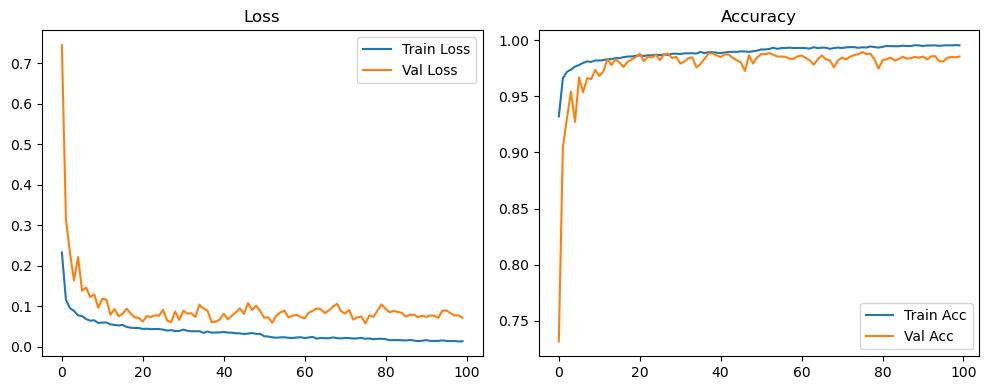

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1097, Acc: 0.9689 | Val Loss: 0.0532, Acc: 0.9828


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.0442, Acc: 0.9872


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0645, Acc: 0.9814


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0426, Acc: 0.9870


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0425, Acc: 0.9877


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0471, Acc: 0.9882


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0372, Acc: 0.9892


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0476, Acc: 0.9878


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0430, Acc: 0.9900


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9961 | Val Loss: 0.0465, Acc: 0.9881


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0483, Acc: 0.9880


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0458, Acc: 0.9888


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0465, Acc: 0.9897


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0431, Acc: 0.9909


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0474, Acc: 0.9902


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0400, Acc: 0.9916


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0453, Acc: 0.9899


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0585, Acc: 0.9884


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0624, Acc: 0.9870


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0505, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0424, Acc: 0.9910


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0559, Acc: 0.9899


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0572, Acc: 0.9890


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0641, Acc: 0.9887


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0425, Acc: 0.9922


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0512, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0477, Acc: 0.9908


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0471, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0426, Acc: 0.9919


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0410, Acc: 0.9914


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0605, Acc: 0.9911


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0516, Acc: 0.9901


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0508, Acc: 0.9916


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0501, Acc: 0.9915


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0544, Acc: 0.9914


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0442, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0521, Acc: 0.9922


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0607, Acc: 0.9896


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0588, Acc: 0.9915


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0464, Acc: 0.9923


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0546, Acc: 0.9908


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0523, Acc: 0.9910


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0461, Acc: 0.9917


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0696, Acc: 0.9889


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0535, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0595, Acc: 0.9913


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0578, Acc: 0.9918


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0622, Acc: 0.9914


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0724, Acc: 0.9901


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0635, Acc: 0.9907


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0531, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0536, Acc: 0.9920


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0515, Acc: 0.9924


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0527, Acc: 0.9924


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9927


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9923


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9929


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9923


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9929


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9922


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9928


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9930


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9928


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9931


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9931


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9929


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9931


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9932


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9924


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0547, Acc: 0.9923


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9926


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9929


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9928


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0562, Acc: 0.9925


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9926


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9924


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9921


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9920


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9925


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9925


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9926


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9924


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0595, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9923


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0587, Acc: 0.9927


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9923


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9925


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9924


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9923


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9926


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9927


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9927


Final Test Loss: 0.0461 Accuracy: 0.9935


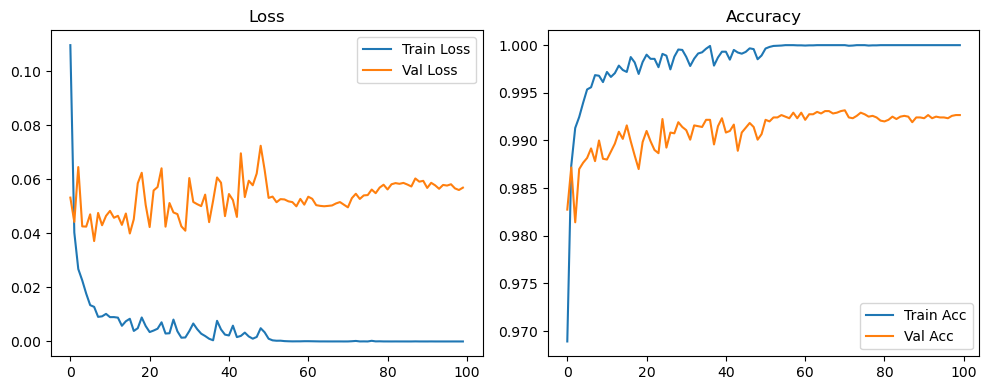

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9610 | Val Loss: 0.0941, Acc: 0.9705


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9814 | Val Loss: 0.0717, Acc: 0.9780


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9850 | Val Loss: 0.0537, Acc: 0.9835


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9885 | Val Loss: 0.0663, Acc: 0.9796


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9895 | Val Loss: 0.0530, Acc: 0.9832


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9898 | Val Loss: 0.0513, Acc: 0.9844


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.0501, Acc: 0.9837


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0382, Acc: 0.9881


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0361, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0348, Acc: 0.9897


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0742, Acc: 0.9784


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0361, Acc: 0.9895


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0417, Acc: 0.9876


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0425, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0339, Acc: 0.9905


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0358, Acc: 0.9895


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0329, Acc: 0.9904


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0361, Acc: 0.9896


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0331, Acc: 0.9904


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0341, Acc: 0.9898


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0423, Acc: 0.9882


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0312, Acc: 0.9912


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0381, Acc: 0.9895


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0369, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0411, Acc: 0.9889


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0377, Acc: 0.9888


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0331, Acc: 0.9909


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0348, Acc: 0.9904


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0371, Acc: 0.9905


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0418, Acc: 0.9892


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0468, Acc: 0.9883


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0347, Acc: 0.9909


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0457, Acc: 0.9885


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0562, Acc: 0.9858


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0453, Acc: 0.9885


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0471, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0375, Acc: 0.9902


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0350, Acc: 0.9907


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0450, Acc: 0.9892


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0330, Acc: 0.9914


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0426, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0422, Acc: 0.9893


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0346, Acc: 0.9913


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0316, Acc: 0.9915


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0362, Acc: 0.9915


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0501, Acc: 0.9878


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0397, Acc: 0.9900


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0409, Acc: 0.9894


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0351, Acc: 0.9912


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0416, Acc: 0.9881


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0330, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0323, Acc: 0.9922


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0317, Acc: 0.9926


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0314, Acc: 0.9922


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0324, Acc: 0.9924


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0338, Acc: 0.9920


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0310, Acc: 0.9928


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0299, Acc: 0.9930


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0304, Acc: 0.9927


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0305, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0306, Acc: 0.9929


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0316, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0292, Acc: 0.9933


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0307, Acc: 0.9928


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0308, Acc: 0.9929


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0306, Acc: 0.9930


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0315, Acc: 0.9929


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0324, Acc: 0.9926


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0332, Acc: 0.9923


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0312, Acc: 0.9926


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0302, Acc: 0.9929


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0303, Acc: 0.9929


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0312, Acc: 0.9929


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0298, Acc: 0.9928


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0312, Acc: 0.9930


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0309, Acc: 0.9935


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0304, Acc: 0.9938


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0303, Acc: 0.9931


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0330, Acc: 0.9935


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0345, Acc: 0.9923


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0312, Acc: 0.9929


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0336, Acc: 0.9929


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0310, Acc: 0.9932


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0322, Acc: 0.9933


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0313, Acc: 0.9935


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0308, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0313, Acc: 0.9933


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0301, Acc: 0.9938


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0301, Acc: 0.9941


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0312, Acc: 0.9938


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0284, Acc: 0.9936


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0317, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0294, Acc: 0.9943


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0314, Acc: 0.9938


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0311, Acc: 0.9936


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0327, Acc: 0.9934


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0326, Acc: 0.9936


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0292, Acc: 0.9942


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0320, Acc: 0.9936


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0301, Acc: 0.9936


Final Test Loss: 0.0259 Accuracy: 0.9927


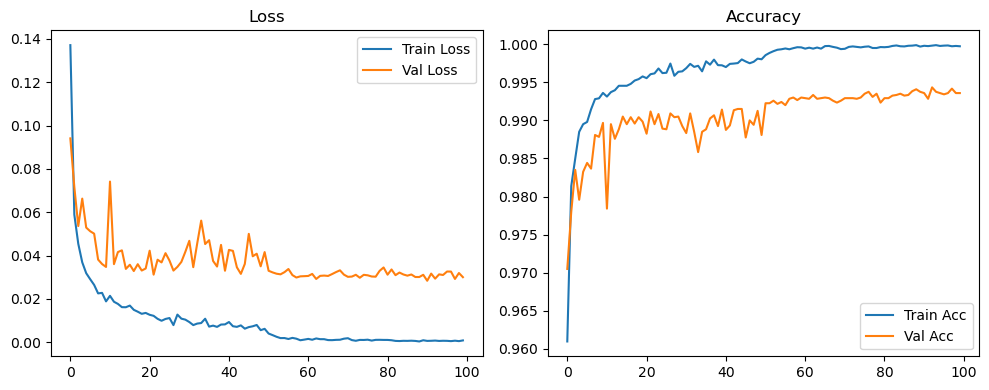

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2325, Acc: 0.9326 | Val Loss: 0.8464, Acc: 0.6898


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1155, Acc: 0.9666 | Val Loss: 0.2325, Acc: 0.9343


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9706 | Val Loss: 0.1662, Acc: 0.9602


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9748 | Val Loss: 0.1641, Acc: 0.9519


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9768 | Val Loss: 0.1516, Acc: 0.9541


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9773 | Val Loss: 0.1405, Acc: 0.9643


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9783 | Val Loss: 0.1199, Acc: 0.9691


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9798 | Val Loss: 0.1506, Acc: 0.9572


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9811 | Val Loss: 0.1079, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9827 | Val Loss: 0.1198, Acc: 0.9651


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9819 | Val Loss: 0.1370, Acc: 0.9603


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9816 | Val Loss: 0.1177, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9837 | Val Loss: 0.0938, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.0947, Acc: 0.9758


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9844 | Val Loss: 0.0723, Acc: 0.9829


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9838 | Val Loss: 0.0743, Acc: 0.9825


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.1006, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9852 | Val Loss: 0.0712, Acc: 0.9849


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9857 | Val Loss: 0.0726, Acc: 0.9832


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9860 | Val Loss: 0.0608, Acc: 0.9858


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0772, Acc: 0.9780


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9857 | Val Loss: 0.0865, Acc: 0.9828


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0866, Acc: 0.9801


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9854 | Val Loss: 0.0986, Acc: 0.9807


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9862 | Val Loss: 0.0756, Acc: 0.9835


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9870 | Val Loss: 0.1025, Acc: 0.9761


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9877 | Val Loss: 0.0733, Acc: 0.9836


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9875 | Val Loss: 0.0849, Acc: 0.9807


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.1055, Acc: 0.9737


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.1031, Acc: 0.9780


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9878 | Val Loss: 0.0765, Acc: 0.9837


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9870 | Val Loss: 0.1179, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.0654, Acc: 0.9866


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.0874, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.0969, Acc: 0.9808


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.0835, Acc: 0.9799


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.0786, Acc: 0.9845


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.0808, Acc: 0.9808


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0834, Acc: 0.9787


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9877 | Val Loss: 0.0851, Acc: 0.9856


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.1044, Acc: 0.9733


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.0965, Acc: 0.9812


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.0896, Acc: 0.9839


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 0.1107, Acc: 0.9782


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9899 | Val Loss: 0.0893, Acc: 0.9820


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0516, Acc: 0.9883


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.0864, Acc: 0.9826


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0806, Acc: 0.9864


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9902 | Val Loss: 0.0846, Acc: 0.9830


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0875, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0635, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0618, Acc: 0.9869


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0587, Acc: 0.9871


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0630, Acc: 0.9869


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0643, Acc: 0.9867


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0616, Acc: 0.9872


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0647, Acc: 0.9869


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0652, Acc: 0.9854


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.0606, Acc: 0.9872


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.0645, Acc: 0.9878


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.0638, Acc: 0.9876


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0667, Acc: 0.9852


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0635, Acc: 0.9888


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0583, Acc: 0.9879


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0572, Acc: 0.9884


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0600, Acc: 0.9878


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.0567, Acc: 0.9882


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0658, Acc: 0.9862


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0685, Acc: 0.9858


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0595, Acc: 0.9886


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9944 | Val Loss: 0.0593, Acc: 0.9882


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0643, Acc: 0.9888


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0619, Acc: 0.9869


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0565, Acc: 0.9879


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0622, Acc: 0.9868


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0633, Acc: 0.9873


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0730, Acc: 0.9863


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0663, Acc: 0.9868


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0734, Acc: 0.9860


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0714, Acc: 0.9857


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0691, Acc: 0.9856


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.0700, Acc: 0.9856


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9939 | Val Loss: 0.0700, Acc: 0.9875


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0683, Acc: 0.9860


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0673, Acc: 0.9875


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0662, Acc: 0.9872


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0643, Acc: 0.9864


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0651, Acc: 0.9872


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0597, Acc: 0.9887


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0600, Acc: 0.9889


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0615, Acc: 0.9871


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0661, Acc: 0.9860


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0654, Acc: 0.9872


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0653, Acc: 0.9861


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0663, Acc: 0.9854


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0683, Acc: 0.9857


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0717, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0655, Acc: 0.9870


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0690, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0639, Acc: 0.9862


Final Test Loss: 0.0619 Accuracy: 0.9869


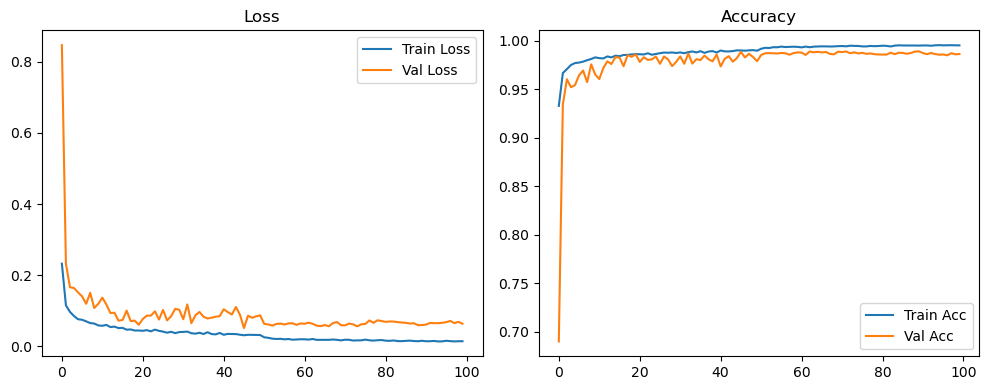

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9715 | Val Loss: 0.0472, Acc: 0.9849


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0417, Acc: 0.9858


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0484, Acc: 0.9862


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0371, Acc: 0.9882


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0408, Acc: 0.9874


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0376, Acc: 0.9896


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0384, Acc: 0.9900


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0424, Acc: 0.9895


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0448, Acc: 0.9890


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0373, Acc: 0.9911


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0408, Acc: 0.9900


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0387, Acc: 0.9908


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0434, Acc: 0.9902


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0339, Acc: 0.9917


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0331, Acc: 0.9932


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0376, Acc: 0.9915


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0411, Acc: 0.9916


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0606, Acc: 0.9859


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0361, Acc: 0.9907


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0463, Acc: 0.9892


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0436, Acc: 0.9912


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0387, Acc: 0.9919


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0434, Acc: 0.9907


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0394, Acc: 0.9916


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0440, Acc: 0.9912


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0419, Acc: 0.9917


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9918


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0431, Acc: 0.9913


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0472, Acc: 0.9916


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0522, Acc: 0.9893


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0475, Acc: 0.9908


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0471, Acc: 0.9911


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0501, Acc: 0.9913


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0505, Acc: 0.9904


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0545, Acc: 0.9901


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0456, Acc: 0.9920


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0434, Acc: 0.9922


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0557, Acc: 0.9908


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0515, Acc: 0.9909


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0540, Acc: 0.9909


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0536, Acc: 0.9903


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0525, Acc: 0.9912


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0409, Acc: 0.9922


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0576, Acc: 0.9897


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0472, Acc: 0.9912


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0503, Acc: 0.9921


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0490, Acc: 0.9914


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0556, Acc: 0.9902


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0551, Acc: 0.9910


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0559, Acc: 0.9916


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0616, Acc: 0.9912


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0481, Acc: 0.9917


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.0483, Acc: 0.9930


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0512, Acc: 0.9923


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0496, Acc: 0.9910


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0550, Acc: 0.9911


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0491, Acc: 0.9920


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9928


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9921


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0747, Acc: 0.9897


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0538, Acc: 0.9916


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0494, Acc: 0.9920


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0512, Acc: 0.9918


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0543, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0575, Acc: 0.9902


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0530, Acc: 0.9913


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0498, Acc: 0.9918


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0513, Acc: 0.9913


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0559, Acc: 0.9914


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0553, Acc: 0.9915


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0575, Acc: 0.9922


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0668, Acc: 0.9900


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0606, Acc: 0.9912


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0610, Acc: 0.9913


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0657, Acc: 0.9903


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0522, Acc: 0.9922


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0558, Acc: 0.9910


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9909


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9921


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9921


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0619, Acc: 0.9917


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0766, Acc: 0.9904


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0663, Acc: 0.9908


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0602, Acc: 0.9915


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0546, Acc: 0.9917


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0770, Acc: 0.9893


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0671, Acc: 0.9917


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0707, Acc: 0.9903


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9918


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0626, Acc: 0.9911


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0672, Acc: 0.9899


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0656, Acc: 0.9913


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0677, Acc: 0.9918


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0605, Acc: 0.9916


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0569, Acc: 0.9928


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0565, Acc: 0.9921


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0690, Acc: 0.9902


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9996 | Val Loss: 0.0625, Acc: 0.9910


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0617, Acc: 0.9913


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0630, Acc: 0.9915


Final Test Loss: 0.0553 Accuracy: 0.9924


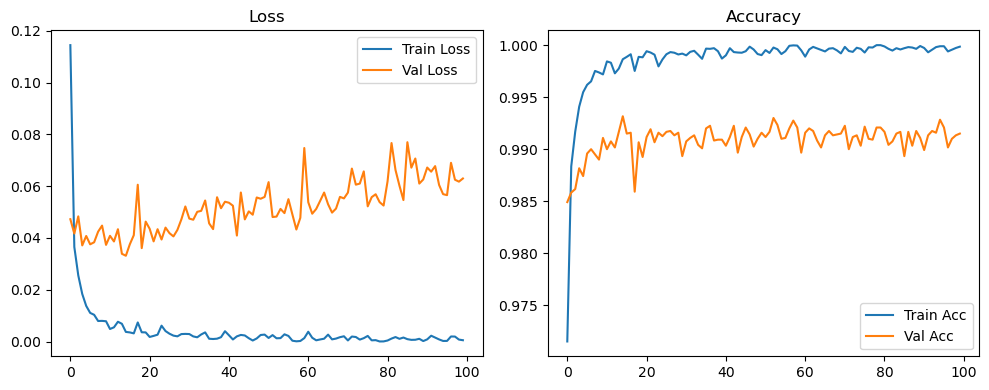

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1412, Acc: 0.9646 | Val Loss: 0.0798, Acc: 0.9755


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9832 | Val Loss: 0.0674, Acc: 0.9782


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0611, Acc: 0.9801


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9896 | Val Loss: 0.0449, Acc: 0.9873


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0422, Acc: 0.9873


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.0354, Acc: 0.9897


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9930 | Val Loss: 0.0427, Acc: 0.9875


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.0373, Acc: 0.9885


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0347, Acc: 0.9891


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0307, Acc: 0.9898


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0420, Acc: 0.9887


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.0318, Acc: 0.9898


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9951 | Val Loss: 0.0322, Acc: 0.9901


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0323, Acc: 0.9894


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0277, Acc: 0.9923


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0348, Acc: 0.9898


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0350, Acc: 0.9907


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0339, Acc: 0.9903


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9964 | Val Loss: 0.0289, Acc: 0.9908


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0305, Acc: 0.9912


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0303, Acc: 0.9915


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0316, Acc: 0.9909


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0277, Acc: 0.9918


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0333, Acc: 0.9916


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0346, Acc: 0.9907


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0270, Acc: 0.9920


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0320, Acc: 0.9918


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0380, Acc: 0.9902


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0325, Acc: 0.9918


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0369, Acc: 0.9894


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0327, Acc: 0.9918


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0332, Acc: 0.9916


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0348, Acc: 0.9900


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0344, Acc: 0.9907


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0433, Acc: 0.9897


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0333, Acc: 0.9909


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0404, Acc: 0.9907


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0293, Acc: 0.9920


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0311, Acc: 0.9912


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0308, Acc: 0.9910


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0364, Acc: 0.9908


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0325, Acc: 0.9922


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0310, Acc: 0.9913


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9975 | Val Loss: 0.0337, Acc: 0.9898


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0367, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0323, Acc: 0.9917


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0357, Acc: 0.9909


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0283, Acc: 0.9922


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0423, Acc: 0.9893


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0370, Acc: 0.9898


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0369, Acc: 0.9907


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0284, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0342, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0330, Acc: 0.9917


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0366, Acc: 0.9910


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0407, Acc: 0.9901


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0371, Acc: 0.9894


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0344, Acc: 0.9913


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0364, Acc: 0.9907


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0326, Acc: 0.9917


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0371, Acc: 0.9888


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0346, Acc: 0.9900


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0377, Acc: 0.9909


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0305, Acc: 0.9917


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0286, Acc: 0.9916


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0302, Acc: 0.9913


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0381, Acc: 0.9896


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0333, Acc: 0.9910


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0379, Acc: 0.9898


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0346, Acc: 0.9907


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0356, Acc: 0.9918


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0325, Acc: 0.9913


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0307, Acc: 0.9926


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0369, Acc: 0.9909


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0330, Acc: 0.9914


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0349, Acc: 0.9910


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0333, Acc: 0.9912


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0324, Acc: 0.9922


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0374, Acc: 0.9908


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0405, Acc: 0.9902


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0347, Acc: 0.9908


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0385, Acc: 0.9911


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0304, Acc: 0.9923


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9922


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0312, Acc: 0.9923


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0322, Acc: 0.9922


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0372, Acc: 0.9907


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0418, Acc: 0.9887


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0398, Acc: 0.9905


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0399, Acc: 0.9901


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0303, Acc: 0.9920


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0353, Acc: 0.9914


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0394, Acc: 0.9899


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0406, Acc: 0.9892


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0345, Acc: 0.9916


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0269, Acc: 0.9930


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0330, Acc: 0.9915


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0317, Acc: 0.9924


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0308, Acc: 0.9922


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0288, Acc: 0.9929


Final Test Loss: 0.0256 Accuracy: 0.9936


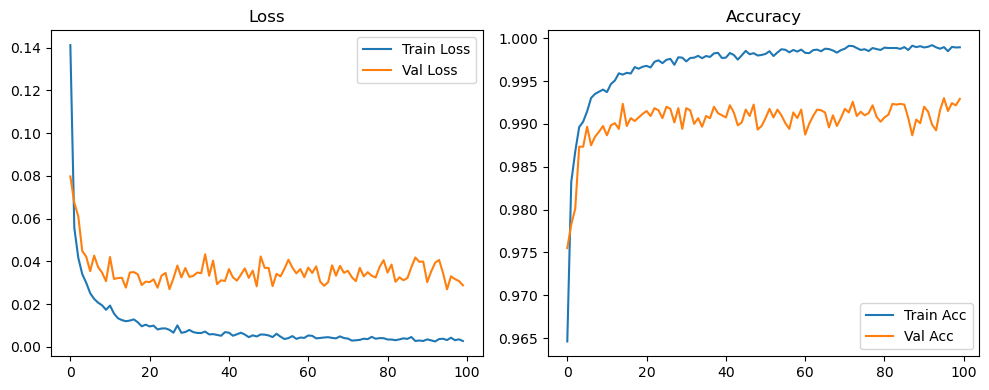

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2360, Acc: 0.9369 | Val Loss: 0.6993, Acc: 0.7468


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1088, Acc: 0.9680 | Val Loss: 0.2491, Acc: 0.9238


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9735 | Val Loss: 0.1734, Acc: 0.9527


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9766 | Val Loss: 0.1235, Acc: 0.9663


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9787 | Val Loss: 0.1174, Acc: 0.9656


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9800 | Val Loss: 0.0815, Acc: 0.9793


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9809 | Val Loss: 0.1062, Acc: 0.9719


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9828 | Val Loss: 0.1190, Acc: 0.9668


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9820 | Val Loss: 0.1174, Acc: 0.9667


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9824 | Val Loss: 0.1169, Acc: 0.9635


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9839 | Val Loss: 0.1069, Acc: 0.9711


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9840 | Val Loss: 0.1124, Acc: 0.9688


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9848 | Val Loss: 0.0824, Acc: 0.9789


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9855 | Val Loss: 0.0757, Acc: 0.9802


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9858 | Val Loss: 0.0988, Acc: 0.9725


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9852 | Val Loss: 0.0842, Acc: 0.9780


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9871 | Val Loss: 0.0974, Acc: 0.9744


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9861 | Val Loss: 0.0974, Acc: 0.9702


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9862 | Val Loss: 0.0894, Acc: 0.9766


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9869 | Val Loss: 0.0758, Acc: 0.9846


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.0658, Acc: 0.9853


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.0820, Acc: 0.9802


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.0949, Acc: 0.9781


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0742, Acc: 0.9844


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9886 | Val Loss: 0.0702, Acc: 0.9863


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.0835, Acc: 0.9810


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.0754, Acc: 0.9840


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9887 | Val Loss: 0.0913, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9889 | Val Loss: 0.0656, Acc: 0.9862


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9892 | Val Loss: 0.0768, Acc: 0.9807


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0701, Acc: 0.9821


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9893 | Val Loss: 0.0866, Acc: 0.9783


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9895 | Val Loss: 0.0736, Acc: 0.9812


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9897 | Val Loss: 0.0687, Acc: 0.9828


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9902 | Val Loss: 0.0847, Acc: 0.9799


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0714, Acc: 0.9838


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9889 | Val Loss: 0.0612, Acc: 0.9864


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.0607, Acc: 0.9882


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.0656, Acc: 0.9853


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.0741, Acc: 0.9870


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0599, Acc: 0.9858


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.0739, Acc: 0.9855


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.0813, Acc: 0.9801


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0821, Acc: 0.9820


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0855, Acc: 0.9818


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0876, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.0836, Acc: 0.9802


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.0823, Acc: 0.9824


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0979, Acc: 0.9768


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0847, Acc: 0.9792


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0758, Acc: 0.9827


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9909 | Val Loss: 0.0864, Acc: 0.9793


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.0754, Acc: 0.9844


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.0791, Acc: 0.9840


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0797, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0753, Acc: 0.9816


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0925, Acc: 0.9776


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.0820, Acc: 0.9795


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.0798, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0913, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0755, Acc: 0.9814


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9918 | Val Loss: 0.0887, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9907 | Val Loss: 0.0917, Acc: 0.9788


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9919 | Val Loss: 0.1042, Acc: 0.9761


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0835, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0794, Acc: 0.9836


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0861, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9923 | Val Loss: 0.0758, Acc: 0.9822


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0716, Acc: 0.9826


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0849, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.1146, Acc: 0.9730


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9924 | Val Loss: 0.1025, Acc: 0.9756


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9916 | Val Loss: 0.0912, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9923 | Val Loss: 0.0850, Acc: 0.9788


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1097, Acc: 0.9732


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0742, Acc: 0.9832


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0901, Acc: 0.9797


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1037, Acc: 0.9774


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1062, Acc: 0.9754


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0769, Acc: 0.9824


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0769, Acc: 0.9834


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0827, Acc: 0.9803


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0925, Acc: 0.9798


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.1046, Acc: 0.9732


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1186, Acc: 0.9710


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.1079, Acc: 0.9743


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9930 | Val Loss: 0.1050, Acc: 0.9767


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0855, Acc: 0.9811


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.1112, Acc: 0.9738


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.1446, Acc: 0.9633


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0824, Acc: 0.9800


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.1080, Acc: 0.9709


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.0806, Acc: 0.9814


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1124, Acc: 0.9755


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.1059, Acc: 0.9750


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1059, Acc: 0.9768


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1147, Acc: 0.9724


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1136, Acc: 0.9780


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1212, Acc: 0.9738


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1882, Acc: 0.9583


Final Test Loss: 0.1846 Accuracy: 0.9587


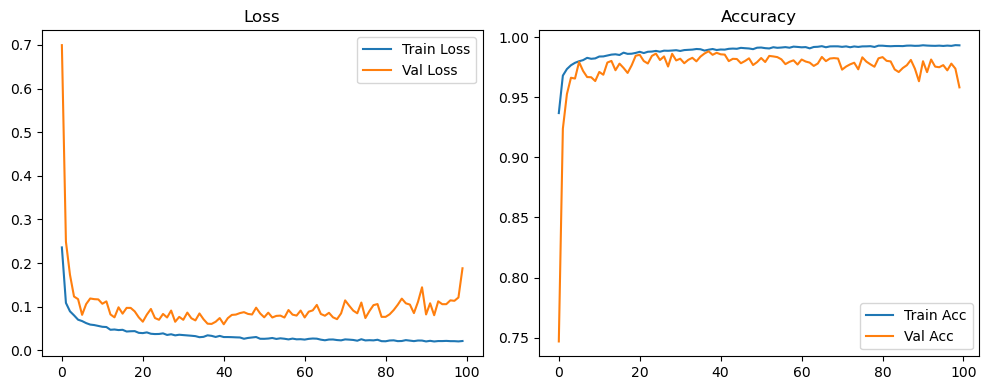

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1140, Acc: 0.9714 | Val Loss: 0.0479, Acc: 0.9844


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9889 | Val Loss: 0.0390, Acc: 0.9875


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0402, Acc: 0.9882


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0374, Acc: 0.9893


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0404, Acc: 0.9869


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0328, Acc: 0.9901


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0458, Acc: 0.9875


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0418, Acc: 0.9887


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0401, Acc: 0.9892


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0335, Acc: 0.9909


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0443, Acc: 0.9891


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0460, Acc: 0.9888


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.0455, Acc: 0.9888


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0382, Acc: 0.9912


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0395, Acc: 0.9908


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0452, Acc: 0.9904


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9917


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0358, Acc: 0.9924


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0384, Acc: 0.9909


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0430, Acc: 0.9908


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0389, Acc: 0.9924


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0370, Acc: 0.9925


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0444, Acc: 0.9910


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0412, Acc: 0.9912


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0433, Acc: 0.9908


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0452, Acc: 0.9918


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0586, Acc: 0.9886


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0438, Acc: 0.9908


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9918


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0375, Acc: 0.9931


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0481, Acc: 0.9905


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0404, Acc: 0.9922


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9984 | Val Loss: 0.0396, Acc: 0.9924


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0396, Acc: 0.9924


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0443, Acc: 0.9922


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0567, Acc: 0.9901


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0501, Acc: 0.9907


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0449, Acc: 0.9922


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0443, Acc: 0.9916


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0418, Acc: 0.9918


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0440, Acc: 0.9921


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0483, Acc: 0.9922


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0582, Acc: 0.9904


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0418, Acc: 0.9919


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0458, Acc: 0.9922


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0449, Acc: 0.9925


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0448, Acc: 0.9918


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0583, Acc: 0.9912


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0410, Acc: 0.9927


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0498, Acc: 0.9917


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0408, Acc: 0.9930


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0451, Acc: 0.9929


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9928


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9929


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9932


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9932


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9930


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9930


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9930


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9931


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9933


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0511, Acc: 0.9916


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0450, Acc: 0.9926


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9935


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0507, Acc: 0.9927


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9924


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9932


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9915


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0549, Acc: 0.9926


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0524, Acc: 0.9924


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9933


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9931


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9932


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9929


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9938


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9934


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9932


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0614, Acc: 0.9902


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0481, Acc: 0.9923


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9927


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9925


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9932


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9929


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9930


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9933


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9931


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9932


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9932


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9933


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9930


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9934


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9932


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9932


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9936


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9931


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0492, Acc: 0.9930


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9932


Final Test Loss: 0.0496 Accuracy: 0.9922


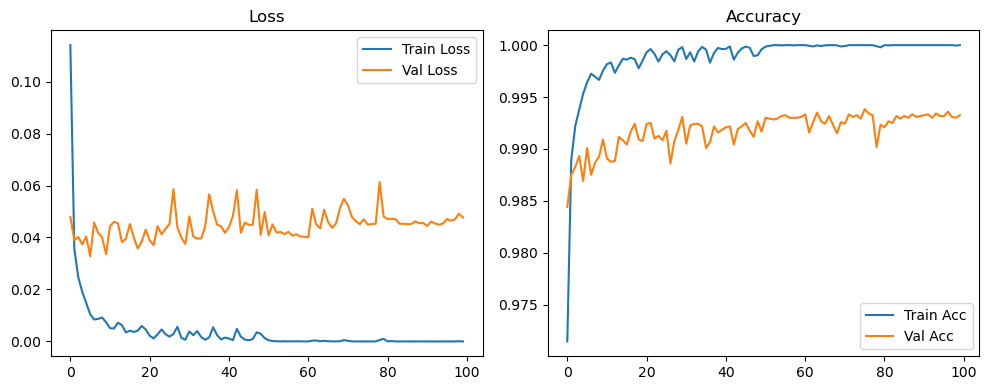

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1411, Acc: 0.9642 | Val Loss: 0.0788, Acc: 0.9753


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9833 | Val Loss: 0.0693, Acc: 0.9788


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9859 | Val Loss: 0.0585, Acc: 0.9818


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.0488, Acc: 0.9849


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0433, Acc: 0.9868


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0377, Acc: 0.9888


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9927 | Val Loss: 0.0497, Acc: 0.9850


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0332, Acc: 0.9895


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0431, Acc: 0.9876


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9940 | Val Loss: 0.0334, Acc: 0.9903


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.0334, Acc: 0.9898


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0379, Acc: 0.9885


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0307, Acc: 0.9908


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0335, Acc: 0.9898


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0360, Acc: 0.9890


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0320, Acc: 0.9911


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0318, Acc: 0.9907


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0329, Acc: 0.9905


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0325, Acc: 0.9904


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0347, Acc: 0.9902


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0361, Acc: 0.9902


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0359, Acc: 0.9905


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0295, Acc: 0.9926


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0315, Acc: 0.9915


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0342, Acc: 0.9903


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0302, Acc: 0.9918


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0391, Acc: 0.9891


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0385, Acc: 0.9894


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0328, Acc: 0.9908


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.0292, Acc: 0.9917


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0325, Acc: 0.9907


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0349, Acc: 0.9913


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0326, Acc: 0.9914


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0300, Acc: 0.9918


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0299, Acc: 0.9918


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0380, Acc: 0.9908


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0358, Acc: 0.9903


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.0313, Acc: 0.9913


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0330, Acc: 0.9918


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.0340, Acc: 0.9902


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0306, Acc: 0.9924


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0355, Acc: 0.9908


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0300, Acc: 0.9913


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0275, Acc: 0.9921


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0335, Acc: 0.9919


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0321, Acc: 0.9914


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0395, Acc: 0.9894


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0308, Acc: 0.9922


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0296, Acc: 0.9919


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0361, Acc: 0.9905


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0280, Acc: 0.9928


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0284, Acc: 0.9928


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0276, Acc: 0.9922


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0281, Acc: 0.9932


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0287, Acc: 0.9930


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0292, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0318, Acc: 0.9920


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0313, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0336, Acc: 0.9922


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0320, Acc: 0.9925


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0290, Acc: 0.9932


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0307, Acc: 0.9926


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0319, Acc: 0.9926


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0306, Acc: 0.9930


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0296, Acc: 0.9926


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0325, Acc: 0.9914


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0292, Acc: 0.9925


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0319, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0286, Acc: 0.9931


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0257, Acc: 0.9937


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0288, Acc: 0.9934


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0285, Acc: 0.9930


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0293, Acc: 0.9931


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0277, Acc: 0.9931


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0302, Acc: 0.9924


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0295, Acc: 0.9927


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0290, Acc: 0.9930


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.0303, Acc: 0.9936


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0277, Acc: 0.9937


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0286, Acc: 0.9938


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0266, Acc: 0.9941


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0284, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0287, Acc: 0.9938


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0299, Acc: 0.9925


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0280, Acc: 0.9941


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0266, Acc: 0.9942


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0270, Acc: 0.9933


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0293, Acc: 0.9934


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0293, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0259, Acc: 0.9939


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0273, Acc: 0.9939


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0279, Acc: 0.9935


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0259, Acc: 0.9942


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0279, Acc: 0.9940


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0286, Acc: 0.9938


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0295, Acc: 0.9934


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0287, Acc: 0.9936


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0283, Acc: 0.9934


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0286, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0269, Acc: 0.9932


Final Test Loss: 0.0294 Accuracy: 0.9929


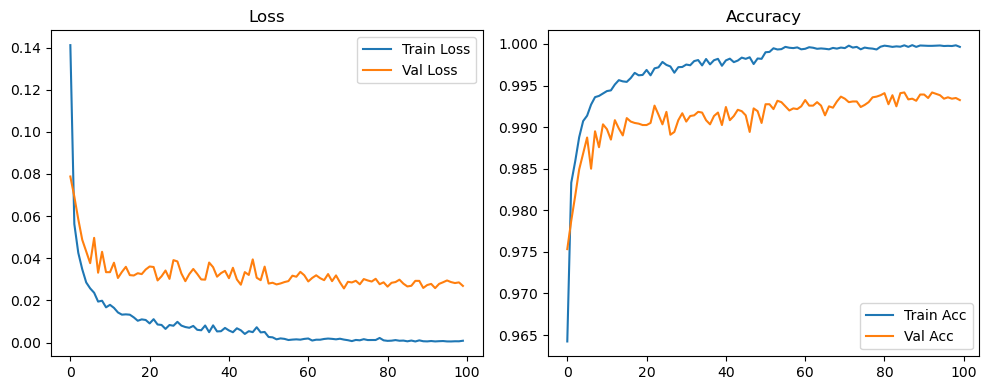

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2370, Acc: 0.9365 | Val Loss: 0.4334, Acc: 0.8498


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1072, Acc: 0.9688 | Val Loss: 0.1828, Acc: 0.9493


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0897, Acc: 0.9731 | Val Loss: 0.1738, Acc: 0.9537


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9754 | Val Loss: 0.1451, Acc: 0.9605


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0681, Acc: 0.9795 | Val Loss: 0.1249, Acc: 0.9623


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9790 | Val Loss: 0.0918, Acc: 0.9787


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9819 | Val Loss: 0.1063, Acc: 0.9723


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9821 | Val Loss: 0.1089, Acc: 0.9721


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9834 | Val Loss: 0.0962, Acc: 0.9764


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9828 | Val Loss: 0.0955, Acc: 0.9753


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9840 | Val Loss: 0.0855, Acc: 0.9791


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9840 | Val Loss: 0.1127, Acc: 0.9708


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9846 | Val Loss: 0.0989, Acc: 0.9776


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.0812, Acc: 0.9838


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9857 | Val Loss: 0.0842, Acc: 0.9802


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0473, Acc: 0.9855 | Val Loss: 0.0841, Acc: 0.9802


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9864 | Val Loss: 0.0931, Acc: 0.9771


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9874 | Val Loss: 0.0984, Acc: 0.9745


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0869, Acc: 0.9798


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9884 | Val Loss: 0.0859, Acc: 0.9790


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.0765, Acc: 0.9836


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9866 | Val Loss: 0.0770, Acc: 0.9848


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9882 | Val Loss: 0.0899, Acc: 0.9776


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9884 | Val Loss: 0.0804, Acc: 0.9827


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9879 | Val Loss: 0.0774, Acc: 0.9825


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9883 | Val Loss: 0.0764, Acc: 0.9827


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.0829, Acc: 0.9792


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.0888, Acc: 0.9750


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9895 | Val Loss: 0.0656, Acc: 0.9834


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9899 | Val Loss: 0.0758, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.1042, Acc: 0.9707


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9892 | Val Loss: 0.1048, Acc: 0.9710


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0786, Acc: 0.9798


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9892 | Val Loss: 0.0869, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.0809, Acc: 0.9794


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0868, Acc: 0.9759


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.0617, Acc: 0.9857


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9902 | Val Loss: 0.0800, Acc: 0.9805


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0843, Acc: 0.9773


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.0692, Acc: 0.9855


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.0779, Acc: 0.9811


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9908 | Val Loss: 0.0754, Acc: 0.9849


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0744, Acc: 0.9818


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9901 | Val Loss: 0.0790, Acc: 0.9828


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0969, Acc: 0.9781


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.1007, Acc: 0.9729


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.0741, Acc: 0.9807


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.0897, Acc: 0.9782


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.0750, Acc: 0.9828


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0858, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0701, Acc: 0.9840


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.0641, Acc: 0.9855


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0560, Acc: 0.9873


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0651, Acc: 0.9837


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0629, Acc: 0.9857


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0711, Acc: 0.9826


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0646, Acc: 0.9836


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0669, Acc: 0.9828


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9937 | Val Loss: 0.0705, Acc: 0.9818


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0628, Acc: 0.9848


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0626, Acc: 0.9863


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.0669, Acc: 0.9832


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0713, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0781, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0736, Acc: 0.9803


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0725, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0795, Acc: 0.9814


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0937, Acc: 0.9777


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.0976, Acc: 0.9748


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0895, Acc: 0.9787


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0831, Acc: 0.9805


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0913, Acc: 0.9783


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0851, Acc: 0.9783


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0806, Acc: 0.9811


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0995, Acc: 0.9764


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0764, Acc: 0.9839


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0722, Acc: 0.9854


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0757, Acc: 0.9849


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0890, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0903, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0765, Acc: 0.9827


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0836, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0872, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0954, Acc: 0.9744


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0848, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0821, Acc: 0.9813


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0820, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0783, Acc: 0.9823


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0743, Acc: 0.9827


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0757, Acc: 0.9814


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0752, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0797, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0650, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0662, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0711, Acc: 0.9807


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0750, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0773, Acc: 0.9815


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0814, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0867, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0709, Acc: 0.9840


Final Test Loss: 0.0687 Accuracy: 0.9831


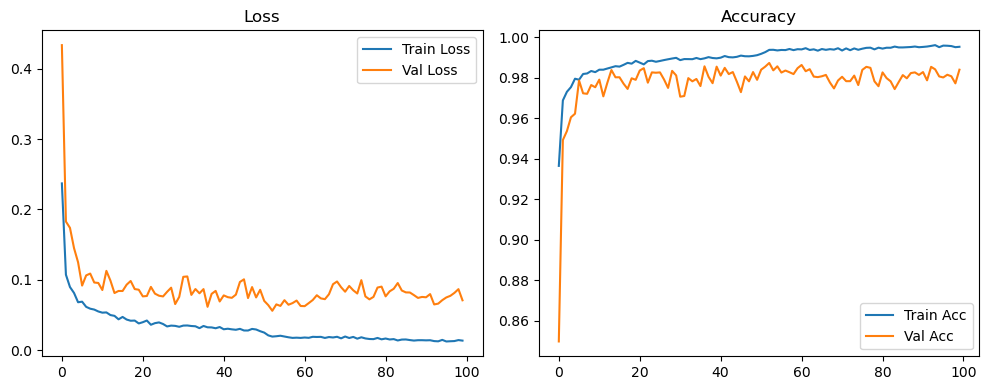

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1440, Acc: 0.9725 | Val Loss: 0.0535, Acc: 0.9839


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9896 | Val Loss: 0.0394, Acc: 0.9880


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9928 | Val Loss: 0.0443, Acc: 0.9869


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0373, Acc: 0.9879


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0330, Acc: 0.9882


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.0307, Acc: 0.9910


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0350, Acc: 0.9898


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0269, Acc: 0.9922


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0449, Acc: 0.9878


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0322, Acc: 0.9911


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0368, Acc: 0.9892


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0369, Acc: 0.9898


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9908


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0361, Acc: 0.9898


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0380, Acc: 0.9902


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0318, Acc: 0.9918


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0348, Acc: 0.9918


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0364, Acc: 0.9919


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0435, Acc: 0.9881


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0376, Acc: 0.9906


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0346, Acc: 0.9918


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0335, Acc: 0.9914


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0361, Acc: 0.9912


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0381, Acc: 0.9912


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0399, Acc: 0.9910


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0313, Acc: 0.9923


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0376, Acc: 0.9897


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0369, Acc: 0.9918


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0353, Acc: 0.9918


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0476, Acc: 0.9899


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0359, Acc: 0.9919


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0350, Acc: 0.9918


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0350, Acc: 0.9927


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0447, Acc: 0.9918


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0481, Acc: 0.9897


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0423, Acc: 0.9914


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0418, Acc: 0.9911


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0367, Acc: 0.9924


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0412, Acc: 0.9926


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0405, Acc: 0.9912


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0442, Acc: 0.9908


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0375, Acc: 0.9922


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0380, Acc: 0.9912


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0420, Acc: 0.9908


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0428, Acc: 0.9908


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0407, Acc: 0.9918


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9920


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0555, Acc: 0.9900


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0456, Acc: 0.9917


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0562, Acc: 0.9899


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0406, Acc: 0.9926


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0382, Acc: 0.9930


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9933


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0478, Acc: 0.9905


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0384, Acc: 0.9928


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0391, Acc: 0.9926


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0386, Acc: 0.9923


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0407, Acc: 0.9920


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0393, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0383, Acc: 0.9928


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0411, Acc: 0.9928


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0494, Acc: 0.9914


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0472, Acc: 0.9914


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0458, Acc: 0.9911


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0458, Acc: 0.9915


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9996 | Val Loss: 0.0431, Acc: 0.9927


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9920


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0416, Acc: 0.9921


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0429, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0463, Acc: 0.9911


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0469, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0492, Acc: 0.9911


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0452, Acc: 0.9915


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0493, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0436, Acc: 0.9920


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0446, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0466, Acc: 0.9918


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0422, Acc: 0.9927


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0461, Acc: 0.9920


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0430, Acc: 0.9923


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9928


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9922


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9935


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9928


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9928


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9928


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9931


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9932


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9936


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9930


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9938


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0468, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0425, Acc: 0.9926


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0392, Acc: 0.9929


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9923


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0439, Acc: 0.9921


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0475, Acc: 0.9923


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0489, Acc: 0.9911


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0457, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0477, Acc: 0.9921


Final Test Loss: 0.0418 Accuracy: 0.9939


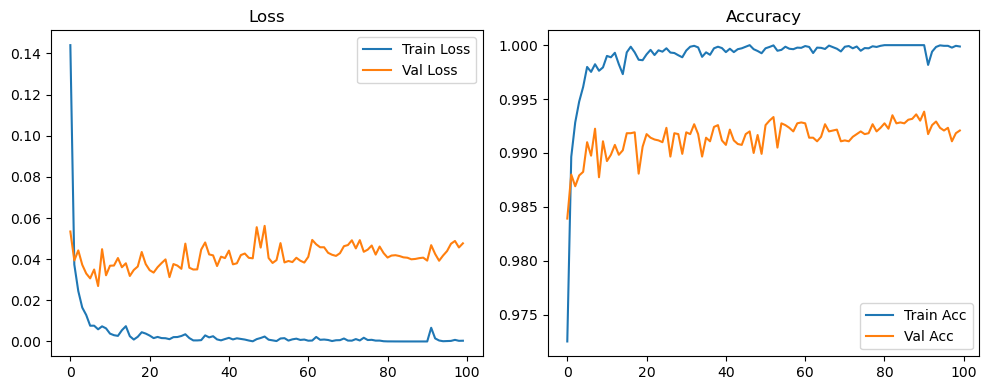

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1738, Acc: 0.9660 | Val Loss: 0.1024, Acc: 0.9718


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9838 | Val Loss: 0.0664, Acc: 0.9812


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0639, Acc: 0.9807


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9903 | Val Loss: 0.0475, Acc: 0.9854


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0395, Acc: 0.9874


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.0426, Acc: 0.9872


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9931 | Val Loss: 0.0458, Acc: 0.9858


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0378, Acc: 0.9879


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0382, Acc: 0.9882


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0312, Acc: 0.9912


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0377, Acc: 0.9895


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0322, Acc: 0.9903


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0281, Acc: 0.9915


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0309, Acc: 0.9904


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0293, Acc: 0.9909


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0302, Acc: 0.9915


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0343, Acc: 0.9906


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0369, Acc: 0.9888


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0304, Acc: 0.9912


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0317, Acc: 0.9911


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0292, Acc: 0.9917


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0352, Acc: 0.9910


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0279, Acc: 0.9922


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0264, Acc: 0.9928


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0292, Acc: 0.9917


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0295, Acc: 0.9913


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0284, Acc: 0.9923


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0285, Acc: 0.9922


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0246, Acc: 0.9935


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0325, Acc: 0.9922


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0319, Acc: 0.9919


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0300, Acc: 0.9922


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0281, Acc: 0.9930


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0278, Acc: 0.9929


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0306, Acc: 0.9927


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0340, Acc: 0.9915


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0366, Acc: 0.9915


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0327, Acc: 0.9912


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0364, Acc: 0.9912


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0271, Acc: 0.9929


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0280, Acc: 0.9923


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0314, Acc: 0.9919


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0307, Acc: 0.9920


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0306, Acc: 0.9920


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0304, Acc: 0.9922


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0303, Acc: 0.9919


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0345, Acc: 0.9916


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0299, Acc: 0.9926


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0353, Acc: 0.9921


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0326, Acc: 0.9912


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0329, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0349, Acc: 0.9920


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0341, Acc: 0.9916


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0310, Acc: 0.9924


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0358, Acc: 0.9913


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0382, Acc: 0.9909


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0359, Acc: 0.9915


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0302, Acc: 0.9931


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0377, Acc: 0.9903


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0330, Acc: 0.9926


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0319, Acc: 0.9922


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0306, Acc: 0.9922


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9919


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0300, Acc: 0.9931


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0299, Acc: 0.9934


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0315, Acc: 0.9928


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0297, Acc: 0.9925


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0329, Acc: 0.9916


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0343, Acc: 0.9915


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0327, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0287, Acc: 0.9929


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0319, Acc: 0.9925


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0293, Acc: 0.9931


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0279, Acc: 0.9928


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0292, Acc: 0.9935


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0302, Acc: 0.9933


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0296, Acc: 0.9928


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0321, Acc: 0.9926


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0315, Acc: 0.9930


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0310, Acc: 0.9930


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0293, Acc: 0.9929


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0320, Acc: 0.9923


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0296, Acc: 0.9928


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0314, Acc: 0.9925


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0314, Acc: 0.9928


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0285, Acc: 0.9932


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0267, Acc: 0.9933


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0315, Acc: 0.9922


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0340, Acc: 0.9912


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0299, Acc: 0.9924


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0314, Acc: 0.9925


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0365, Acc: 0.9917


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0336, Acc: 0.9919


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0301, Acc: 0.9938


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0349, Acc: 0.9925


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9921


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0337, Acc: 0.9927


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0313, Acc: 0.9925


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0270, Acc: 0.9934


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0319, Acc: 0.9924


Final Test Loss: 0.0293 Accuracy: 0.9924


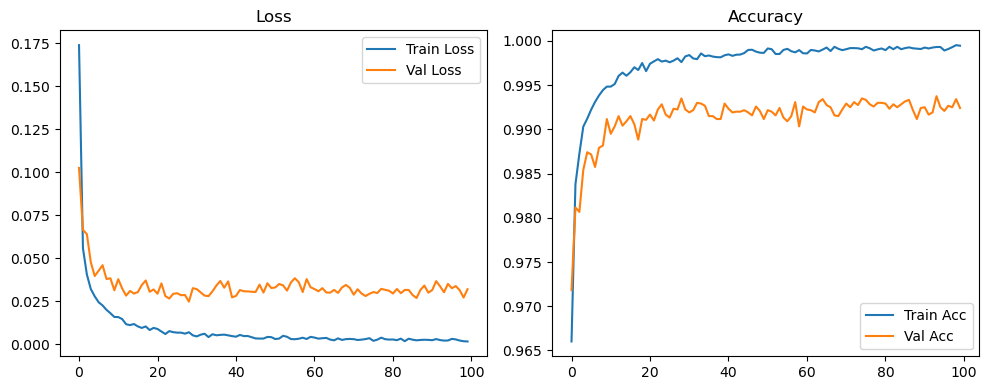

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2812, Acc: 0.9360 | Val Loss: 0.6268, Acc: 0.7625


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1118, Acc: 0.9682 | Val Loss: 0.2947, Acc: 0.8922


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0892, Acc: 0.9748 | Val Loss: 0.1808, Acc: 0.9503


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0798, Acc: 0.9766 | Val Loss: 0.1557, Acc: 0.9543


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9792 | Val Loss: 0.0919, Acc: 0.9738


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9798 | Val Loss: 0.0811, Acc: 0.9788


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9821 | Val Loss: 0.1108, Acc: 0.9686


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9830 | Val Loss: 0.0830, Acc: 0.9795


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9844 | Val Loss: 0.0801, Acc: 0.9788


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 0.0762, Acc: 0.9786


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9844 | Val Loss: 0.0844, Acc: 0.9793


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9855 | Val Loss: 0.0791, Acc: 0.9799


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9854 | Val Loss: 0.0694, Acc: 0.9829


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9870 | Val Loss: 0.0646, Acc: 0.9835


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 0.0544, Acc: 0.9859


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9862 | Val Loss: 0.0601, Acc: 0.9849


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9874 | Val Loss: 0.0661, Acc: 0.9816


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9874 | Val Loss: 0.0618, Acc: 0.9838


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9876 | Val Loss: 0.0734, Acc: 0.9818


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9885 | Val Loss: 0.0702, Acc: 0.9842


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.0639, Acc: 0.9846


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0670, Acc: 0.9848


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9891 | Val Loss: 0.0629, Acc: 0.9849


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.0617, Acc: 0.9861


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9887 | Val Loss: 0.0629, Acc: 0.9869


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.0592, Acc: 0.9875


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0571, Acc: 0.9852


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9899 | Val Loss: 0.0629, Acc: 0.9827


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0581, Acc: 0.9867


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0591, Acc: 0.9874


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.0611, Acc: 0.9841


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9903 | Val Loss: 0.0715, Acc: 0.9808


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9899 | Val Loss: 0.0619, Acc: 0.9857


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.0550, Acc: 0.9867


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.0531, Acc: 0.9870


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 0.0580, Acc: 0.9852


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9909 | Val Loss: 0.0604, Acc: 0.9860


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9912 | Val Loss: 0.0547, Acc: 0.9882


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0619, Acc: 0.9862


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.0589, Acc: 0.9860


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0634, Acc: 0.9842


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0690, Acc: 0.9838


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9917 | Val Loss: 0.0627, Acc: 0.9834


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9925 | Val Loss: 0.0720, Acc: 0.9831


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.0629, Acc: 0.9845


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0616, Acc: 0.9858


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0625, Acc: 0.9856


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9922 | Val Loss: 0.0564, Acc: 0.9878


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.0635, Acc: 0.9850


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.0895, Acc: 0.9806


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0651, Acc: 0.9871


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0610, Acc: 0.9872


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0683, Acc: 0.9861


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.0714, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0687, Acc: 0.9866


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0667, Acc: 0.9866


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.0700, Acc: 0.9828


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0702, Acc: 0.9841


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0645, Acc: 0.9850


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0527, Acc: 0.9883


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0539, Acc: 0.9888


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0701, Acc: 0.9841


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0664, Acc: 0.9844


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.0610, Acc: 0.9852


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0538, Acc: 0.9862


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0771, Acc: 0.9827


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0647, Acc: 0.9855


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0710, Acc: 0.9855


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0708, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0677, Acc: 0.9858


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0793, Acc: 0.9828


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9935 | Val Loss: 0.0768, Acc: 0.9840


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0679, Acc: 0.9855


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9926 | Val Loss: 0.0747, Acc: 0.9832


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0781, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0681, Acc: 0.9859


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0884, Acc: 0.9826


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0836, Acc: 0.9847


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0684, Acc: 0.9850


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0572, Acc: 0.9882


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0604, Acc: 0.9863


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0623, Acc: 0.9854


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0592, Acc: 0.9864


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0634, Acc: 0.9856


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0709, Acc: 0.9865


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0839, Acc: 0.9838


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.0614, Acc: 0.9874


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0797, Acc: 0.9843


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.0771, Acc: 0.9832


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0910, Acc: 0.9808


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0702, Acc: 0.9845


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.0701, Acc: 0.9842


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0685, Acc: 0.9871


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0582, Acc: 0.9877


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.0655, Acc: 0.9843


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0688, Acc: 0.9847


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0861, Acc: 0.9830


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0742, Acc: 0.9849


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0771, Acc: 0.9837


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9932 | Val Loss: 0.0856, Acc: 0.9842


Final Test Loss: 0.0824 Accuracy: 0.9837


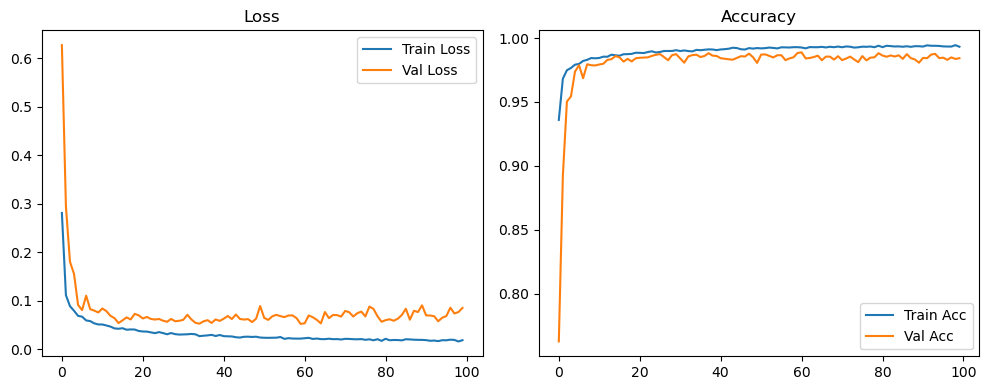

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1932, Acc: 0.9708 | Val Loss: 0.0625, Acc: 0.9833


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9898 | Val Loss: 0.0506, Acc: 0.9851


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9938 | Val Loss: 0.0496, Acc: 0.9858


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9956 | Val Loss: 0.0365, Acc: 0.9888


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9967 | Val Loss: 0.0340, Acc: 0.9895


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9978 | Val Loss: 0.0378, Acc: 0.9872


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.0335, Acc: 0.9898


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.0384, Acc: 0.9892


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9991 | Val Loss: 0.0376, Acc: 0.9890


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.0362, Acc: 0.9896


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0451, Acc: 0.9866


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9993 | Val Loss: 0.0354, Acc: 0.9897


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.0312, Acc: 0.9910


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0352, Acc: 0.9908


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0382, Acc: 0.9907


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0410, Acc: 0.9889


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0333, Acc: 0.9906


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0389, Acc: 0.9902


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0351, Acc: 0.9911


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0343, Acc: 0.9918


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0333, Acc: 0.9916


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0344, Acc: 0.9909


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0383, Acc: 0.9897


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0420, Acc: 0.9896


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0385, Acc: 0.9902


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0379, Acc: 0.9907


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0403, Acc: 0.9902


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0330, Acc: 0.9915


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9925


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9922


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9926


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9930


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9923


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9928


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9928


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9928


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9926


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9922


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0474, Acc: 0.9892


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0363, Acc: 0.9918


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0368, Acc: 0.9916


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9923


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9928


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9930


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9928


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9929


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9928


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9927


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9925


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9930


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9926


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9922


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9927


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9911


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0394, Acc: 0.9915


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0346, Acc: 0.9917


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9922


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9924


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9926


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9927


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9927


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9929


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9926


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9930


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9923


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9927


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0533, Acc: 0.9886


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0337, Acc: 0.9912


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0354, Acc: 0.9912


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0351, Acc: 0.9917


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0357, Acc: 0.9926


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0335, Acc: 0.9928


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9929


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9931


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9932


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9923


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9932


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9932


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9929


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9929


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9931


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9930


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0535, Acc: 0.9877


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0395, Acc: 0.9913


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0377, Acc: 0.9918


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9926


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0374, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0391, Acc: 0.9920


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0366, Acc: 0.9919


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9924


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0503, Acc: 0.9886


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0412, Acc: 0.9911


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0424, Acc: 0.9923


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0411, Acc: 0.9917


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0383, Acc: 0.9924


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0380, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9928


Final Test Loss: 0.0369 Accuracy: 0.9922


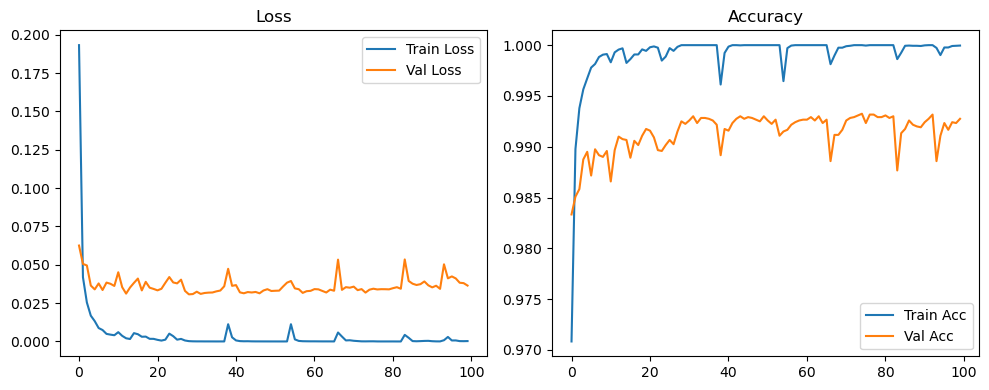

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2320, Acc: 0.9633 | Val Loss: 0.1345, Acc: 0.9693


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9840 | Val Loss: 0.0746, Acc: 0.9818


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9880 | Val Loss: 0.0642, Acc: 0.9828


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9901 | Val Loss: 0.0480, Acc: 0.9866


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9915 | Val Loss: 0.0474, Acc: 0.9859


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0547, Acc: 0.9832


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.0392, Acc: 0.9880


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0371, Acc: 0.9888


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0376, Acc: 0.9887


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.0306, Acc: 0.9909


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9954 | Val Loss: 0.0362, Acc: 0.9885


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0320, Acc: 0.9910


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0301, Acc: 0.9917


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0266, Acc: 0.9917


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0325, Acc: 0.9902


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0308, Acc: 0.9912


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0318, Acc: 0.9908


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0347, Acc: 0.9895


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0288, Acc: 0.9910


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0317, Acc: 0.9908


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0336, Acc: 0.9906


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0302, Acc: 0.9910


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0289, Acc: 0.9917


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0304, Acc: 0.9912


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0296, Acc: 0.9924


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0282, Acc: 0.9920


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0276, Acc: 0.9931


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0281, Acc: 0.9928


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0301, Acc: 0.9912


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0315, Acc: 0.9918


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0276, Acc: 0.9929


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0259, Acc: 0.9935


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0298, Acc: 0.9912


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0287, Acc: 0.9912


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0288, Acc: 0.9915


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0339, Acc: 0.9904


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0320, Acc: 0.9913


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0269, Acc: 0.9928


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0282, Acc: 0.9922


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0306, Acc: 0.9922


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0305, Acc: 0.9918


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0307, Acc: 0.9921


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0280, Acc: 0.9930


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0282, Acc: 0.9928


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0344, Acc: 0.9908


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0304, Acc: 0.9921


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0339, Acc: 0.9911


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0318, Acc: 0.9922


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0313, Acc: 0.9929


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0310, Acc: 0.9918


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0318, Acc: 0.9918


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0279, Acc: 0.9932


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0280, Acc: 0.9929


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0303, Acc: 0.9930


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0358, Acc: 0.9918


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0296, Acc: 0.9927


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0301, Acc: 0.9928


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0314, Acc: 0.9921


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0327, Acc: 0.9918


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0299, Acc: 0.9925


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0330, Acc: 0.9923


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0312, Acc: 0.9918


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0299, Acc: 0.9922


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0297, Acc: 0.9929


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0306, Acc: 0.9929


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0298, Acc: 0.9925


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0281, Acc: 0.9932


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0297, Acc: 0.9929


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0315, Acc: 0.9930


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0287, Acc: 0.9925


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0311, Acc: 0.9925


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0310, Acc: 0.9919


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0333, Acc: 0.9928


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0320, Acc: 0.9919


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0307, Acc: 0.9928


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0318, Acc: 0.9920


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0310, Acc: 0.9920


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0295, Acc: 0.9929


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0315, Acc: 0.9922


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0306, Acc: 0.9926


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0308, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0354, Acc: 0.9920


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0332, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0326, Acc: 0.9933


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0296, Acc: 0.9930


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0302, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0326, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0312, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0307, Acc: 0.9930


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0309, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0285, Acc: 0.9924


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.0304, Acc: 0.9921


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0303, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0354, Acc: 0.9911


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0331, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0309, Acc: 0.9926


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0305, Acc: 0.9922


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0294, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0318, Acc: 0.9918


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0285, Acc: 0.9930


Final Test Loss: 0.0273 Accuracy: 0.9926


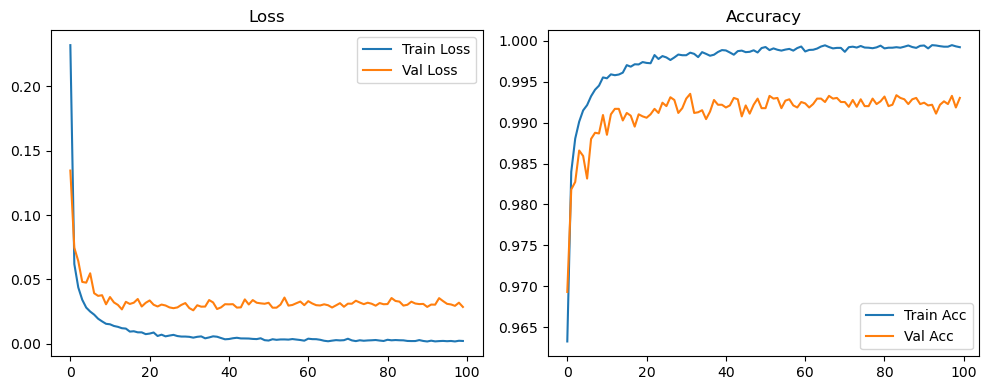

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3619, Acc: 0.9304 | Val Loss: 0.6962, Acc: 0.7375


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1253, Acc: 0.9674 | Val Loss: 0.3850, Acc: 0.8573


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0973, Acc: 0.9732 | Val Loss: 0.2317, Acc: 0.9320


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0842, Acc: 0.9759 | Val Loss: 0.1377, Acc: 0.9675


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0735, Acc: 0.9785 | Val Loss: 0.1163, Acc: 0.9712


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0711, Acc: 0.9787 | Val Loss: 0.1209, Acc: 0.9693


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9817 | Val Loss: 0.1457, Acc: 0.9562


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0607, Acc: 0.9822 | Val Loss: 0.1002, Acc: 0.9731


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0574, Acc: 0.9835 | Val Loss: 0.1036, Acc: 0.9719


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9841 | Val Loss: 0.0752, Acc: 0.9808


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 0.0907, Acc: 0.9768


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9842 | Val Loss: 0.0746, Acc: 0.9827


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9849 | Val Loss: 0.0779, Acc: 0.9800


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9866 | Val Loss: 0.0602, Acc: 0.9867


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 0.0483, Acc: 0.9895


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9865 | Val Loss: 0.0538, Acc: 0.9882


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.0626, Acc: 0.9833


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9872 | Val Loss: 0.0606, Acc: 0.9852


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9873 | Val Loss: 0.0620, Acc: 0.9853


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0584, Acc: 0.9854


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0487, Acc: 0.9883


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9885 | Val Loss: 0.0508, Acc: 0.9892


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9887 | Val Loss: 0.0466, Acc: 0.9892


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9893 | Val Loss: 0.0486, Acc: 0.9891


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9894 | Val Loss: 0.0489, Acc: 0.9896


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9890 | Val Loss: 0.0490, Acc: 0.9897


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.0453, Acc: 0.9906


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9899 | Val Loss: 0.0446, Acc: 0.9896


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0440, Acc: 0.9901


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9904 | Val Loss: 0.0474, Acc: 0.9892


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9903 | Val Loss: 0.0438, Acc: 0.9898


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9906 | Val Loss: 0.0418, Acc: 0.9912


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9901 | Val Loss: 0.0512, Acc: 0.9881


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.0550, Acc: 0.9867


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0528, Acc: 0.9878


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.0464, Acc: 0.9889


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.0467, Acc: 0.9902


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.0452, Acc: 0.9917


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.0452, Acc: 0.9901


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.0441, Acc: 0.9902


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0490, Acc: 0.9888


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0448, Acc: 0.9897


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.0422, Acc: 0.9906


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0552, Acc: 0.9880


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0493, Acc: 0.9893


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0497, Acc: 0.9881


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0459, Acc: 0.9900


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.0494, Acc: 0.9892


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9926 | Val Loss: 0.0507, Acc: 0.9882


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0560, Acc: 0.9872


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.0409, Acc: 0.9909


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.0435, Acc: 0.9914


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.0457, Acc: 0.9925


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9923 | Val Loss: 0.0522, Acc: 0.9899


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0578, Acc: 0.9867


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0539, Acc: 0.9882


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0509, Acc: 0.9884


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0628, Acc: 0.9849


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0426, Acc: 0.9908


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0464, Acc: 0.9903


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0455, Acc: 0.9911


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0483, Acc: 0.9891


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.0474, Acc: 0.9903


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0460, Acc: 0.9894


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0430, Acc: 0.9894


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0431, Acc: 0.9915


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0474, Acc: 0.9899


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0496, Acc: 0.9892


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0639, Acc: 0.9856


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0507, Acc: 0.9899


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9932 | Val Loss: 0.0547, Acc: 0.9882


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.0540, Acc: 0.9910


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0532, Acc: 0.9898


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0521, Acc: 0.9911


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0536, Acc: 0.9885


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0488, Acc: 0.9916


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0520, Acc: 0.9893


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9936 | Val Loss: 0.0521, Acc: 0.9908


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0569, Acc: 0.9892


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0553, Acc: 0.9886


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0536, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0544, Acc: 0.9883


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9941 | Val Loss: 0.0487, Acc: 0.9908


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0581, Acc: 0.9885


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0634, Acc: 0.9881


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0633, Acc: 0.9891


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0562, Acc: 0.9896


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0599, Acc: 0.9892


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.0629, Acc: 0.9902


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0563, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0614, Acc: 0.9888


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0631, Acc: 0.9875


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0738, Acc: 0.9891


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0678, Acc: 0.9867


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0740, Acc: 0.9864


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0650, Acc: 0.9882


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0900, Acc: 0.9855


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0721, Acc: 0.9898


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0866, Acc: 0.9861


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9939 | Val Loss: 0.0744, Acc: 0.9892


Final Test Loss: 0.0721 Accuracy: 0.9873


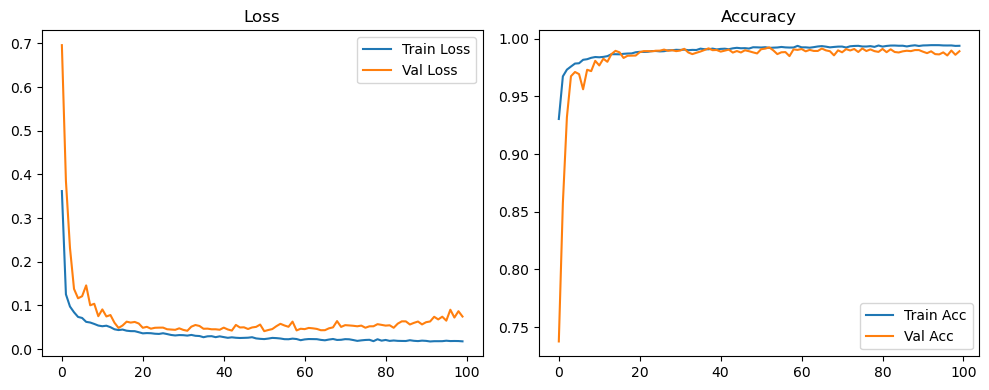

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1373, Acc: 0.9624 | Val Loss: 0.0558, Acc: 0.9838


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9884 | Val Loss: 0.0511, Acc: 0.9838


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0404, Acc: 0.9882


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0704, Acc: 0.9790


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0397, Acc: 0.9868


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0392, Acc: 0.9894


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0386, Acc: 0.9891


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0416, Acc: 0.9889


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0552, Acc: 0.9868


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9967 | Val Loss: 0.0445, Acc: 0.9879


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0441, Acc: 0.9888


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0413, Acc: 0.9902


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0544, Acc: 0.9873


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0718, Acc: 0.9834


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0443, Acc: 0.9906


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0383, Acc: 0.9918


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0414, Acc: 0.9904


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0479, Acc: 0.9895


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0437, Acc: 0.9909


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0509, Acc: 0.9888


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0656, Acc: 0.9864


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0465, Acc: 0.9901


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0413, Acc: 0.9921


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0473, Acc: 0.9903


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9913


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0429, Acc: 0.9907


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0427, Acc: 0.9922


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0643, Acc: 0.9874


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0600, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0538, Acc: 0.9889


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0511, Acc: 0.9904


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0518, Acc: 0.9901


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0446, Acc: 0.9912


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0449, Acc: 0.9915


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9926


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9932


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9932


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9930


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9934


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9932


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9934


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9931


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0552, Acc: 0.9889


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9937 | Val Loss: 0.0490, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0455, Acc: 0.9905


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0389, Acc: 0.9920


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0341, Acc: 0.9926


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0355, Acc: 0.9923


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9927


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9928


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9929


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9929


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0626, Acc: 0.9890


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.0543, Acc: 0.9902


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0497, Acc: 0.9898


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0463, Acc: 0.9910


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0431, Acc: 0.9918


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0475, Acc: 0.9916


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9928


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0460, Acc: 0.9915


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9922


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0667, Acc: 0.9883


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0514, Acc: 0.9914


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0513, Acc: 0.9903


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0522, Acc: 0.9916


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0468, Acc: 0.9909


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0414, Acc: 0.9920


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9919


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0667, Acc: 0.9898


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0501, Acc: 0.9908


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0496, Acc: 0.9914


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0467, Acc: 0.9927


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0460, Acc: 0.9929


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0519, Acc: 0.9917


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0547, Acc: 0.9908


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0611, Acc: 0.9908


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0550, Acc: 0.9916


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0622, Acc: 0.9912


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0544, Acc: 0.9927


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0560, Acc: 0.9918


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0550, Acc: 0.9927


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0607, Acc: 0.9905


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0569, Acc: 0.9920


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0588, Acc: 0.9909


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0537, Acc: 0.9918


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0517, Acc: 0.9929


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0598, Acc: 0.9912


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0575, Acc: 0.9927


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0645, Acc: 0.9904


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0731, Acc: 0.9906


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0666, Acc: 0.9918


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0656, Acc: 0.9912


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0632, Acc: 0.9918


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0650, Acc: 0.9916


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0650, Acc: 0.9912


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0650, Acc: 0.9920


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0704, Acc: 0.9908


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0738, Acc: 0.9907


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0684, Acc: 0.9908


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0657, Acc: 0.9912


Final Test Loss: 0.0513 Accuracy: 0.9922


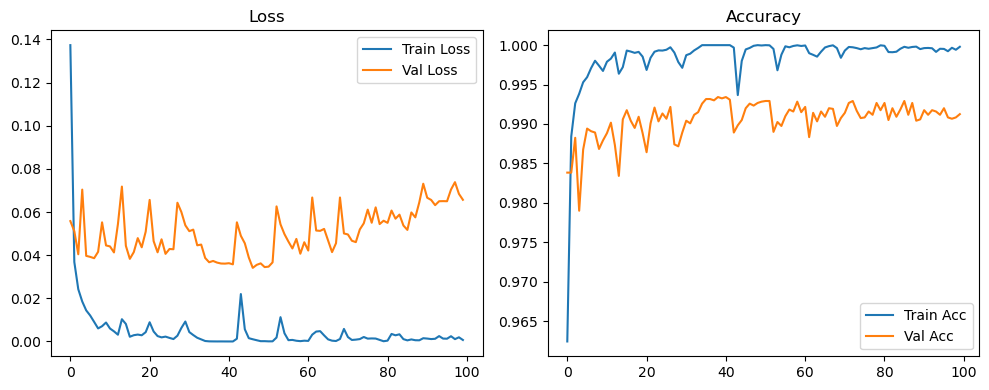

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1631, Acc: 0.9553 | Val Loss: 0.1876, Acc: 0.9384


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9837 | Val Loss: 0.0683, Acc: 0.9794


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.0746, Acc: 0.9768


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0525, Acc: 0.9842


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.0497, Acc: 0.9842


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0433, Acc: 0.9872


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0437, Acc: 0.9868


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0399, Acc: 0.9888


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9932 | Val Loss: 0.0466, Acc: 0.9869


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0402, Acc: 0.9886


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0366, Acc: 0.9896


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0398, Acc: 0.9874


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0368, Acc: 0.9892


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0387, Acc: 0.9887


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0362, Acc: 0.9899


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0324, Acc: 0.9910


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0358, Acc: 0.9901


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0388, Acc: 0.9891


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0377, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0375, Acc: 0.9894


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0449, Acc: 0.9874


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0477, Acc: 0.9862


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0406, Acc: 0.9889


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0378, Acc: 0.9888


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0489, Acc: 0.9875


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0375, Acc: 0.9898


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0360, Acc: 0.9902


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0355, Acc: 0.9901


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0347, Acc: 0.9912


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0301, Acc: 0.9918


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0485, Acc: 0.9878


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0348, Acc: 0.9906


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0347, Acc: 0.9914


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0347, Acc: 0.9917


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0391, Acc: 0.9912


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0325, Acc: 0.9905


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0310, Acc: 0.9911


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0289, Acc: 0.9923


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0348, Acc: 0.9919


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0320, Acc: 0.9917


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0373, Acc: 0.9913


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0316, Acc: 0.9927


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0352, Acc: 0.9918


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0287, Acc: 0.9928


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0319, Acc: 0.9924


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0337, Acc: 0.9922


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0345, Acc: 0.9917


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0330, Acc: 0.9918


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0357, Acc: 0.9908


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0382, Acc: 0.9902


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0361, Acc: 0.9915


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0420, Acc: 0.9906


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0332, Acc: 0.9919


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0344, Acc: 0.9914


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0393, Acc: 0.9907


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0359, Acc: 0.9914


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0357, Acc: 0.9916


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0469, Acc: 0.9881


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0353, Acc: 0.9911


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0356, Acc: 0.9913


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0394, Acc: 0.9897


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0348, Acc: 0.9917


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0320, Acc: 0.9925


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0396, Acc: 0.9908


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9975 | Val Loss: 0.0405, Acc: 0.9909


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0389, Acc: 0.9897


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0373, Acc: 0.9911


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0315, Acc: 0.9930


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0408, Acc: 0.9902


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0358, Acc: 0.9912


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0336, Acc: 0.9918


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0297, Acc: 0.9912


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0395, Acc: 0.9912


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0363, Acc: 0.9926


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0444, Acc: 0.9895


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0381, Acc: 0.9913


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0381, Acc: 0.9909


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0317, Acc: 0.9919


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0359, Acc: 0.9908


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0332, Acc: 0.9921


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0376, Acc: 0.9909


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0420, Acc: 0.9904


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0367, Acc: 0.9916


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0403, Acc: 0.9908


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0374, Acc: 0.9908


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0343, Acc: 0.9915


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0361, Acc: 0.9915


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0377, Acc: 0.9908


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0428, Acc: 0.9912


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0448, Acc: 0.9900


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0398, Acc: 0.9907


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0394, Acc: 0.9897


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0382, Acc: 0.9915


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0386, Acc: 0.9899


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0413, Acc: 0.9902


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0367, Acc: 0.9911


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0337, Acc: 0.9918


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9908


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0413, Acc: 0.9896


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0361, Acc: 0.9909


Final Test Loss: 0.0347 Accuracy: 0.9912


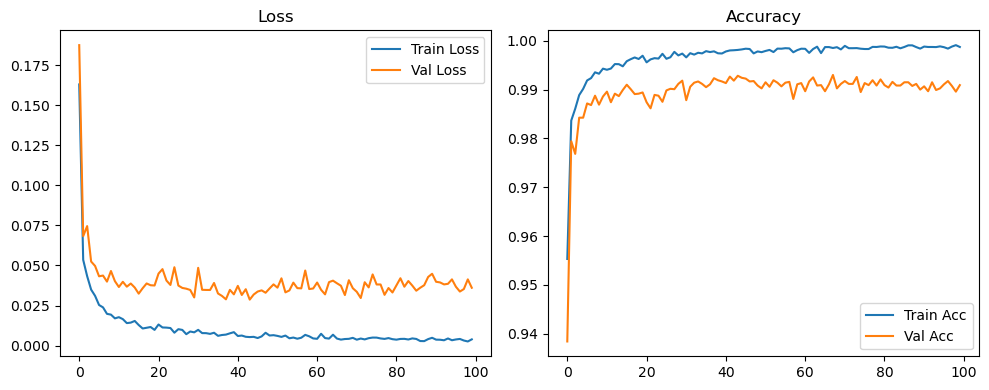

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2555, Acc: 0.9284 | Val Loss: 0.5892, Acc: 0.7891


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1100, Acc: 0.9676 | Val Loss: 0.2154, Acc: 0.9367


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0888, Acc: 0.9735 | Val Loss: 0.1706, Acc: 0.9499


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9752 | Val Loss: 0.1073, Acc: 0.9764


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9773 | Val Loss: 0.1321, Acc: 0.9657


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9796 | Val Loss: 0.1064, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9799 | Val Loss: 0.0744, Acc: 0.9825


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9811 | Val Loss: 0.1000, Acc: 0.9752


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9825 | Val Loss: 0.1148, Acc: 0.9708


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9831 | Val Loss: 0.0934, Acc: 0.9747


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9838 | Val Loss: 0.1187, Acc: 0.9696


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9844 | Val Loss: 0.0876, Acc: 0.9780


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9844 | Val Loss: 0.0720, Acc: 0.9815


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.0630, Acc: 0.9874


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9856 | Val Loss: 0.0791, Acc: 0.9782


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9867 | Val Loss: 0.0630, Acc: 0.9838


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9863 | Val Loss: 0.0902, Acc: 0.9763


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.0679, Acc: 0.9843


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 0.0518, Acc: 0.9871


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.0648, Acc: 0.9852


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9869 | Val Loss: 0.0638, Acc: 0.9838


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9880 | Val Loss: 0.0657, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.0692, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.0651, Acc: 0.9838


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0644, Acc: 0.9822


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.0552, Acc: 0.9858


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9880 | Val Loss: 0.0583, Acc: 0.9874


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.0573, Acc: 0.9852


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9891 | Val Loss: 0.0581, Acc: 0.9857


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9896 | Val Loss: 0.0541, Acc: 0.9865


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0568, Acc: 0.9832


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0620, Acc: 0.9842


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0487, Acc: 0.9881


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0486, Acc: 0.9870


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.0466, Acc: 0.9880


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.0546, Acc: 0.9841


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.0478, Acc: 0.9876


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.0543, Acc: 0.9868


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0507, Acc: 0.9875


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.0491, Acc: 0.9871


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.0634, Acc: 0.9848


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0514, Acc: 0.9881


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0463, Acc: 0.9872


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.0477, Acc: 0.9896


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0621, Acc: 0.9831


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9907 | Val Loss: 0.0468, Acc: 0.9881


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0473, Acc: 0.9882


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0462, Acc: 0.9874


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.0426, Acc: 0.9874


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.0440, Acc: 0.9899


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0424, Acc: 0.9881


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9921 | Val Loss: 0.0452, Acc: 0.9880


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.0449, Acc: 0.9899


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.0557, Acc: 0.9848


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0523, Acc: 0.9873


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0412, Acc: 0.9898


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0438, Acc: 0.9891


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.0512, Acc: 0.9887


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0547, Acc: 0.9864


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.0520, Acc: 0.9855


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0551, Acc: 0.9846


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.0505, Acc: 0.9882


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0458, Acc: 0.9894


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9911 | Val Loss: 0.0511, Acc: 0.9858


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9921 | Val Loss: 0.0527, Acc: 0.9862


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0538, Acc: 0.9872


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0604, Acc: 0.9851


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.0524, Acc: 0.9879


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.0477, Acc: 0.9892


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0608, Acc: 0.9852


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0523, Acc: 0.9864


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0513, Acc: 0.9888


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0404, Acc: 0.9892


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0431, Acc: 0.9903


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.0498, Acc: 0.9872


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.0441, Acc: 0.9902


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0446, Acc: 0.9908


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0593, Acc: 0.9860


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.0541, Acc: 0.9862


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0458, Acc: 0.9912


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0438, Acc: 0.9892


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.0557, Acc: 0.9867


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0542, Acc: 0.9883


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0438, Acc: 0.9901


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9920 | Val Loss: 0.0483, Acc: 0.9886


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0511, Acc: 0.9882


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0440, Acc: 0.9898


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0484, Acc: 0.9892


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0444, Acc: 0.9892


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.0514, Acc: 0.9888


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0451, Acc: 0.9886


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0448, Acc: 0.9898


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0412, Acc: 0.9898


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9928 | Val Loss: 0.0573, Acc: 0.9866


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0621, Acc: 0.9862


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0501, Acc: 0.9884


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0386, Acc: 0.9908


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.0409, Acc: 0.9902


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0439, Acc: 0.9896


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0446, Acc: 0.9901


Final Test Loss: 0.0413 Accuracy: 0.9915


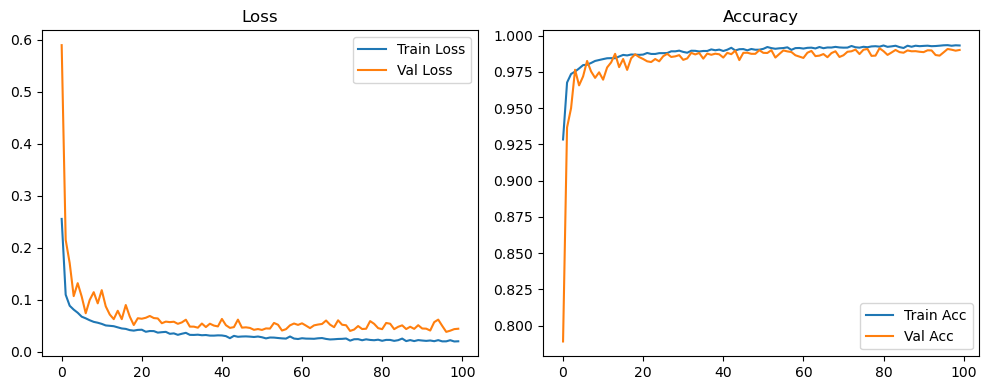

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1375, Acc: 0.9621 | Val Loss: 0.0588, Acc: 0.9828


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.0430, Acc: 0.9861


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0598, Acc: 0.9824


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0501, Acc: 0.9845


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0384, Acc: 0.9892


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0545, Acc: 0.9838


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0402, Acc: 0.9877


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0345, Acc: 0.9912


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0633, Acc: 0.9858


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0379, Acc: 0.9902


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0490, Acc: 0.9880


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0632, Acc: 0.9839


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0429, Acc: 0.9897


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0450, Acc: 0.9892


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0471, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0598, Acc: 0.9871


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0420, Acc: 0.9905


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0411, Acc: 0.9903


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0396, Acc: 0.9909


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0545, Acc: 0.9883


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0529, Acc: 0.9889


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0478, Acc: 0.9907


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0519, Acc: 0.9895


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0541, Acc: 0.9904


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0560, Acc: 0.9888


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9981 | Val Loss: 0.0495, Acc: 0.9905


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0466, Acc: 0.9903


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0393, Acc: 0.9917


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9908


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0603, Acc: 0.9898


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0571, Acc: 0.9902


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0511, Acc: 0.9904


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0536, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0597, Acc: 0.9894


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0644, Acc: 0.9875


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0559, Acc: 0.9894


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0564, Acc: 0.9897


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0512, Acc: 0.9908


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0463, Acc: 0.9917


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0487, Acc: 0.9921


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.0731, Acc: 0.9868


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0524, Acc: 0.9909


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0507, Acc: 0.9907


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0481, Acc: 0.9915


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0452, Acc: 0.9923


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9925


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9927


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9926


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9925


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9917


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9922


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9922


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9924


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9925


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9927


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9925


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9930


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9927


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9923


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9929


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9928


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.0601, Acc: 0.9888


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0444, Acc: 0.9916


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0468, Acc: 0.9914


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0444, Acc: 0.9920


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9920


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9924


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9923


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9927


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9926


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9927


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9927


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9926


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9926


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9925


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9925


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9928


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9928


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9926


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9926


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9924


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9928


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9927


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9927


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9926


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9927


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9926


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9926


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9928


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9927


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9926


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9927


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9928


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9927


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9928


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9927


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9931


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9926


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9925


Final Test Loss: 0.0318 Accuracy: 0.9943


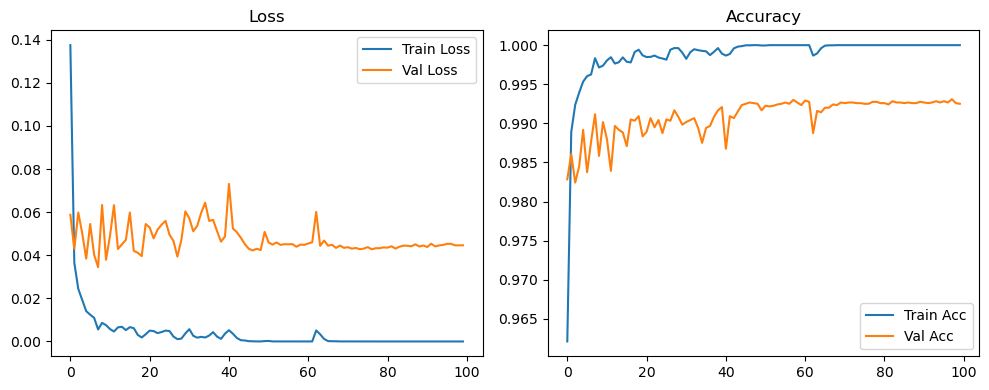

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1635, Acc: 0.9554 | Val Loss: 0.1553, Acc: 0.9507


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9834 | Val Loss: 0.0628, Acc: 0.9810


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9868 | Val Loss: 0.0516, Acc: 0.9844


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9892 | Val Loss: 0.0526, Acc: 0.9839


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.0577, Acc: 0.9822


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.0420, Acc: 0.9877


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.0394, Acc: 0.9882


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0375, Acc: 0.9890


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.0682, Acc: 0.9811


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9939 | Val Loss: 0.0319, Acc: 0.9911


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0492, Acc: 0.9850


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0360, Acc: 0.9896


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0360, Acc: 0.9898


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0363, Acc: 0.9901


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0354, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0437, Acc: 0.9873


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.0376, Acc: 0.9891


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0497, Acc: 0.9860


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0395, Acc: 0.9882


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0404, Acc: 0.9891


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0327, Acc: 0.9908


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0432, Acc: 0.9888


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0455, Acc: 0.9872


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0364, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0321, Acc: 0.9918


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0337, Acc: 0.9908


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0343, Acc: 0.9905


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9968 | Val Loss: 0.0381, Acc: 0.9891


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0361, Acc: 0.9908


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0372, Acc: 0.9909


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0394, Acc: 0.9895


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0475, Acc: 0.9876


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0428, Acc: 0.9897


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0404, Acc: 0.9892


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0430, Acc: 0.9896


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0421, Acc: 0.9901


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0361, Acc: 0.9904


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0349, Acc: 0.9907


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0392, Acc: 0.9903


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0450, Acc: 0.9891


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0413, Acc: 0.9897


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0414, Acc: 0.9900


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0387, Acc: 0.9908


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0327, Acc: 0.9910


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0414, Acc: 0.9904


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0442, Acc: 0.9896


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0442, Acc: 0.9900


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0469, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0348, Acc: 0.9906


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0429, Acc: 0.9892


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0404, Acc: 0.9904


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0387, Acc: 0.9912


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0392, Acc: 0.9911


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0355, Acc: 0.9925


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0366, Acc: 0.9920


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0390, Acc: 0.9918


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0345, Acc: 0.9920


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0419, Acc: 0.9910


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0395, Acc: 0.9908


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0358, Acc: 0.9917


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0368, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0401, Acc: 0.9911


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0353, Acc: 0.9921


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0374, Acc: 0.9916


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0435, Acc: 0.9910


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0387, Acc: 0.9915


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0370, Acc: 0.9917


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0370, Acc: 0.9911


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0371, Acc: 0.9923


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0382, Acc: 0.9922


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0341, Acc: 0.9919


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0425, Acc: 0.9906


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9902


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0470, Acc: 0.9893


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0462, Acc: 0.9896


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0345, Acc: 0.9922


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0412, Acc: 0.9917


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9912


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0422, Acc: 0.9904


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0447, Acc: 0.9902


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0379, Acc: 0.9918


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0415, Acc: 0.9913


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9994 | Val Loss: 0.0371, Acc: 0.9920


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0379, Acc: 0.9918


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0399, Acc: 0.9911


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0377, Acc: 0.9921


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0361, Acc: 0.9924


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0357, Acc: 0.9924


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0344, Acc: 0.9927


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0349, Acc: 0.9927


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0348, Acc: 0.9927


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0398, Acc: 0.9916


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0377, Acc: 0.9928


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0345, Acc: 0.9926


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0376, Acc: 0.9919


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0375, Acc: 0.9920


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0357, Acc: 0.9925


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0376, Acc: 0.9923


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0365, Acc: 0.9923


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0343, Acc: 0.9928


Final Test Loss: 0.0286 Accuracy: 0.9931


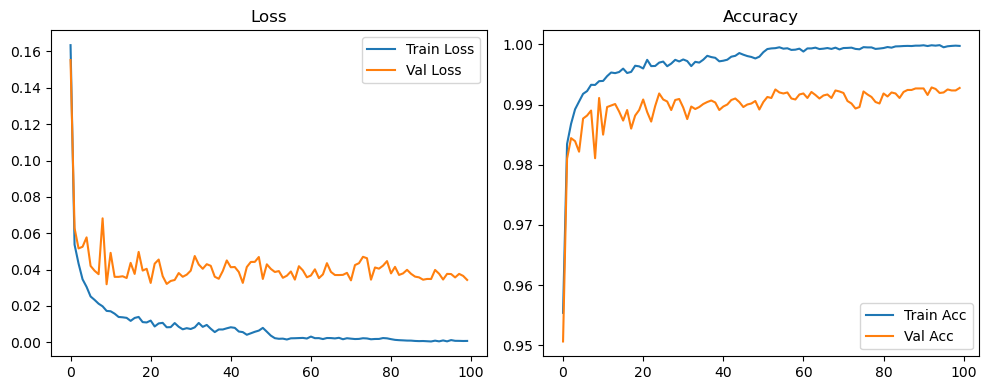

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2550, Acc: 0.9286 | Val Loss: 0.6567, Acc: 0.7587


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1086, Acc: 0.9676 | Val Loss: 0.2352, Acc: 0.9287


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0886, Acc: 0.9736 | Val Loss: 0.1434, Acc: 0.9629


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9761 | Val Loss: 0.1183, Acc: 0.9726


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9779 | Val Loss: 0.1144, Acc: 0.9717


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9796 | Val Loss: 0.1255, Acc: 0.9653


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9809 | Val Loss: 0.0971, Acc: 0.9744


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9811 | Val Loss: 0.0905, Acc: 0.9770


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9823 | Val Loss: 0.0933, Acc: 0.9776


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9832 | Val Loss: 0.0854, Acc: 0.9781


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9843 | Val Loss: 0.0786, Acc: 0.9823


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9838 | Val Loss: 0.0878, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9848 | Val Loss: 0.0738, Acc: 0.9827


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.0712, Acc: 0.9858


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9853 | Val Loss: 0.0823, Acc: 0.9796


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9854 | Val Loss: 0.0919, Acc: 0.9763


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9865 | Val Loss: 0.0742, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9868 | Val Loss: 0.0640, Acc: 0.9844


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.0522, Acc: 0.9887


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9874 | Val Loss: 0.0596, Acc: 0.9864


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9870 | Val Loss: 0.0644, Acc: 0.9867


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9877 | Val Loss: 0.0523, Acc: 0.9882


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9864 | Val Loss: 0.0683, Acc: 0.9860


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9877 | Val Loss: 0.0558, Acc: 0.9892


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.0591, Acc: 0.9878


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.0717, Acc: 0.9833


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0822, Acc: 0.9793


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9888 | Val Loss: 0.0623, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9888 | Val Loss: 0.0611, Acc: 0.9849


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9876 | Val Loss: 0.0580, Acc: 0.9858


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 0.0701, Acc: 0.9818


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9887 | Val Loss: 0.0573, Acc: 0.9840


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0701, Acc: 0.9821


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9884 | Val Loss: 0.0569, Acc: 0.9843


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0605, Acc: 0.9841


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9893 | Val Loss: 0.0506, Acc: 0.9860


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0463, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0576, Acc: 0.9846


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0468, Acc: 0.9889


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0514, Acc: 0.9869


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.0573, Acc: 0.9842


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.0463, Acc: 0.9866


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9909 | Val Loss: 0.0472, Acc: 0.9874


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9900 | Val Loss: 0.0452, Acc: 0.9889


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.0595, Acc: 0.9830


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0466, Acc: 0.9878


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.0419, Acc: 0.9908


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0448, Acc: 0.9881


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0557, Acc: 0.9858


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9911 | Val Loss: 0.0571, Acc: 0.9848


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0489, Acc: 0.9872


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0415, Acc: 0.9893


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0415, Acc: 0.9900


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0386, Acc: 0.9912


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0470, Acc: 0.9873


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0348, Acc: 0.9922


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0385, Acc: 0.9902


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0369, Acc: 0.9910


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0411, Acc: 0.9892


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0356, Acc: 0.9906


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0376, Acc: 0.9903


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0362, Acc: 0.9908


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0382, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0391, Acc: 0.9900


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.0437, Acc: 0.9888


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0391, Acc: 0.9902


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9943 | Val Loss: 0.0427, Acc: 0.9895


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0433, Acc: 0.9888


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0419, Acc: 0.9888


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0435, Acc: 0.9903


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0400, Acc: 0.9899


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0417, Acc: 0.9908


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0403, Acc: 0.9902


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0382, Acc: 0.9905


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.0486, Acc: 0.9872


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0433, Acc: 0.9904


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9938 | Val Loss: 0.0363, Acc: 0.9918


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0432, Acc: 0.9892


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0432, Acc: 0.9902


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0357, Acc: 0.9903


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0381, Acc: 0.9902


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0408, Acc: 0.9897


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0350, Acc: 0.9916


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0368, Acc: 0.9911


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0331, Acc: 0.9918


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0361, Acc: 0.9913


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0356, Acc: 0.9912


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0378, Acc: 0.9907


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0343, Acc: 0.9918


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0372, Acc: 0.9903


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0358, Acc: 0.9903


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0360, Acc: 0.9901


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0358, Acc: 0.9911


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0355, Acc: 0.9912


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0365, Acc: 0.9903


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0373, Acc: 0.9903


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0343, Acc: 0.9921


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0331, Acc: 0.9925


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0352, Acc: 0.9912


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9956 | Val Loss: 0.0330, Acc: 0.9923


Final Test Loss: 0.0284 Accuracy: 0.9918


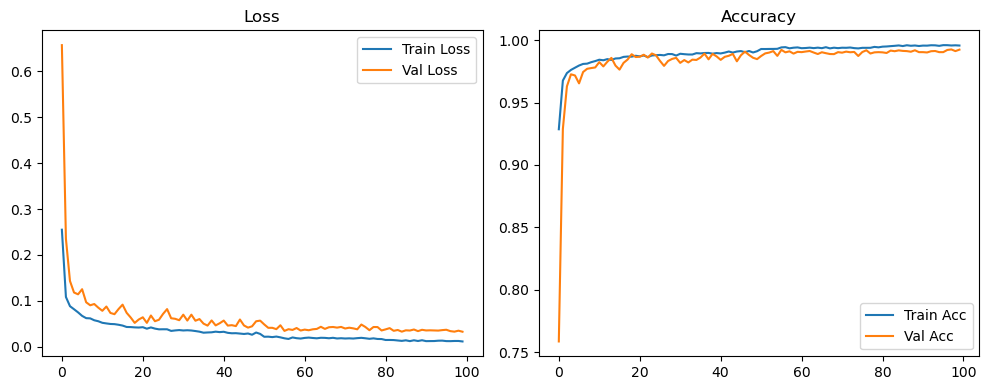

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9622 | Val Loss: 0.0600, Acc: 0.9817


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9890 | Val Loss: 0.0459, Acc: 0.9858


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0445, Acc: 0.9862


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0475, Acc: 0.9856


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0422, Acc: 0.9881


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0435, Acc: 0.9882


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0379, Acc: 0.9893


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.0519, Acc: 0.9858


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0524, Acc: 0.9867


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0390, Acc: 0.9905


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0495, Acc: 0.9878


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0428, Acc: 0.9891


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0443, Acc: 0.9898


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0459, Acc: 0.9884


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0611, Acc: 0.9870


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0478, Acc: 0.9897


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0475, Acc: 0.9890


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0475, Acc: 0.9904


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0519, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0607, Acc: 0.9861


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0506, Acc: 0.9902


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0483, Acc: 0.9909


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0385, Acc: 0.9924


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9925


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9924


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9926


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9927


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9926


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9928


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9927


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9927


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9928


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9929


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9923


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9957 | Val Loss: 0.1955, Acc: 0.9634


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9930 | Val Loss: 0.0373, Acc: 0.9901


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0378, Acc: 0.9914


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0391, Acc: 0.9910


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0373, Acc: 0.9911


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9919


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9924


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9920


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9922


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9922


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9922


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9922


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9921


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9919


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9923


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9922


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9922


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9924


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9923


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9922


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9922


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9921


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9925


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9921


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9918


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9923


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9922


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9920


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9926


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9927


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9921


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9922


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9923


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9925


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9922


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9924


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9928


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9927


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9924


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9924


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9927


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9918


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9925


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9925


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9926


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9927


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9927


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9921


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9927


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9923


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9924


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9927


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9928


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9925


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9926


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9927


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9928


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9925


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9928


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9930


Final Test Loss: 0.0414 Accuracy: 0.9924


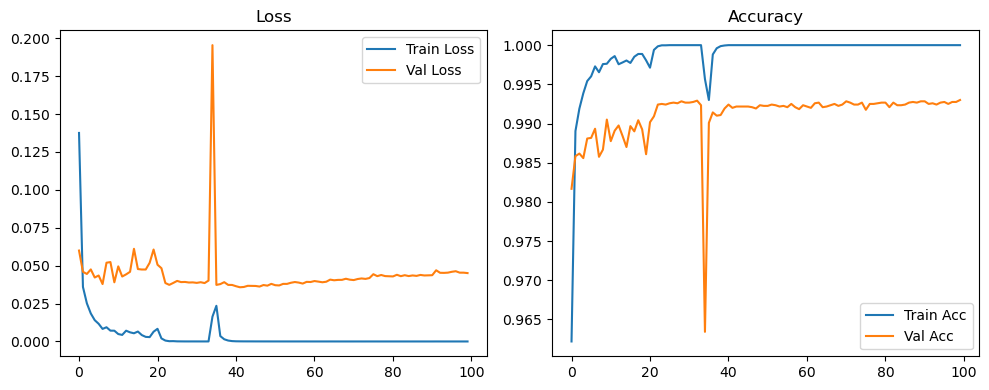

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1628, Acc: 0.9557 | Val Loss: 0.1158, Acc: 0.9653


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9838 | Val Loss: 0.0613, Acc: 0.9821


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0527, Acc: 0.9840


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.0529, Acc: 0.9842


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.0553, Acc: 0.9826


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0498, Acc: 0.9851


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.0455, Acc: 0.9858


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.0371, Acc: 0.9893


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0439, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0340, Acc: 0.9900


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0456, Acc: 0.9875


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0414, Acc: 0.9867


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0442, Acc: 0.9881


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0368, Acc: 0.9882


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0345, Acc: 0.9898


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.0341, Acc: 0.9903


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0469, Acc: 0.9867


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0404, Acc: 0.9882


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0412, Acc: 0.9870


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0371, Acc: 0.9895


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0398, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0375, Acc: 0.9899


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0398, Acc: 0.9898


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0354, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0334, Acc: 0.9907


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0319, Acc: 0.9912


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0331, Acc: 0.9911


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0372, Acc: 0.9895


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0329, Acc: 0.9904


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0329, Acc: 0.9912


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0329, Acc: 0.9918


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0420, Acc: 0.9895


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0309, Acc: 0.9922


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0508, Acc: 0.9867


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0383, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0347, Acc: 0.9907


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0379, Acc: 0.9912


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0368, Acc: 0.9900


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0427, Acc: 0.9897


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.0377, Acc: 0.9906


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.0393, Acc: 0.9901


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0340, Acc: 0.9912


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0377, Acc: 0.9904


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0294, Acc: 0.9921


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0321, Acc: 0.9917


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0320, Acc: 0.9920


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0361, Acc: 0.9919


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0462, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0336, Acc: 0.9924


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0374, Acc: 0.9916


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0340, Acc: 0.9928


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0337, Acc: 0.9926


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0326, Acc: 0.9930


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0321, Acc: 0.9927


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0333, Acc: 0.9927


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0335, Acc: 0.9915


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0366, Acc: 0.9920


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0415, Acc: 0.9901


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0369, Acc: 0.9920


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0320, Acc: 0.9923


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0365, Acc: 0.9922


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0390, Acc: 0.9921


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0356, Acc: 0.9918


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0393, Acc: 0.9925


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0393, Acc: 0.9922


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0347, Acc: 0.9928


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0381, Acc: 0.9915


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0384, Acc: 0.9921


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0485, Acc: 0.9903


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0349, Acc: 0.9920


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0375, Acc: 0.9913


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0396, Acc: 0.9907


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0370, Acc: 0.9912


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0378, Acc: 0.9909


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9907


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0356, Acc: 0.9918


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0331, Acc: 0.9926


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0338, Acc: 0.9925


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0388, Acc: 0.9916


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0376, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0337, Acc: 0.9927


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0350, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0338, Acc: 0.9927


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0349, Acc: 0.9927


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0340, Acc: 0.9928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0340, Acc: 0.9934


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0337, Acc: 0.9930


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0342, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0323, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0325, Acc: 0.9932


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0327, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0340, Acc: 0.9931


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0318, Acc: 0.9933


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0330, Acc: 0.9931


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0336, Acc: 0.9929


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0334, Acc: 0.9931


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0336, Acc: 0.9929


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0325, Acc: 0.9929


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0321, Acc: 0.9930


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0311, Acc: 0.9935


Final Test Loss: 0.0239 Accuracy: 0.9937


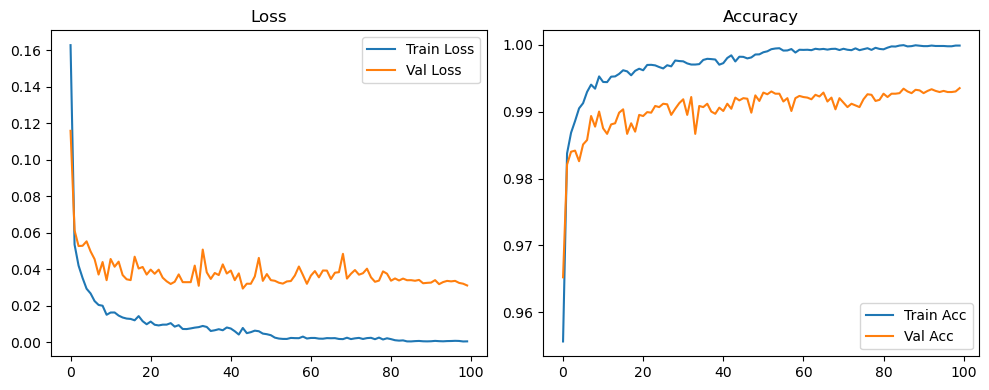

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2547, Acc: 0.9286 | Val Loss: 0.6843, Acc: 0.7502


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9677 | Val Loss: 0.1904, Acc: 0.9457


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9725 | Val Loss: 0.1636, Acc: 0.9553


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9751 | Val Loss: 0.1174, Acc: 0.9721


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9780 | Val Loss: 0.1127, Acc: 0.9758


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9786 | Val Loss: 0.1476, Acc: 0.9588


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9799 | Val Loss: 0.0951, Acc: 0.9760


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9812 | Val Loss: 0.0867, Acc: 0.9808


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9822 | Val Loss: 0.0949, Acc: 0.9802


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9830 | Val Loss: 0.0704, Acc: 0.9843


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9834 | Val Loss: 0.0962, Acc: 0.9778


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9842 | Val Loss: 0.0735, Acc: 0.9833


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9853 | Val Loss: 0.0636, Acc: 0.9860


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9847 | Val Loss: 0.0684, Acc: 0.9865


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9853 | Val Loss: 0.0655, Acc: 0.9840


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.0708, Acc: 0.9824


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9869 | Val Loss: 0.0725, Acc: 0.9821


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9863 | Val Loss: 0.0656, Acc: 0.9857


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9869 | Val Loss: 0.0615, Acc: 0.9837


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9863 | Val Loss: 0.0637, Acc: 0.9858


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9866 | Val Loss: 0.0717, Acc: 0.9819


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.0606, Acc: 0.9856


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.0713, Acc: 0.9823


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.0580, Acc: 0.9883


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0628, Acc: 0.9829


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9876 | Val Loss: 0.0731, Acc: 0.9808


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.0607, Acc: 0.9840


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9891 | Val Loss: 0.0566, Acc: 0.9856


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9886 | Val Loss: 0.0612, Acc: 0.9844


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0796, Acc: 0.9790


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.0530, Acc: 0.9858


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9889 | Val Loss: 0.0555, Acc: 0.9837


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9889 | Val Loss: 0.0685, Acc: 0.9805


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0499, Acc: 0.9874


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0493, Acc: 0.9869


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.0529, Acc: 0.9858


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 0.0516, Acc: 0.9878


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0524, Acc: 0.9867


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.0489, Acc: 0.9890


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.0559, Acc: 0.9862


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.0739, Acc: 0.9794


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0511, Acc: 0.9871


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.0432, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.0432, Acc: 0.9889


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0581, Acc: 0.9836


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9903 | Val Loss: 0.0530, Acc: 0.9851


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.0434, Acc: 0.9898


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9918 | Val Loss: 0.0461, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9911 | Val Loss: 0.0528, Acc: 0.9872


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.0519, Acc: 0.9864


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0487, Acc: 0.9869


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.0401, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.0424, Acc: 0.9896


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0429, Acc: 0.9880


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0463, Acc: 0.9872


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0396, Acc: 0.9898


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0398, Acc: 0.9898


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.0404, Acc: 0.9894


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9934 | Val Loss: 0.0391, Acc: 0.9904


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9941 | Val Loss: 0.0430, Acc: 0.9884


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0399, Acc: 0.9890


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0411, Acc: 0.9892


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9926 | Val Loss: 0.0388, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0438, Acc: 0.9879


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0417, Acc: 0.9890


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0385, Acc: 0.9902


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0378, Acc: 0.9904


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0396, Acc: 0.9895


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0373, Acc: 0.9910


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0423, Acc: 0.9895


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0383, Acc: 0.9904


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9935 | Val Loss: 0.0402, Acc: 0.9897


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9937 | Val Loss: 0.0379, Acc: 0.9905


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0388, Acc: 0.9908


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.0446, Acc: 0.9885


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0358, Acc: 0.9910


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0362, Acc: 0.9915


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0406, Acc: 0.9892


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0380, Acc: 0.9915


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0387, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0386, Acc: 0.9908


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0403, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0368, Acc: 0.9915


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0384, Acc: 0.9914


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0365, Acc: 0.9914


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0375, Acc: 0.9916


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0367, Acc: 0.9917


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0359, Acc: 0.9917


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0363, Acc: 0.9916


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0355, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0358, Acc: 0.9912


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0339, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0336, Acc: 0.9923


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0338, Acc: 0.9919


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0367, Acc: 0.9913


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0364, Acc: 0.9914


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0351, Acc: 0.9920


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0326, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.0341, Acc: 0.9918


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0337, Acc: 0.9921


Final Test Loss: 0.0307 Accuracy: 0.9921


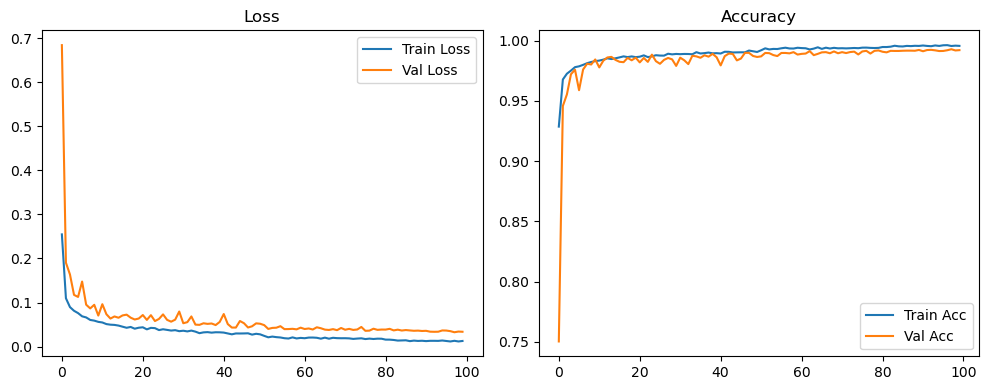

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9622 | Val Loss: 0.0547, Acc: 0.9844


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9887 | Val Loss: 0.0424, Acc: 0.9866


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0621, Acc: 0.9817


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0418, Acc: 0.9868


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0385, Acc: 0.9882


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0437, Acc: 0.9874


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0418, Acc: 0.9876


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0569, Acc: 0.9851


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0612, Acc: 0.9852


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0501, Acc: 0.9880


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0498, Acc: 0.9880


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0387, Acc: 0.9905


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0395, Acc: 0.9905


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0380, Acc: 0.9903


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0404, Acc: 0.9910


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0495, Acc: 0.9892


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0485, Acc: 0.9888


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0573, Acc: 0.9873


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0386, Acc: 0.9925


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0505, Acc: 0.9896


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0378, Acc: 0.9919


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0351, Acc: 0.9926


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0690, Acc: 0.9853


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0542, Acc: 0.9892


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0549, Acc: 0.9897


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0453, Acc: 0.9903


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0464, Acc: 0.9906


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0456, Acc: 0.9921


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0423, Acc: 0.9921


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0444, Acc: 0.9916


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0509, Acc: 0.9903


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0934, Acc: 0.9833


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0707, Acc: 0.9845


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0401, Acc: 0.9921


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0422, Acc: 0.9924


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0591, Acc: 0.9883


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0520, Acc: 0.9914


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0534, Acc: 0.9892


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0617, Acc: 0.9888


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0467, Acc: 0.9911


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0467, Acc: 0.9911


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0478, Acc: 0.9912


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0513, Acc: 0.9910


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0555, Acc: 0.9894


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0505, Acc: 0.9912


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0420, Acc: 0.9923


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9926


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9929


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9929


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9927


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9928


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9931


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9930


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9930


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9930


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9929


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9928


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9932


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9930


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9932


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9932


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9930


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9932


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9936


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9933


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9931


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9934


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9933


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9932


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9931


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9933


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9932


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9932


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9932


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9933


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9934


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9933


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9930


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9932


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9931


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9931


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9932


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9932


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9932


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9935


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9933


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9933


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9929


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9935


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9935


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9931


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9935


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9935


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9934


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9932


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9932


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9933


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9934


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9932


Final Test Loss: 0.0357 Accuracy: 0.9935


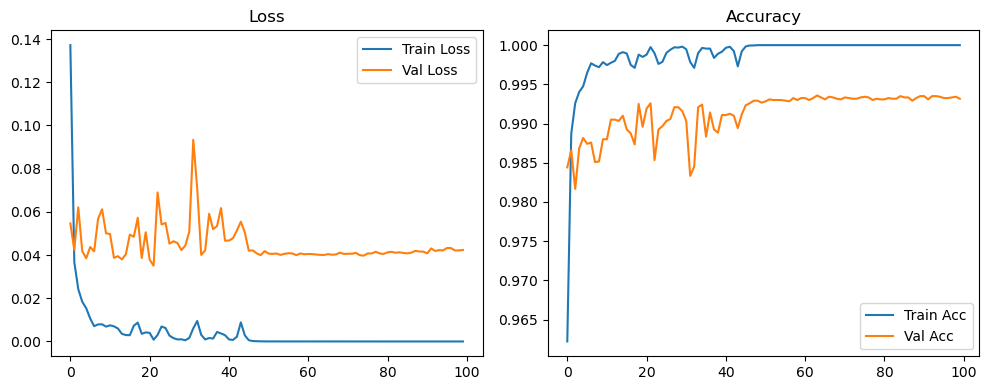

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1631, Acc: 0.9551 | Val Loss: 0.1502, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9835 | Val Loss: 0.0580, Acc: 0.9828


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9865 | Val Loss: 0.0736, Acc: 0.9773


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0477, Acc: 0.9852


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.0564, Acc: 0.9830


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0537, Acc: 0.9835


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0374, Acc: 0.9887


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0371, Acc: 0.9893


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.0450, Acc: 0.9874


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0310, Acc: 0.9908


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.0349, Acc: 0.9901


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0401, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.0401, Acc: 0.9889


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.0386, Acc: 0.9897


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9951 | Val Loss: 0.0354, Acc: 0.9892


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0369, Acc: 0.9895


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9959 | Val Loss: 0.0342, Acc: 0.9901


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0441, Acc: 0.9883


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9957 | Val Loss: 0.0458, Acc: 0.9872


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0416, Acc: 0.9890


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0437, Acc: 0.9876


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0410, Acc: 0.9897


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0436, Acc: 0.9878


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0373, Acc: 0.9905


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0384, Acc: 0.9901


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0406, Acc: 0.9893


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0361, Acc: 0.9908


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0519, Acc: 0.9868


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0339, Acc: 0.9920


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0331, Acc: 0.9922


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0443, Acc: 0.9882


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0355, Acc: 0.9902


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0439, Acc: 0.9889


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9975 | Val Loss: 0.0372, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0395, Acc: 0.9902


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0407, Acc: 0.9905


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0343, Acc: 0.9915


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0426, Acc: 0.9894


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0417, Acc: 0.9913


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0367, Acc: 0.9916


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0410, Acc: 0.9900


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0375, Acc: 0.9906


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0446, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0407, Acc: 0.9894


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0373, Acc: 0.9902


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0447, Acc: 0.9888


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0398, Acc: 0.9912


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0459, Acc: 0.9895


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0514, Acc: 0.9880


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0558, Acc: 0.9873


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0427, Acc: 0.9898


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0378, Acc: 0.9911


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0415, Acc: 0.9902


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0424, Acc: 0.9902


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0404, Acc: 0.9907


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0382, Acc: 0.9915


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0426, Acc: 0.9908


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0408, Acc: 0.9908


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0415, Acc: 0.9908


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0391, Acc: 0.9917


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0373, Acc: 0.9918


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0387, Acc: 0.9915


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0379, Acc: 0.9922


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0369, Acc: 0.9923


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0373, Acc: 0.9923


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0386, Acc: 0.9921


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0376, Acc: 0.9928


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0395, Acc: 0.9926


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0390, Acc: 0.9924


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0402, Acc: 0.9918


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0407, Acc: 0.9920


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0433, Acc: 0.9919


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0448, Acc: 0.9921


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0453, Acc: 0.9910


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0425, Acc: 0.9922


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0416, Acc: 0.9922


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0385, Acc: 0.9927


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0354, Acc: 0.9932


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0374, Acc: 0.9929


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0372, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0355, Acc: 0.9931


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0404, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0374, Acc: 0.9926


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0412, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0394, Acc: 0.9927


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0404, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0406, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0396, Acc: 0.9925


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0385, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0379, Acc: 0.9927


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0382, Acc: 0.9924


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0390, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9929


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0383, Acc: 0.9928


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0376, Acc: 0.9925


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0405, Acc: 0.9919


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0408, Acc: 0.9918


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0390, Acc: 0.9926


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0394, Acc: 0.9925


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0371, Acc: 0.9931


Final Test Loss: 0.0319 Accuracy: 0.9923


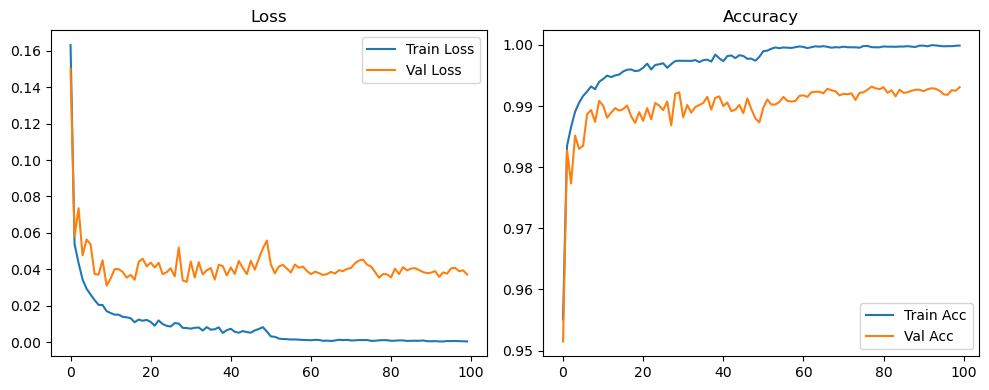

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2553, Acc: 0.9286 | Val Loss: 0.6678, Acc: 0.7558


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9680 | Val Loss: 0.1743, Acc: 0.9532


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9734 | Val Loss: 0.1881, Acc: 0.9427


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0829, Acc: 0.9752 | Val Loss: 0.1313, Acc: 0.9666


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9778 | Val Loss: 0.1238, Acc: 0.9721


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9784 | Val Loss: 0.1318, Acc: 0.9645


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9809 | Val Loss: 0.0794, Acc: 0.9820


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9806 | Val Loss: 0.1081, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9822 | Val Loss: 0.0934, Acc: 0.9795


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9832 | Val Loss: 0.0865, Acc: 0.9786


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9834 | Val Loss: 0.0852, Acc: 0.9829


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9840 | Val Loss: 0.0779, Acc: 0.9842


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9849 | Val Loss: 0.0965, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9839 | Val Loss: 0.0865, Acc: 0.9822


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9858 | Val Loss: 0.0742, Acc: 0.9832


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9858 | Val Loss: 0.0754, Acc: 0.9814


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9860 | Val Loss: 0.0786, Acc: 0.9803


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9866 | Val Loss: 0.0715, Acc: 0.9848


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9866 | Val Loss: 0.0752, Acc: 0.9807


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.0601, Acc: 0.9872


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.0749, Acc: 0.9842


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9883 | Val Loss: 0.0562, Acc: 0.9868


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9866 | Val Loss: 0.0633, Acc: 0.9869


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.0583, Acc: 0.9890


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0660, Acc: 0.9831


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9877 | Val Loss: 0.0600, Acc: 0.9867


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.0572, Acc: 0.9878


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.0566, Acc: 0.9857


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9891 | Val Loss: 0.0651, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.0540, Acc: 0.9884


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9887 | Val Loss: 0.0529, Acc: 0.9871


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.0512, Acc: 0.9883


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9900 | Val Loss: 0.0525, Acc: 0.9882


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9888 | Val Loss: 0.0537, Acc: 0.9872


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0575, Acc: 0.9848


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0525, Acc: 0.9858


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.0558, Acc: 0.9855


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9905 | Val Loss: 0.0604, Acc: 0.9849


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0555, Acc: 0.9868


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.0442, Acc: 0.9877


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.0605, Acc: 0.9846


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0552, Acc: 0.9856


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0554, Acc: 0.9848


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9903 | Val Loss: 0.0653, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9917 | Val Loss: 0.0683, Acc: 0.9816


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0518, Acc: 0.9866


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0478, Acc: 0.9883


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0491, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0552, Acc: 0.9857


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0511, Acc: 0.9872


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9921 | Val Loss: 0.0477, Acc: 0.9881


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.0423, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0437, Acc: 0.9897


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0413, Acc: 0.9898


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9939 | Val Loss: 0.0448, Acc: 0.9892


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0398, Acc: 0.9909


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0388, Acc: 0.9905


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0394, Acc: 0.9892


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0435, Acc: 0.9898


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0397, Acc: 0.9895


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0385, Acc: 0.9908


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0378, Acc: 0.9901


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0391, Acc: 0.9905


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0406, Acc: 0.9897


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0381, Acc: 0.9905


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0397, Acc: 0.9909


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0400, Acc: 0.9897


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0400, Acc: 0.9894


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0396, Acc: 0.9892


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0392, Acc: 0.9898


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0364, Acc: 0.9905


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0371, Acc: 0.9909


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0384, Acc: 0.9905


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0379, Acc: 0.9902


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0408, Acc: 0.9898


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0411, Acc: 0.9903


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0374, Acc: 0.9913


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0426, Acc: 0.9892


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0413, Acc: 0.9898


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0380, Acc: 0.9911


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0386, Acc: 0.9901


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0413, Acc: 0.9898


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0368, Acc: 0.9910


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0392, Acc: 0.9899


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9950 | Val Loss: 0.0366, Acc: 0.9911


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0374, Acc: 0.9918


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0371, Acc: 0.9909


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0366, Acc: 0.9916


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0368, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0369, Acc: 0.9912


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0393, Acc: 0.9903


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0375, Acc: 0.9908


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0377, Acc: 0.9906


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0370, Acc: 0.9911


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0401, Acc: 0.9901


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0390, Acc: 0.9904


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0391, Acc: 0.9902


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0362, Acc: 0.9911


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0395, Acc: 0.9901


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0372, Acc: 0.9910


Final Test Loss: 0.0312 Accuracy: 0.9926


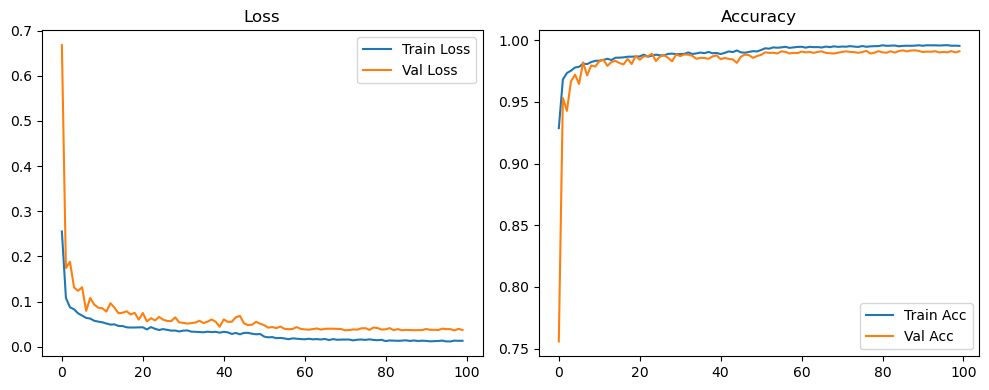

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1476, Acc: 0.9674 | Val Loss: 0.0583, Acc: 0.9823


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9900 | Val Loss: 0.0413, Acc: 0.9873


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9933 | Val Loss: 0.0576, Acc: 0.9826


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.0578, Acc: 0.9811


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0369, Acc: 0.9883


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.0402, Acc: 0.9877


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0433, Acc: 0.9879


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0389, Acc: 0.9899


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0415, Acc: 0.9882


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0364, Acc: 0.9895


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0390, Acc: 0.9902


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0497, Acc: 0.9863


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0489, Acc: 0.9869


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0425, Acc: 0.9897


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0362, Acc: 0.9910


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0373, Acc: 0.9915


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0469, Acc: 0.9896


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0455, Acc: 0.9903


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0534, Acc: 0.9872


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0494, Acc: 0.9890


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0352, Acc: 0.9918


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0474, Acc: 0.9900


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0331, Acc: 0.9925


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0411, Acc: 0.9912


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9922


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9925


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9927


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9928


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9926


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9931


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9929


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9932


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9928


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9931


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9932


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9931


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9934


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9932


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9932


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9932


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9937


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9931


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9937


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9933


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9934


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9934


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9936


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9934


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9935


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9937


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9933


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9935


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9936


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9936


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9937


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9935


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9935


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9935


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9933


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9932


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9933


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9935


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9932


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9933


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9931


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9938


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9937


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9934


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9937


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9938


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9938


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9935


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9933


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9935


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9938


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9936


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9938


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9941


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9939


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9936


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9936


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9937


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9939


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9940


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9941


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9942


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9940


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9937


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9960 | Val Loss: 0.2028, Acc: 0.9662


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9916 | Val Loss: 0.0435, Acc: 0.9888


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0341, Acc: 0.9927


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0354, Acc: 0.9919


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0341, Acc: 0.9932


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9935


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9937


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9937


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9928


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9938


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9937


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9937


Final Test Loss: 0.0301 Accuracy: 0.9926


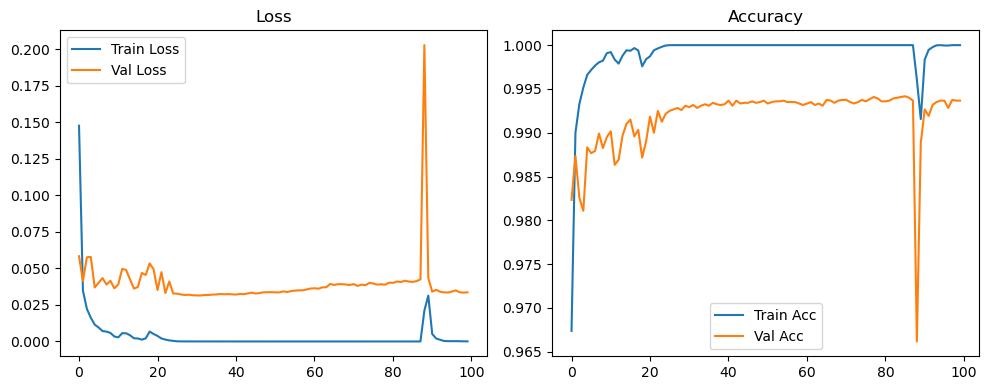

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1756, Acc: 0.9595 | Val Loss: 0.1083, Acc: 0.9677


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9854 | Val Loss: 0.0528, Acc: 0.9850


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.0527, Acc: 0.9842


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.0452, Acc: 0.9863


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0410, Acc: 0.9877


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0444, Acc: 0.9858


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0430, Acc: 0.9863


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.0412, Acc: 0.9877


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0475, Acc: 0.9851


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0305, Acc: 0.9915


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.0368, Acc: 0.9892


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0382, Acc: 0.9880


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0317, Acc: 0.9903


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0294, Acc: 0.9915


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0318, Acc: 0.9907


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0382, Acc: 0.9899


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0375, Acc: 0.9888


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0344, Acc: 0.9898


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0392, Acc: 0.9891


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0366, Acc: 0.9896


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0391, Acc: 0.9889


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0326, Acc: 0.9905


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0346, Acc: 0.9894


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0320, Acc: 0.9912


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.0297, Acc: 0.9920


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0283, Acc: 0.9928


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0334, Acc: 0.9908


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0412, Acc: 0.9887


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0327, Acc: 0.9922


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0298, Acc: 0.9922


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0438, Acc: 0.9898


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0372, Acc: 0.9909


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0319, Acc: 0.9921


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0369, Acc: 0.9909


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0342, Acc: 0.9902


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0366, Acc: 0.9906


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0288, Acc: 0.9928


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0363, Acc: 0.9906


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0350, Acc: 0.9910


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0355, Acc: 0.9913


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0402, Acc: 0.9902


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0336, Acc: 0.9915


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0315, Acc: 0.9922


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0357, Acc: 0.9918


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0314, Acc: 0.9923


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0317, Acc: 0.9929


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0358, Acc: 0.9926


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0417, Acc: 0.9902


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0397, Acc: 0.9901


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0319, Acc: 0.9924


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0300, Acc: 0.9926


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0399, Acc: 0.9911


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0342, Acc: 0.9923


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0374, Acc: 0.9909


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0338, Acc: 0.9921


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0350, Acc: 0.9925


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0324, Acc: 0.9925


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0363, Acc: 0.9919


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0412, Acc: 0.9918


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0361, Acc: 0.9919


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0345, Acc: 0.9924


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0377, Acc: 0.9917


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0302, Acc: 0.9928


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0341, Acc: 0.9915


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0336, Acc: 0.9930


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0330, Acc: 0.9931


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0315, Acc: 0.9930


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0299, Acc: 0.9936


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0398, Acc: 0.9913


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0337, Acc: 0.9914


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0358, Acc: 0.9923


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0431, Acc: 0.9911


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0312, Acc: 0.9940


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0331, Acc: 0.9926


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0400, Acc: 0.9917


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0328, Acc: 0.9925


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0311, Acc: 0.9926


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0328, Acc: 0.9923


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0299, Acc: 0.9932


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0332, Acc: 0.9922


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0296, Acc: 0.9942


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0367, Acc: 0.9930


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0328, Acc: 0.9932


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0390, Acc: 0.9919


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0332, Acc: 0.9929


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0336, Acc: 0.9928


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0351, Acc: 0.9932


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0403, Acc: 0.9927


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0354, Acc: 0.9928


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9924


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0382, Acc: 0.9912


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0372, Acc: 0.9916


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0374, Acc: 0.9920


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0374, Acc: 0.9922


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0377, Acc: 0.9924


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0355, Acc: 0.9928


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0405, Acc: 0.9922


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0357, Acc: 0.9930


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0380, Acc: 0.9924


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0327, Acc: 0.9936


Final Test Loss: 0.0267 Accuracy: 0.9928


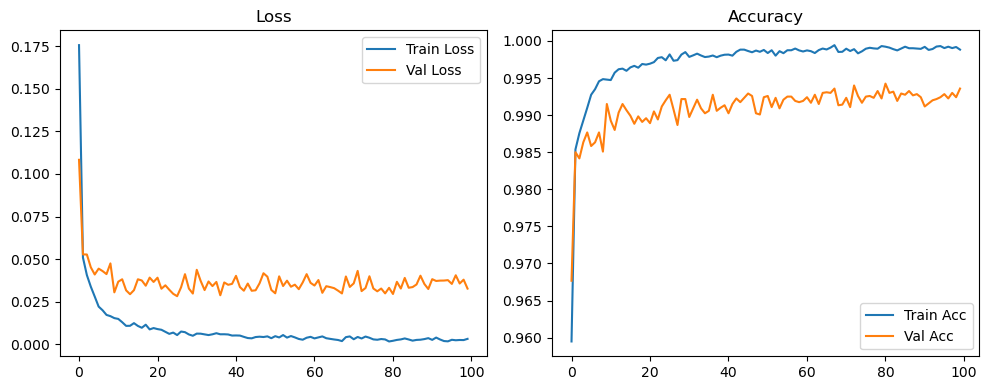

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2706, Acc: 0.9329 | Val Loss: 0.7494, Acc: 0.7088


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1064, Acc: 0.9693 | Val Loss: 0.2324, Acc: 0.9281


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9729 | Val Loss: 0.1703, Acc: 0.9513


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9771 | Val Loss: 0.1228, Acc: 0.9662


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9789 | Val Loss: 0.0926, Acc: 0.9778


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9811 | Val Loss: 0.0712, Acc: 0.9821


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9816 | Val Loss: 0.0939, Acc: 0.9751


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9819 | Val Loss: 0.0977, Acc: 0.9720


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9841 | Val Loss: 0.0887, Acc: 0.9771


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9839 | Val Loss: 0.0946, Acc: 0.9732


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9850 | Val Loss: 0.0769, Acc: 0.9799


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.0843, Acc: 0.9782


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9860 | Val Loss: 0.0719, Acc: 0.9813


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9865 | Val Loss: 0.0636, Acc: 0.9837


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9859 | Val Loss: 0.0666, Acc: 0.9815


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.0706, Acc: 0.9810


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9876 | Val Loss: 0.0527, Acc: 0.9866


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.0613, Acc: 0.9833


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9883 | Val Loss: 0.0534, Acc: 0.9857


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9882 | Val Loss: 0.0550, Acc: 0.9854


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.0555, Acc: 0.9855


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0609, Acc: 0.9842


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0628, Acc: 0.9836


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.0681, Acc: 0.9825


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.0518, Acc: 0.9868


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.0497, Acc: 0.9871


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.0614, Acc: 0.9838


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9903 | Val Loss: 0.0572, Acc: 0.9845


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0570, Acc: 0.9849


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0540, Acc: 0.9849


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0568, Acc: 0.9823


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9903 | Val Loss: 0.0485, Acc: 0.9858


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0508, Acc: 0.9856


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9905 | Val Loss: 0.0465, Acc: 0.9882


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0552, Acc: 0.9849


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0497, Acc: 0.9852


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.0450, Acc: 0.9890


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.0491, Acc: 0.9869


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.0456, Acc: 0.9878


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.0568, Acc: 0.9835


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0536, Acc: 0.9848


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.0444, Acc: 0.9887


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0496, Acc: 0.9866


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0437, Acc: 0.9890


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0615, Acc: 0.9817


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9919 | Val Loss: 0.0492, Acc: 0.9868


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0558, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.0506, Acc: 0.9869


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0504, Acc: 0.9867


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.0626, Acc: 0.9842


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.0480, Acc: 0.9862


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0468, Acc: 0.9891


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9918 | Val Loss: 0.0503, Acc: 0.9881


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0551, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0695, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.0423, Acc: 0.9884


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.0450, Acc: 0.9879


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.0469, Acc: 0.9870


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0545, Acc: 0.9854


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0490, Acc: 0.9875


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0485, Acc: 0.9881


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0491, Acc: 0.9880


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0436, Acc: 0.9905


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0520, Acc: 0.9879


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9927 | Val Loss: 0.0496, Acc: 0.9884


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0512, Acc: 0.9872


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0491, Acc: 0.9881


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0489, Acc: 0.9868


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0391, Acc: 0.9904


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.0457, Acc: 0.9884


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.0428, Acc: 0.9889


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0429, Acc: 0.9896


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0420, Acc: 0.9896


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0417, Acc: 0.9898


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0443, Acc: 0.9879


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0447, Acc: 0.9890


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0472, Acc: 0.9891


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0449, Acc: 0.9900


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0437, Acc: 0.9896


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0375, Acc: 0.9912


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0453, Acc: 0.9900


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0489, Acc: 0.9898


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0495, Acc: 0.9889


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0480, Acc: 0.9874


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0457, Acc: 0.9890


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0443, Acc: 0.9879


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0432, Acc: 0.9891


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0417, Acc: 0.9894


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0405, Acc: 0.9898


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0455, Acc: 0.9871


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0423, Acc: 0.9892


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9939 | Val Loss: 0.0479, Acc: 0.9888


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0413, Acc: 0.9902


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0470, Acc: 0.9884


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.0458, Acc: 0.9884


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0506, Acc: 0.9873


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0402, Acc: 0.9900


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0423, Acc: 0.9898


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0495, Acc: 0.9879


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9933 | Val Loss: 0.0440, Acc: 0.9881


Final Test Loss: 0.0379 Accuracy: 0.9898


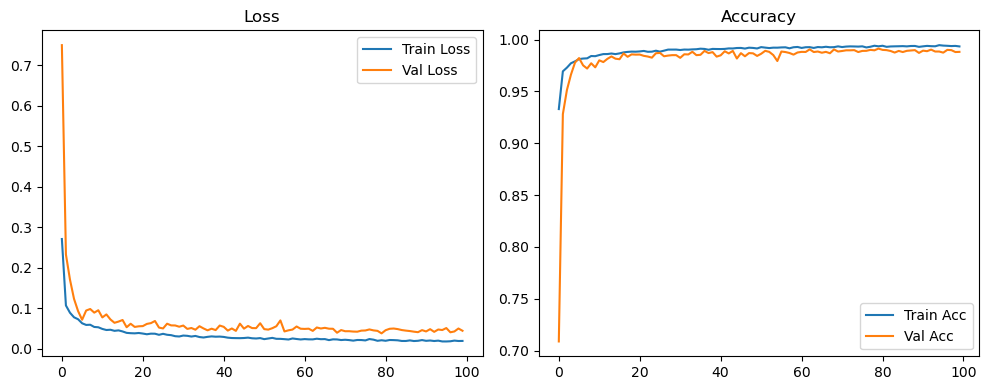

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1478, Acc: 0.9671 | Val Loss: 0.0518, Acc: 0.9842


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9900 | Val Loss: 0.0404, Acc: 0.9875


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0575, Acc: 0.9824


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.0649, Acc: 0.9801


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.0335, Acc: 0.9901


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0342, Acc: 0.9898


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0365, Acc: 0.9901


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0403, Acc: 0.9888


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0469, Acc: 0.9876


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0403, Acc: 0.9886


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0494, Acc: 0.9859


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0468, Acc: 0.9877


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0369, Acc: 0.9894


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0352, Acc: 0.9914


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0358, Acc: 0.9914


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0449, Acc: 0.9898


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0378, Acc: 0.9912


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0363, Acc: 0.9912


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0459, Acc: 0.9900


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0632, Acc: 0.9854


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0373, Acc: 0.9904


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0335, Acc: 0.9910


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0320, Acc: 0.9924


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0368, Acc: 0.9921


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9922


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9922


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9921


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9922


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9927


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0395, Acc: 0.9908


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0576, Acc: 0.9869


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0437, Acc: 0.9888


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0304, Acc: 0.9930


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0368, Acc: 0.9916


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0305, Acc: 0.9934


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0293, Acc: 0.9939


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0297, Acc: 0.9938


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9938


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9935


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9937


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0294, Acc: 0.9939


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0295, Acc: 0.9937


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0296, Acc: 0.9940


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0297, Acc: 0.9939


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9937


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0297, Acc: 0.9935


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0298, Acc: 0.9938


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9937


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9939


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0573, Acc: 0.9883


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0390, Acc: 0.9919


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0344, Acc: 0.9926


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0336, Acc: 0.9934


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9932


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9931


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9930


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9929


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9936


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9932


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9932


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9931


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9931


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9933


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9934


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9933


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9932


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9934


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9935


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9932


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9937


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9931


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9937


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9933


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9938


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9936


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9934


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9933


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9933


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9937


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9933


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9936


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9933


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9932


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9932


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9934


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9934


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9937


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9937


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9935


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9933


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9933


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9936


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9935


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9934


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9934


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9933


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9934


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9933


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9932


Final Test Loss: 0.0366 Accuracy: 0.9932


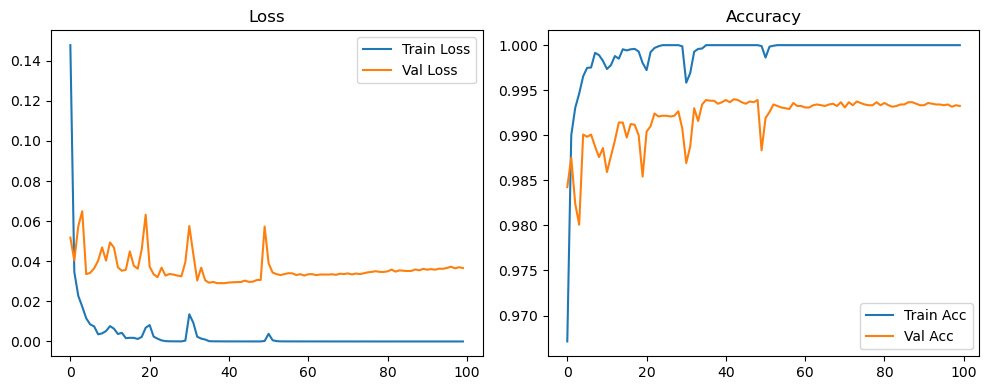

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1758, Acc: 0.9595 | Val Loss: 0.0990, Acc: 0.9718


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9857 | Val Loss: 0.0594, Acc: 0.9826


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9872 | Val Loss: 0.0520, Acc: 0.9847


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9899 | Val Loss: 0.0512, Acc: 0.9835


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.0516, Acc: 0.9829


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0494, Acc: 0.9838


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0455, Acc: 0.9851


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0456, Acc: 0.9860


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0474, Acc: 0.9848


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0342, Acc: 0.9899


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0473, Acc: 0.9854


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0480, Acc: 0.9846


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0435, Acc: 0.9863


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0330, Acc: 0.9894


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0294, Acc: 0.9911


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0340, Acc: 0.9900


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0364, Acc: 0.9892


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0352, Acc: 0.9898


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0308, Acc: 0.9911


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0310, Acc: 0.9913


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0320, Acc: 0.9919


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0417, Acc: 0.9895


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0309, Acc: 0.9912


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0312, Acc: 0.9922


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0391, Acc: 0.9892


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0340, Acc: 0.9903


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0321, Acc: 0.9919


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0311, Acc: 0.9911


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0351, Acc: 0.9917


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0302, Acc: 0.9923


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0364, Acc: 0.9905


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0406, Acc: 0.9903


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0323, Acc: 0.9922


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0345, Acc: 0.9912


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9981 | Val Loss: 0.0359, Acc: 0.9918


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.0327, Acc: 0.9922


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0326, Acc: 0.9928


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0354, Acc: 0.9914


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0282, Acc: 0.9933


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0336, Acc: 0.9924


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0353, Acc: 0.9924


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0361, Acc: 0.9909


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0370, Acc: 0.9914


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0413, Acc: 0.9907


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0371, Acc: 0.9911


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0308, Acc: 0.9924


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0305, Acc: 0.9925


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0385, Acc: 0.9918


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0380, Acc: 0.9916


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0401, Acc: 0.9907


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0320, Acc: 0.9927


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0310, Acc: 0.9927


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0322, Acc: 0.9928


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0325, Acc: 0.9928


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0313, Acc: 0.9924


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0331, Acc: 0.9926


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0335, Acc: 0.9930


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0327, Acc: 0.9932


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0342, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0326, Acc: 0.9932


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0316, Acc: 0.9931


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0300, Acc: 0.9933


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0294, Acc: 0.9932


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0300, Acc: 0.9934


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0308, Acc: 0.9936


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0308, Acc: 0.9933


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0311, Acc: 0.9939


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0320, Acc: 0.9929


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0321, Acc: 0.9935


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0329, Acc: 0.9935


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0317, Acc: 0.9935


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0345, Acc: 0.9933


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0324, Acc: 0.9932


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0329, Acc: 0.9932


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0385, Acc: 0.9925


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0378, Acc: 0.9920


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0333, Acc: 0.9934


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0353, Acc: 0.9928


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0352, Acc: 0.9921


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0368, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0353, Acc: 0.9926


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0366, Acc: 0.9917


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0333, Acc: 0.9925


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0347, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0340, Acc: 0.9928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0332, Acc: 0.9926


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0362, Acc: 0.9923


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0376, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0351, Acc: 0.9925


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0365, Acc: 0.9920


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0325, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9926


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0334, Acc: 0.9926


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0312, Acc: 0.9928


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0337, Acc: 0.9924


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0331, Acc: 0.9930


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0325, Acc: 0.9931


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0322, Acc: 0.9938


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0334, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0304, Acc: 0.9938


Final Test Loss: 0.0247 Accuracy: 0.9944


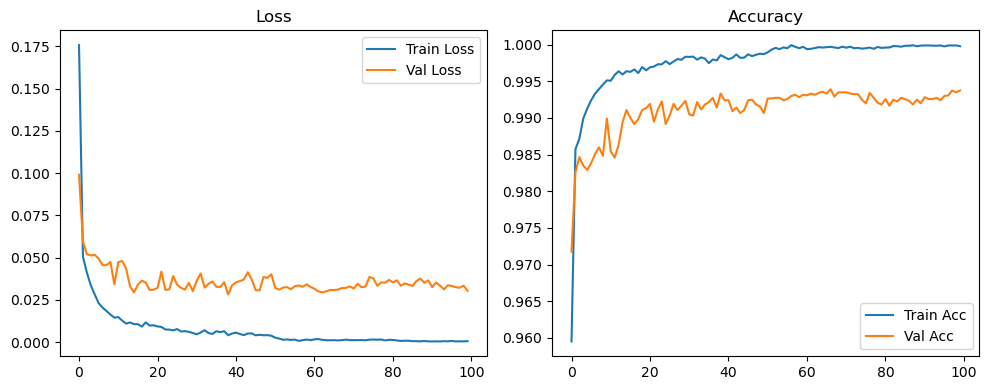

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2708, Acc: 0.9330 | Val Loss: 0.5536, Acc: 0.7923


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1062, Acc: 0.9695 | Val Loss: 0.2364, Acc: 0.9271


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9731 | Val Loss: 0.1420, Acc: 0.9626


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9769 | Val Loss: 0.1269, Acc: 0.9643


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0727, Acc: 0.9785 | Val Loss: 0.1007, Acc: 0.9762


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9815 | Val Loss: 0.0720, Acc: 0.9817


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9807 | Val Loss: 0.0698, Acc: 0.9832


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9829 | Val Loss: 0.0937, Acc: 0.9732


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9842 | Val Loss: 0.0773, Acc: 0.9796


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9845 | Val Loss: 0.0706, Acc: 0.9830


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9853 | Val Loss: 0.0810, Acc: 0.9791


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9856 | Val Loss: 0.0697, Acc: 0.9819


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9865 | Val Loss: 0.0643, Acc: 0.9838


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 0.0502, Acc: 0.9882


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.0650, Acc: 0.9822


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9872 | Val Loss: 0.0664, Acc: 0.9817


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9878 | Val Loss: 0.0555, Acc: 0.9844


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.0624, Acc: 0.9842


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.0528, Acc: 0.9868


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.0524, Acc: 0.9867


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0636, Acc: 0.9833


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9890 | Val Loss: 0.0543, Acc: 0.9859


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.0480, Acc: 0.9887


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.0535, Acc: 0.9872


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0455, Acc: 0.9880


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.0376, Acc: 0.9904


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.0467, Acc: 0.9878


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9903 | Val Loss: 0.0417, Acc: 0.9888


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.0547, Acc: 0.9844


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 0.0439, Acc: 0.9883


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.0493, Acc: 0.9861


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0531, Acc: 0.9851


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9903 | Val Loss: 0.0617, Acc: 0.9829


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0417, Acc: 0.9897


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.0452, Acc: 0.9873


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9915 | Val Loss: 0.0439, Acc: 0.9881


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0414, Acc: 0.9887


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.0402, Acc: 0.9911


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9911 | Val Loss: 0.0410, Acc: 0.9885


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0397, Acc: 0.9902


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.0440, Acc: 0.9880


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0425, Acc: 0.9890


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.0452, Acc: 0.9865


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.0446, Acc: 0.9880


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0555, Acc: 0.9835


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0445, Acc: 0.9882


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0488, Acc: 0.9864


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.0473, Acc: 0.9880


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0397, Acc: 0.9903


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0573, Acc: 0.9848


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0437, Acc: 0.9894


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0414, Acc: 0.9902


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.0407, Acc: 0.9903


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0394, Acc: 0.9896


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0431, Acc: 0.9886


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0413, Acc: 0.9888


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0413, Acc: 0.9886


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0371, Acc: 0.9905


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0379, Acc: 0.9905


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0391, Acc: 0.9893


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0379, Acc: 0.9906


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0387, Acc: 0.9897


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0378, Acc: 0.9897


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.0390, Acc: 0.9894


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0381, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0377, Acc: 0.9915


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0367, Acc: 0.9911


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0364, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0352, Acc: 0.9908


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0340, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0348, Acc: 0.9915


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.0362, Acc: 0.9912


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0367, Acc: 0.9910


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0384, Acc: 0.9909


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.0376, Acc: 0.9904


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.0387, Acc: 0.9900


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0364, Acc: 0.9912


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0380, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0402, Acc: 0.9899


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0369, Acc: 0.9902


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0359, Acc: 0.9914


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0391, Acc: 0.9898


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0358, Acc: 0.9911


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0381, Acc: 0.9902


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0369, Acc: 0.9908


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0375, Acc: 0.9912


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0372, Acc: 0.9905


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0356, Acc: 0.9911


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0351, Acc: 0.9910


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0370, Acc: 0.9912


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0346, Acc: 0.9913


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0360, Acc: 0.9907


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0333, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0353, Acc: 0.9909


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0344, Acc: 0.9916


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0353, Acc: 0.9910


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0342, Acc: 0.9910


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0320, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0339, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0319, Acc: 0.9915


Final Test Loss: 0.0273 Accuracy: 0.9923


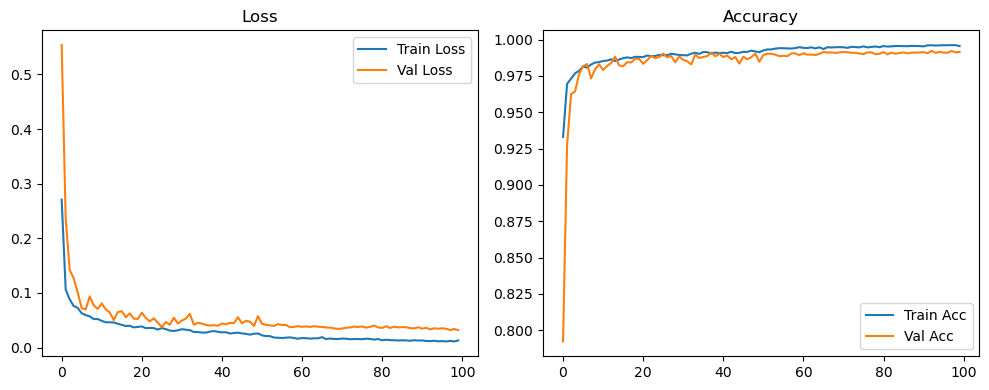

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2004, Acc: 0.9671 | Val Loss: 0.0569, Acc: 0.9859


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9898 | Val Loss: 0.0408, Acc: 0.9881


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9935 | Val Loss: 0.0449, Acc: 0.9875


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9957 | Val Loss: 0.0397, Acc: 0.9874


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9977 | Val Loss: 0.0324, Acc: 0.9904


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9979 | Val Loss: 0.0373, Acc: 0.9876


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0370, Acc: 0.9884


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9991 | Val Loss: 0.0321, Acc: 0.9902


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0355, Acc: 0.9896


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.0326, Acc: 0.9904


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9997 | Val Loss: 0.0347, Acc: 0.9900


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.0342, Acc: 0.9898


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0402, Acc: 0.9885


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0440, Acc: 0.9868


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9907


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0311, Acc: 0.9908


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0280, Acc: 0.9921


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0285, Acc: 0.9918


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0272, Acc: 0.9919


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0270, Acc: 0.9922


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0268, Acc: 0.9926


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0270, Acc: 0.9923


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0274, Acc: 0.9924


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0281, Acc: 0.9922


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0274, Acc: 0.9922


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0277, Acc: 0.9922


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0284, Acc: 0.9919


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0278, Acc: 0.9922


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0281, Acc: 0.9921


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0282, Acc: 0.9926


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0290, Acc: 0.9922


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0287, Acc: 0.9922


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0283, Acc: 0.9922


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0289, Acc: 0.9922


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0290, Acc: 0.9922


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0296, Acc: 0.9919


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0297, Acc: 0.9924


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9923


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9921


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9925


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9920


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9921


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9919


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9921


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9920


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9921


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9921


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9918


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9922


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9919


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9923


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9923


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9923


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9925


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9923


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9928


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9926


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9921


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9921


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9925


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9922


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9922


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9923


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9925


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9922


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9926


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9952 | Val Loss: 0.1840, Acc: 0.9597


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9914 | Val Loss: 0.0348, Acc: 0.9902


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0342, Acc: 0.9904


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0303, Acc: 0.9912


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9922


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9919


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9919


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9922


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9922


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9920


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9919


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9919


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9918


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9922


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9922


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9924


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9923


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9923


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9919


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9920


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9926


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9925


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9921


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9922


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9922


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9926


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9921


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9922


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9924


Final Test Loss: 0.0297 Accuracy: 0.9930


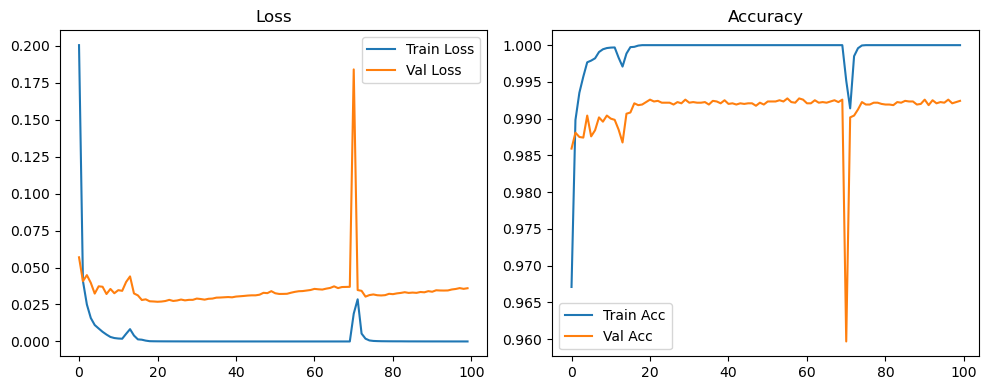

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2323, Acc: 0.9601 | Val Loss: 0.1317, Acc: 0.9661


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9856 | Val Loss: 0.0789, Acc: 0.9785


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9880 | Val Loss: 0.0621, Acc: 0.9822


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9906 | Val Loss: 0.0509, Acc: 0.9860


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9919 | Val Loss: 0.0529, Acc: 0.9838


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9928 | Val Loss: 0.0509, Acc: 0.9849


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9940 | Val Loss: 0.0390, Acc: 0.9880


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9952 | Val Loss: 0.0417, Acc: 0.9869


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.0377, Acc: 0.9879


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0319, Acc: 0.9894


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0409, Acc: 0.9884


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0377, Acc: 0.9884


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0386, Acc: 0.9891


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0261, Acc: 0.9924


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0319, Acc: 0.9900


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0330, Acc: 0.9912


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0322, Acc: 0.9901


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0361, Acc: 0.9904


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0285, Acc: 0.9917


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0330, Acc: 0.9902


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0294, Acc: 0.9918


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0337, Acc: 0.9912


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0302, Acc: 0.9911


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0293, Acc: 0.9919


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0313, Acc: 0.9913


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0307, Acc: 0.9912


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0346, Acc: 0.9902


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0332, Acc: 0.9912


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0374, Acc: 0.9898


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0302, Acc: 0.9895


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0273, Acc: 0.9927


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0351, Acc: 0.9907


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0309, Acc: 0.9910


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0336, Acc: 0.9917


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0329, Acc: 0.9920


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9982 | Val Loss: 0.0299, Acc: 0.9923


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0320, Acc: 0.9912


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0284, Acc: 0.9926


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0279, Acc: 0.9931


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0322, Acc: 0.9925


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0307, Acc: 0.9922


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0293, Acc: 0.9921


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0336, Acc: 0.9921


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0272, Acc: 0.9930


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0320, Acc: 0.9926


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0290, Acc: 0.9929


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0309, Acc: 0.9923


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0383, Acc: 0.9908


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0328, Acc: 0.9919


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0372, Acc: 0.9912


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0327, Acc: 0.9919


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0316, Acc: 0.9928


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0341, Acc: 0.9922


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0296, Acc: 0.9933


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0319, Acc: 0.9921


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0348, Acc: 0.9918


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0369, Acc: 0.9906


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0346, Acc: 0.9911


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0338, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0341, Acc: 0.9924


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0318, Acc: 0.9920


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0358, Acc: 0.9915


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0296, Acc: 0.9930


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0335, Acc: 0.9923


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0331, Acc: 0.9924


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0298, Acc: 0.9934


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0335, Acc: 0.9923


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0357, Acc: 0.9926


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0350, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0294, Acc: 0.9932


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0300, Acc: 0.9937


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0345, Acc: 0.9922


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0344, Acc: 0.9929


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0350, Acc: 0.9928


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0402, Acc: 0.9914


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0354, Acc: 0.9921


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0363, Acc: 0.9916


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0353, Acc: 0.9909


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0300, Acc: 0.9928


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0316, Acc: 0.9927


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0286, Acc: 0.9934


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0308, Acc: 0.9932


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0313, Acc: 0.9936


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0309, Acc: 0.9925


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0317, Acc: 0.9930


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0364, Acc: 0.9922


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0344, Acc: 0.9933


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0361, Acc: 0.9920


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0346, Acc: 0.9924


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0375, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0342, Acc: 0.9930


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0317, Acc: 0.9922


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0335, Acc: 0.9931


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0326, Acc: 0.9932


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0330, Acc: 0.9931


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0338, Acc: 0.9927


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0354, Acc: 0.9928


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0347, Acc: 0.9931


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0348, Acc: 0.9930


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0379, Acc: 0.9923


Final Test Loss: 0.0299 Accuracy: 0.9928


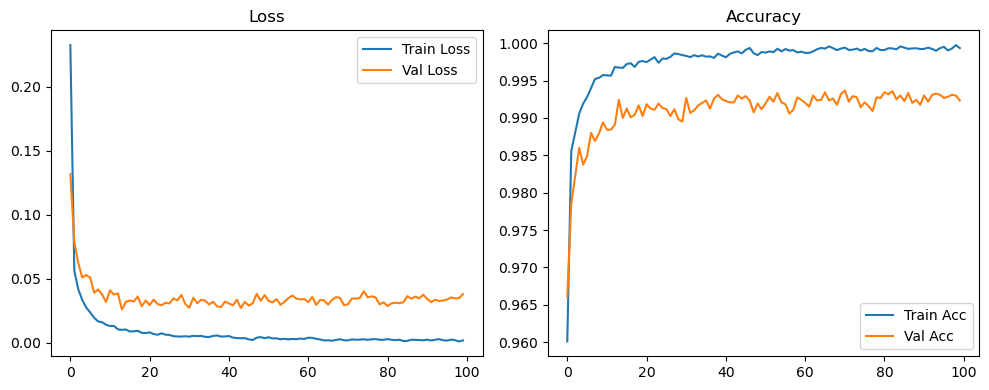

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3488, Acc: 0.9306 | Val Loss: 0.7751, Acc: 0.6871


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1183, Acc: 0.9692 | Val Loss: 0.3595, Acc: 0.8751


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9726 | Val Loss: 0.2096, Acc: 0.9390


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0806, Acc: 0.9771 | Val Loss: 0.1954, Acc: 0.9417


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9782 | Val Loss: 0.1393, Acc: 0.9612


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9812 | Val Loss: 0.1191, Acc: 0.9673


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9811 | Val Loss: 0.1057, Acc: 0.9717


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9825 | Val Loss: 0.0805, Acc: 0.9801


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9841 | Val Loss: 0.1014, Acc: 0.9728


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9837 | Val Loss: 0.0632, Acc: 0.9835


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9846 | Val Loss: 0.0678, Acc: 0.9818


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9856 | Val Loss: 0.0700, Acc: 0.9830


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9869 | Val Loss: 0.0648, Acc: 0.9839


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9870 | Val Loss: 0.0563, Acc: 0.9869


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9861 | Val Loss: 0.0591, Acc: 0.9858


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9873 | Val Loss: 0.0563, Acc: 0.9856


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.0540, Acc: 0.9857


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.0568, Acc: 0.9852


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0514, Acc: 0.9872


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9890 | Val Loss: 0.0463, Acc: 0.9868


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9888 | Val Loss: 0.0453, Acc: 0.9882


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9894 | Val Loss: 0.0503, Acc: 0.9873


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.0441, Acc: 0.9881


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9901 | Val Loss: 0.0437, Acc: 0.9888


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9898 | Val Loss: 0.0544, Acc: 0.9847


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.0438, Acc: 0.9892


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0469, Acc: 0.9870


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0456, Acc: 0.9875


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0501, Acc: 0.9866


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0423, Acc: 0.9889


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0519, Acc: 0.9848


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0466, Acc: 0.9868


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0560, Acc: 0.9843


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.0401, Acc: 0.9902


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.0587, Acc: 0.9841


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.0500, Acc: 0.9860


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9914 | Val Loss: 0.0483, Acc: 0.9868


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.0491, Acc: 0.9845


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0446, Acc: 0.9872


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0414, Acc: 0.9895


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0446, Acc: 0.9872


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0472, Acc: 0.9864


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9923 | Val Loss: 0.0472, Acc: 0.9873


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0548, Acc: 0.9839


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9920 | Val Loss: 0.0500, Acc: 0.9870


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0438, Acc: 0.9875


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0421, Acc: 0.9888


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.0430, Acc: 0.9876


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0398, Acc: 0.9885


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0448, Acc: 0.9878


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.0393, Acc: 0.9888


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0373, Acc: 0.9895


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0405, Acc: 0.9889


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0399, Acc: 0.9893


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0429, Acc: 0.9885


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0435, Acc: 0.9889


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9934 | Val Loss: 0.0403, Acc: 0.9887


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.0381, Acc: 0.9902


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.0422, Acc: 0.9883


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0388, Acc: 0.9891


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0388, Acc: 0.9902


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.0348, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0365, Acc: 0.9902


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0418, Acc: 0.9884


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0375, Acc: 0.9906


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0381, Acc: 0.9904


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0373, Acc: 0.9900


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0433, Acc: 0.9882


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0357, Acc: 0.9905


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0379, Acc: 0.9902


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0353, Acc: 0.9905


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0340, Acc: 0.9907


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0296, Acc: 0.9910


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0338, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.0330, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0301, Acc: 0.9922


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9930 | Val Loss: 0.0375, Acc: 0.9902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.0347, Acc: 0.9904


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0390, Acc: 0.9895


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0336, Acc: 0.9909


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0350, Acc: 0.9906


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0423, Acc: 0.9878


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0375, Acc: 0.9893


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9932 | Val Loss: 0.0348, Acc: 0.9900


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0419, Acc: 0.9875


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0441, Acc: 0.9880


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0392, Acc: 0.9892


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0367, Acc: 0.9903


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0394, Acc: 0.9883


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9943 | Val Loss: 0.0342, Acc: 0.9897


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0365, Acc: 0.9888


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0427, Acc: 0.9869


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0344, Acc: 0.9901


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0360, Acc: 0.9895


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0409, Acc: 0.9881


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0373, Acc: 0.9894


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0342, Acc: 0.9898


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0326, Acc: 0.9907


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.0397, Acc: 0.9884


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0406, Acc: 0.9875


Final Test Loss: 0.0397 Accuracy: 0.9884


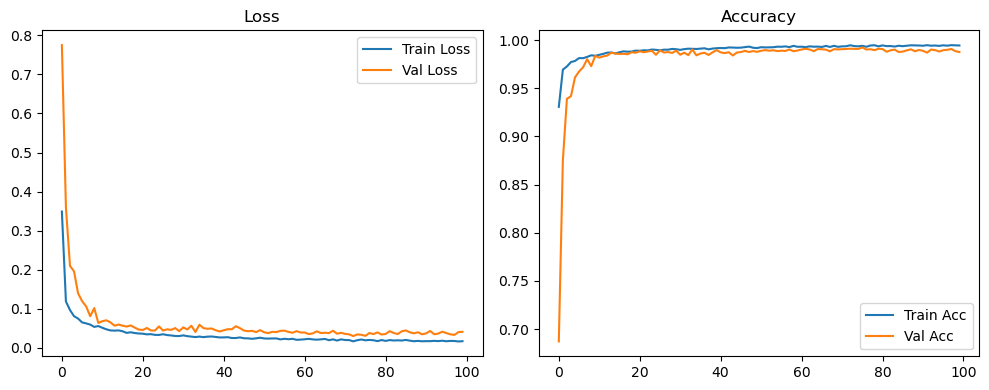

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2827, Acc: 0.9636 | Val Loss: 0.0852, Acc: 0.9848


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0539, Acc: 0.9899 | Val Loss: 0.0482, Acc: 0.9888


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9938 | Val Loss: 0.0568, Acc: 0.9859


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9958 | Val Loss: 0.0478, Acc: 0.9861


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9976 | Val Loss: 0.0359, Acc: 0.9897


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9986 | Val Loss: 0.0333, Acc: 0.9890


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9992 | Val Loss: 0.0321, Acc: 0.9902


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9998 | Val Loss: 0.0312, Acc: 0.9903


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9998 | Val Loss: 0.0328, Acc: 0.9901


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9999 | Val Loss: 0.0299, Acc: 0.9911


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9999 | Val Loss: 0.0311, Acc: 0.9912


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9996 | Val Loss: 0.0415, Acc: 0.9876


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.0463, Acc: 0.9856


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0394, Acc: 0.9885


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.0320, Acc: 0.9902


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9998 | Val Loss: 0.0286, Acc: 0.9916


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0264, Acc: 0.9927


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0264, Acc: 0.9928


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0272, Acc: 0.9927


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0265, Acc: 0.9930


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0269, Acc: 0.9931


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0273, Acc: 0.9929


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9928


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0277, Acc: 0.9929


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0273, Acc: 0.9929


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9932


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0286, Acc: 0.9927


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0282, Acc: 0.9929


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0283, Acc: 0.9928


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0285, Acc: 0.9932


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9926


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0285, Acc: 0.9932


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0287, Acc: 0.9929


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0290, Acc: 0.9930


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0298, Acc: 0.9932


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0297, Acc: 0.9930


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0297, Acc: 0.9932


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0296, Acc: 0.9932


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9932


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9934


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9932


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9932


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9935


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9932


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9932


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9933


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9933


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9932


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9934


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9934


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9932


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9934


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9932


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9932


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9932


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9933


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9932


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9934


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9934


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9932


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9931


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9932


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9933


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9932


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9933


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9913 | Val Loss: 0.0486, Acc: 0.9851


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0329, Acc: 0.9887


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0281, Acc: 0.9918


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9998 | Val Loss: 0.0273, Acc: 0.9921


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0261, Acc: 0.9929


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0283, Acc: 0.9922


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9931


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9927


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0283, Acc: 0.9928


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0284, Acc: 0.9929


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0293, Acc: 0.9925


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0293, Acc: 0.9928


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0294, Acc: 0.9928


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0296, Acc: 0.9929


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9926


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9925


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9927


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9928


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9926


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9928


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9925


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9926


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9930


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9927


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9928


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9930


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9927


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9941 | Val Loss: 0.0364, Acc: 0.9903


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0366, Acc: 0.9903


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0291, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9932


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0287, Acc: 0.9932


Final Test Loss: 0.0244 Accuracy: 0.9927


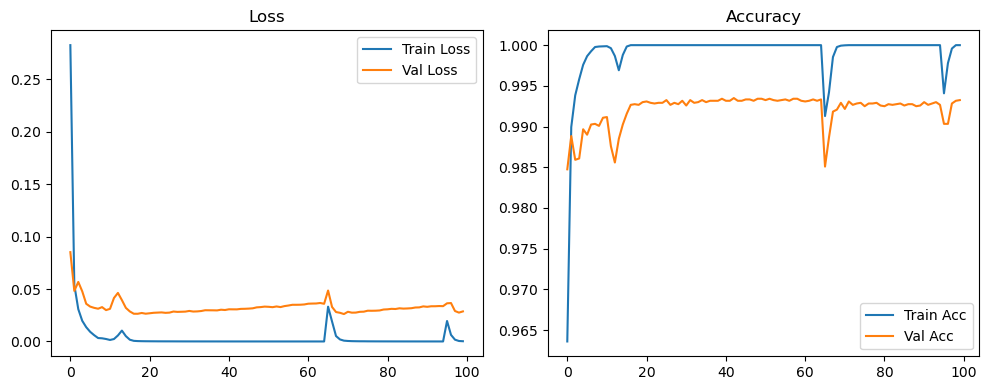

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3245, Acc: 0.9555 | Val Loss: 0.1760, Acc: 0.9704


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0744, Acc: 0.9847 | Val Loss: 0.1139, Acc: 0.9745


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9883 | Val Loss: 0.0773, Acc: 0.9818


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9906 | Val Loss: 0.0627, Acc: 0.9842


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9910 | Val Loss: 0.0546, Acc: 0.9855


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9928 | Val Loss: 0.0533, Acc: 0.9852


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9945 | Val Loss: 0.0425, Acc: 0.9880


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9945 | Val Loss: 0.0440, Acc: 0.9869


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9956 | Val Loss: 0.0445, Acc: 0.9863


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9956 | Val Loss: 0.0381, Acc: 0.9882


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9960 | Val Loss: 0.0385, Acc: 0.9884


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9967 | Val Loss: 0.0349, Acc: 0.9893


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9968 | Val Loss: 0.0407, Acc: 0.9885


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0295, Acc: 0.9911


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0355, Acc: 0.9894


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.0340, Acc: 0.9906


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.0324, Acc: 0.9903


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0371, Acc: 0.9895


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0306, Acc: 0.9909


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0328, Acc: 0.9893


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0319, Acc: 0.9906


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.0361, Acc: 0.9902


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0363, Acc: 0.9894


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0347, Acc: 0.9901


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0344, Acc: 0.9908


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0323, Acc: 0.9905


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0308, Acc: 0.9909


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0329, Acc: 0.9902


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0364, Acc: 0.9893


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0330, Acc: 0.9900


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0316, Acc: 0.9913


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0320, Acc: 0.9908


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0358, Acc: 0.9902


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0334, Acc: 0.9910


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0406, Acc: 0.9888


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0322, Acc: 0.9918


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0344, Acc: 0.9909


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0310, Acc: 0.9923


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0301, Acc: 0.9916


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0316, Acc: 0.9918


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0333, Acc: 0.9909


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0306, Acc: 0.9918


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0328, Acc: 0.9910


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0299, Acc: 0.9917


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0307, Acc: 0.9921


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0369, Acc: 0.9907


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0295, Acc: 0.9914


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0313, Acc: 0.9909


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0268, Acc: 0.9932


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0319, Acc: 0.9916


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0330, Acc: 0.9908


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0328, Acc: 0.9912


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0312, Acc: 0.9920


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0282, Acc: 0.9920


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0302, Acc: 0.9917


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0329, Acc: 0.9922


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0308, Acc: 0.9927


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0329, Acc: 0.9916


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0350, Acc: 0.9921


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0342, Acc: 0.9919


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0353, Acc: 0.9912


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9904


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0316, Acc: 0.9913


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0312, Acc: 0.9917


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0350, Acc: 0.9914


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0285, Acc: 0.9932


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0349, Acc: 0.9918


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0305, Acc: 0.9922


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0337, Acc: 0.9923


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0317, Acc: 0.9928


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0332, Acc: 0.9922


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0319, Acc: 0.9921


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0290, Acc: 0.9930


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0335, Acc: 0.9921


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0318, Acc: 0.9919


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0299, Acc: 0.9928


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0295, Acc: 0.9928


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.0317, Acc: 0.9914


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0294, Acc: 0.9928


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0317, Acc: 0.9926


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0307, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0314, Acc: 0.9921


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0298, Acc: 0.9930


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0285, Acc: 0.9932


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0264, Acc: 0.9929


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0350, Acc: 0.9914


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0321, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0318, Acc: 0.9916


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0348, Acc: 0.9923


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0302, Acc: 0.9931


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0311, Acc: 0.9926


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0308, Acc: 0.9926


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0367, Acc: 0.9919


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0328, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0335, Acc: 0.9920


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0311, Acc: 0.9927


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0317, Acc: 0.9929


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0316, Acc: 0.9925


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0305, Acc: 0.9929


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0290, Acc: 0.9929


Final Test Loss: 0.0244 Accuracy: 0.9930


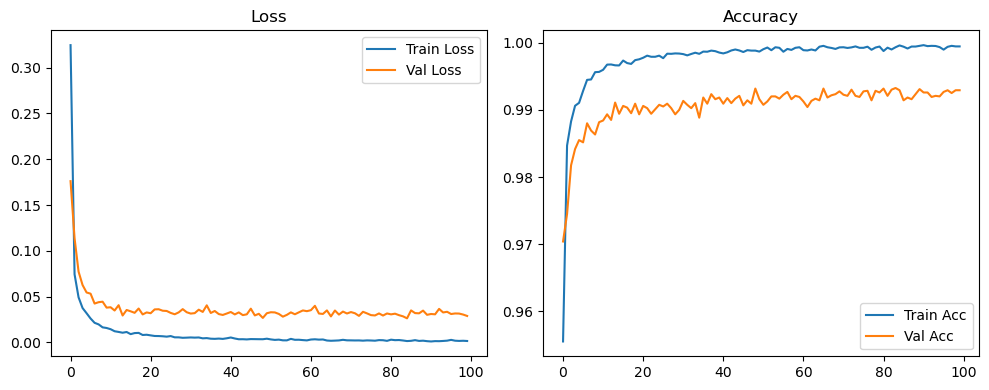

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4715, Acc: 0.9191 | Val Loss: 0.8914, Acc: 0.6385


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1491, Acc: 0.9676 | Val Loss: 0.5220, Acc: 0.8043


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1114, Acc: 0.9715 | Val Loss: 0.3584, Acc: 0.8747


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0907, Acc: 0.9757 | Val Loss: 0.2589, Acc: 0.9205


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9766 | Val Loss: 0.2319, Acc: 0.9327


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0715, Acc: 0.9802 | Val Loss: 0.1673, Acc: 0.9533


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0681, Acc: 0.9803 | Val Loss: 0.1265, Acc: 0.9677


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9815 | Val Loss: 0.1146, Acc: 0.9678


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9833 | Val Loss: 0.1139, Acc: 0.9711


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9831 | Val Loss: 0.0926, Acc: 0.9762


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0559, Acc: 0.9836 | Val Loss: 0.0944, Acc: 0.9768


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9850 | Val Loss: 0.0863, Acc: 0.9782


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9851 | Val Loss: 0.0846, Acc: 0.9787


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9864 | Val Loss: 0.0870, Acc: 0.9764


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9864 | Val Loss: 0.0873, Acc: 0.9770


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9870 | Val Loss: 0.0858, Acc: 0.9776


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9875 | Val Loss: 0.0783, Acc: 0.9787


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9878 | Val Loss: 0.0778, Acc: 0.9779


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.0722, Acc: 0.9788


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9880 | Val Loss: 0.0653, Acc: 0.9818


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9885 | Val Loss: 0.0670, Acc: 0.9821


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0557, Acc: 0.9854


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.0526, Acc: 0.9865


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9895 | Val Loss: 0.0541, Acc: 0.9862


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9894 | Val Loss: 0.0619, Acc: 0.9818


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9893 | Val Loss: 0.0501, Acc: 0.9867


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9901 | Val Loss: 0.0474, Acc: 0.9872


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9896 | Val Loss: 0.0487, Acc: 0.9867


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.0466, Acc: 0.9870


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9903 | Val Loss: 0.0430, Acc: 0.9888


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9903 | Val Loss: 0.0492, Acc: 0.9868


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0455, Acc: 0.9864


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0579, Acc: 0.9839


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9909 | Val Loss: 0.0455, Acc: 0.9878


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0530, Acc: 0.9850


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9915 | Val Loss: 0.0402, Acc: 0.9885


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9923 | Val Loss: 0.0409, Acc: 0.9889


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.0415, Acc: 0.9884


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.0423, Acc: 0.9878


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0399, Acc: 0.9898


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0437, Acc: 0.9874


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9911 | Val Loss: 0.0490, Acc: 0.9858


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.0493, Acc: 0.9863


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0517, Acc: 0.9853


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.0457, Acc: 0.9871


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0508, Acc: 0.9849


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0437, Acc: 0.9865


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 0.0489, Acc: 0.9861


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0470, Acc: 0.9867


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0474, Acc: 0.9866


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0398, Acc: 0.9890


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9929 | Val Loss: 0.0396, Acc: 0.9902


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9927 | Val Loss: 0.0427, Acc: 0.9884


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0418, Acc: 0.9884


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.0419, Acc: 0.9888


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0388, Acc: 0.9899


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.0452, Acc: 0.9874


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0397, Acc: 0.9898


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0456, Acc: 0.9875


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9926 | Val Loss: 0.0415, Acc: 0.9886


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.0418, Acc: 0.9891


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0409, Acc: 0.9888


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9935 | Val Loss: 0.0374, Acc: 0.9909


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0409, Acc: 0.9895


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0337, Acc: 0.9924


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0349, Acc: 0.9913


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0354, Acc: 0.9919


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0362, Acc: 0.9912


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0392, Acc: 0.9904


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0371, Acc: 0.9900


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0333, Acc: 0.9927


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0383, Acc: 0.9908


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0379, Acc: 0.9907


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0350, Acc: 0.9916


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0374, Acc: 0.9913


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0366, Acc: 0.9908


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0402, Acc: 0.9893


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0439, Acc: 0.9894


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0430, Acc: 0.9891


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0447, Acc: 0.9876


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.0390, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0417, Acc: 0.9905


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0376, Acc: 0.9910


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0437, Acc: 0.9878


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0346, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0402, Acc: 0.9902


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0380, Acc: 0.9905


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0426, Acc: 0.9892


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0368, Acc: 0.9901


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0349, Acc: 0.9911


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0353, Acc: 0.9909


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0429, Acc: 0.9878


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0335, Acc: 0.9919


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9939 | Val Loss: 0.0418, Acc: 0.9882


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.0378, Acc: 0.9908


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0381, Acc: 0.9906


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0344, Acc: 0.9908


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0337, Acc: 0.9903


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9948 | Val Loss: 0.0394, Acc: 0.9889


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0383, Acc: 0.9898


Final Test Loss: 0.0346 Accuracy: 0.9903


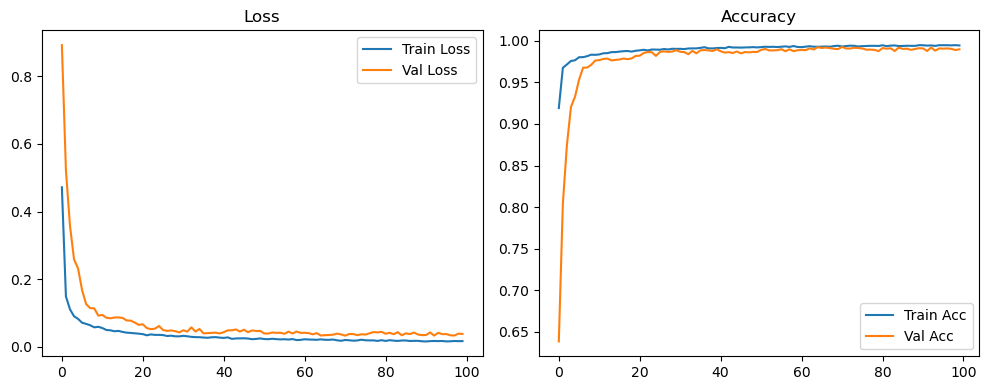

🏆 Best Config: batch256_lr0.005_0.002_0.001_dp0.2 Accuracy: 0.9944


In [8]:
root_path = "TCV_float_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)